---
# Models Perdormance Assesment 
---
- model perdormance is assesed based on model selection which is based on model features. The goal is to test weather the ensemble and applying a threshold will improve the model performance
- In the model selection below, one variable is isolated at a time (most of the time) , in order to asses its impact on the performance 
- Further analysis will combine well performing model features ... 
- In order to these results to be impactful, they need to persist across diferent years of backtesting  

In [1]:
import pandas as pd
import pickle
import random
import numpy as np
import os
import itertools
from joblib import Parallel, delayed , parallel_backend
from collections import defaultdict
import math
import torch.nn as nn
import json
import matplotlib.pyplot as plt
import pickle

from Equations_Run_Combo_V_2 import *
from Results_Dists_V_2 import *

import pickle

with open('/Users/cs/Desktop/LSTM_ETF_V2/short_dfs.pkl', 'rb') as f:
    loaded_dfs = pickle.load(f)

with open("/Users/cs/Desktop/LSTM_ETF_V2/lagged_cache.pkl", "rb") as f:
    lagged_cache = pickle.load(f)


#/home/charifslmn/

In [2]:
#                                                       DATA SETS


with open("/Users/cs/Desktop/DATA_LSTM_ETF_V2/Vset_NOTsorted_90_models_GS_21_01_to_22_12_DIST_Discovery_10percentPOS_HOD.json" , "r") as f:
    results_dist_disc_Vset_NOTsorted_same_seeds = json.load(f)

results_dist_disc_Vset_NOTsorted_same_seeds_copy = copy.deepcopy(results_dist_disc_Vset_NOTsorted_same_seeds)
results_dist_disc = []
ignore_find_combo = ['seed_num']

combo_idxs = np.arange(len(results_dist_disc_Vset_NOTsorted_same_seeds_copy) + 1).tolist()
combo_idxs_counter = 0

for idx ,entry in enumerate(results_dist_disc_Vset_NOTsorted_same_seeds_copy):
    organized_results_entry = {} ## entry for results_dist_disc
    params_done = [e['combo'] for e in results_dist_disc] ## for each entry, there is a combo , these are unique
    params_done_keys = [str({k: v for k, v in c.items() if k not in ignore_find_combo}).replace(' ', '').replace("'", '').replace('  ', '').replace(',', '') for c in params_done]
    current_param_keys = str({k: v for k, v in entry['parameters'].items() if k not in ignore_find_combo}).replace(' ', '').replace("'", '').replace('  ', '').replace(',', '')
    if current_param_keys not in params_done_keys:
        combo_idxs_counter += 1
        organized_results_entry["combo_index"] = combo_idxs[combo_idxs_counter]
        organized_results_entry["combo"] = entry["parameters"]
        organized_results_entry["per_seed_all_results"] = []
        for params_for_combo in results_dist_disc_Vset_NOTsorted_same_seeds_copy:
            seed_results_entry = {}
            if str({k: v for k, v in params_for_combo['parameters'].items() if k not in ignore_find_combo}).replace(' ', '').replace("'", '').replace('  ', '').replace(',', '') == current_param_keys:
                seed_results_entry["seed"] = params_for_combo["parameters"]["seed_num"]
                seed_results_entry["result_entry"] = params_for_combo
                organized_results_entry["per_seed_all_results"].append(seed_results_entry)
        results_dist_disc.append(organized_results_entry)

results_dist_disc_2 = []



# for i in results_dist_disc:
#     if (i['combo']["use_custom_loss_function_BCE_THRESH_AND_SEVERITY"] == True): # or i['combo']["use_custom_loss_function_BCE_THRESH"] == True):
#         results_dist_disc_2.append(i)

# len(results_dist_disc_2 )

# results_dist_disc = results_dist_disc_2
    


###### T set with same seed sas val set, neeed sot be organized first 

with open('/Users/cs/Desktop/DATA_LSTM_ETF_V2/Tset_NOTsorted_90_models_GS_21_01_to_22_12_DIST_Discovery_10percentPOS_HOD.json') as f:
    results_dist_disc_Tset_NOTsorted_same_seeds = json.load(f)


# ignore = ['val_start_month', 'val_end_month' , 'seed']


##### Organizing the results to have same seeds and combos together --- since params were extracted themselves for GC run simplification 
results_dist_disc_Tset_same_seeds = copy.deepcopy(results_dist_disc_Tset_NOTsorted_same_seeds)

ignore_find_combo = ['val_start_month', 'val_end_month']
### first collect combo_idxs and combo outer info
results_dist_disc_Tset_same_seeds_organized = []
for true in results_dist_disc: ### make sure the combo idx lines up, parallel_backend runs could vary since its the idx when func is called in parallel 
    t_cb_idx = true["combo_index"]

    # same_seed_and_combo = []
    dict_entry = {}
    tt = str({k: v for k, v in true['combo'].items() if k not in ignore_find_combo}).replace(' ', '').replace("'", '').replace('  ', '').replace(',', '')

    for find in results_dist_disc_Tset_same_seeds:

        ff = str({k: v for k, v in find['parameters'].items() if k not in ignore_find_combo}).replace(' ', '').replace("'", '').replace('  ', '').replace(',', '')
        if tt == ff:
            dict_entry["combo_index"] = t_cb_idx
            dict_entry["combo"] = find["parameters"]
            results_dist_disc_Tset_same_seeds_organized.append(dict_entry)
            break
        

ignore_find_seeds = ['val_start_month', 'val_end_month'  , 'seed_num'   ]

### then collect per seed results for each combo , combos are
for entry in results_dist_disc_Tset_same_seeds_organized:
    entry["per_seed_all_results"] = []

    ee = str({k: v for k, v in entry['combo'].items() if k not in ignore_find_seeds}).replace(' ', '').replace("'", '').replace('  ', '').replace(',', '')

    for find in results_dist_disc_Tset_same_seeds:
        ff = str({k: v for k, v in find['parameters'].items() if k not in ignore_find_seeds}).replace(' ', '').replace("'", '').replace('  ', '').replace(',', '')

        if ee == ff:
            seed_entry = {}
            # print(find["parameters"]["seed_num"])
            seed_entry["seed"] = find["parameters"]["seed_num"]
            seed_entry["result_entry"] = find
            entry["per_seed_all_results"].append(seed_entry)

##### Organizing the results to have same seeds and combos together

            
len(results_dist_disc_Tset_same_seeds_organized)  ### should be same as results_dist_disc

90

In [3]:
len(results_dist_disc_Tset_same_seeds_organized) 

90

In [4]:
#####       PURPOSE - THIS IS JSUT FOR TESTING 

def process_and_RETURN_analytics(V_set , T_set , 
                                 
                                 threshold = 0.9, 
                                 min_diff_params = 2,
                                 min_same_up_preds = 0 ,
                                 max_same_up_preds = 1 ,
                                 no_maps_per_group = 4 ,
                                 do_print = True):
    
    if V_set == [] or T_set == []:
        output = {
                            "all_realizations_unique_actuals_ups_regular_UNIQUE": 0,
                            "all_realizations_unique_actuals_ups_regular_UNIQUE_SUM": 0,
                            "LEN_all_realizations_unique_actuals_ups_regular_UNIQUE": 0,

                            "all_realizations_unique_actuals_ups_threshold_UNIQUE": 0,
                            "all_realizations_unique_actuals_ups_threshold_UNIQUE_SUM": 0,
                            "LEN_all_realizations_unique_actuals_ups_threshold_UNIQUE": 0
                        }
        return output





    names_all = { 'res_mac_H_val': V_set, 
                'res_mac_H_test': T_set}

    # Define your groups configuration
    groups_config = [
        ("mac",  (-1, 1), 2),
        # ("mac",  (0.1, 0.2), 2),
        # ("mac",  (0.3, 0.5), 2),
        # ("mac",  (-1, 0.3), 3),
        # ("mac",  (0.1, 0.3), 3),
        # ("mac",  (0.3, 0.5), 3)
    ]

    number_realizations = 20

    all_results_regular = []
    all_results_threshold = []

    # random_seeds_seed = 4
    # random.seed(random_seeds_seed)

    sample_size = number_realizations
    seeds = random.sample(range(1, 100000), sample_size)

    for i, seed in zip(range(1, number_realizations), seeds):

        results = process_func_PLUS_return_analytics_THRESH_var_included (
                                            ## new params
                                        threshold = threshold,
                                        names_all = names_all,

                                        #new arams

                                        groups_config = groups_config,
                                        data_type_corr_groups_creation = "V",
                                        data_type_ensemble = "T",
                                        use_threshold_data = False,
                                        seed = None,
                                        no_maps_per_group = no_maps_per_group,
                                        filter_outliers = False ,#### NOTICE NOTICE
                                        use_corr_with_diff_params = False,

                                        min_diff_params = min_diff_params , 
                                        use_spearman_corr = False,
                                        
                                        use_corr_with_same_up_preds = True,
                                        min_same_up_preds = min_same_up_preds,
                                        max_same_up_preds = max_same_up_preds ,


                                        )
        all_results_regular.append(results)


    for i , seed in zip(range(1, number_realizations), seeds):

        results = process_func_PLUS_return_analytics_THRESH_var_included (
                                            ## new params
                                        threshold = threshold,
                                        names_all = names_all,

                                        #new arams

                                        groups_config = groups_config,
                                        data_type_corr_groups_creation = "V",
                                        data_type_ensemble = "T",
                                        use_threshold_data = True,
                                        seed = None,
                                        no_maps_per_group = no_maps_per_group,
                                        filter_outliers = False, #### NOTICE NOTICE
                                        use_corr_with_diff_params = False,

                                        min_diff_params = min_diff_params, 
                                        use_spearman_corr = False,
                                        
                                        use_corr_with_same_up_preds = True,
                                        min_same_up_preds = min_same_up_preds,
                                        max_same_up_preds = max_same_up_preds,

                                        )

        all_results_threshold.append(results)

    all_groups_prec_up_regular = []
    all_groups_total_return_regular = []
    no_up_preds_per_group_regular = []
    all_realizations_unique_actuals_ups_regular = []



            # "Sum of HOD Actual Returns for Up Predictions": HOD_sum_actuals_ups,
            # "Sum of UCO Actual Returns for Up Predictions": UCO_sum_actuals_ups,
            # "Sum of HUC Actual Returns for Up Predictions": HUC_sum_actuals_ups,

    for seed_res in all_results_regular:
        #first set of plots 
        all_groups_total_return_regular.append(seed_res["summary"]["Sum of Actual Returns for Up Predictions"])
        all_groups_prec_up_regular.append(seed_res["summary"]['Prec Up'])
        no_up_preds_per_group_regular.append(seed_res["summary"]['Total Up Predictions'])
        all_realizations_unique_actuals_ups_regular.append(seed_res["summary"]['Unique Actual Returns for Up Predictions'])


    all_realizations_unique_actuals_ups_regular_UNIQUE = set([item for sublist in all_realizations_unique_actuals_ups_regular for item in sublist])
    all_realizations_unique_actuals_ups_regular_UNIQUE_SUM = sum(all_realizations_unique_actuals_ups_regular_UNIQUE)



    all_groups_prec_up_threshold = []
    all_groups_total_return_threshold = []
    no_up_preds_per_group_threshold = []
    all_realizations_unique_actuals_ups_threshold = []



    for seed_res in all_results_threshold:
        all_groups_total_return_threshold.append(seed_res["summary"]["Sum of Actual Returns for Up Predictions"])
        all_groups_prec_up_threshold.append(seed_res["summary"]['Prec Up'])
        no_up_preds_per_group_threshold.append(seed_res["summary"]['Total Up Predictions'])
        all_realizations_unique_actuals_ups_threshold.append(seed_res["summary"]['Unique Actual Returns for Up Predictions'])


    all_realizations_unique_actuals_ups_threshold_UNIQUE = set([item for sublist in all_realizations_unique_actuals_ups_threshold for item in sublist])
    all_realizations_unique_actuals_ups_threshold_UNIQUE_SUM = sum(all_realizations_unique_actuals_ups_threshold_UNIQUE)


    import matplotlib.pyplot as plt

    # List of variable names and titles
    metrics = [
        
        (all_groups_total_return_regular, 'Sum of Actual Returns (Regular)', 'blue'),
        (all_groups_prec_up_regular, 'Precision Up (Regular)', 'blue'),
        (no_up_preds_per_group_regular, 'No Up Predictions (Regular)', 'blue'),

        (all_groups_total_return_threshold, 'Sum of Actual Returns (Threshold)', 'red'),
        (all_groups_prec_up_threshold, 'Precision Up (Threshold)', 'red'),
        (no_up_preds_per_group_threshold, 'No Up Predictions (Threshold)', 'red'),

    ]

    if do_print:
        plt.figure(figsize=(20, 19))

        for i, (var_name, title, color) in enumerate(metrics, 1):

            plt.subplot(6, 3, i)
            data = var_name  # Get the variable by name
            plt.hist(data, bins=15, alpha=0.7, label=title, color=color)
            plt.xlabel('Value')
            plt.ylabel('Frequency')
            plt.title(f'Distribution of {title}')
            plt.legend()

        plt.tight_layout()
        plt.show()


    # print("ALL Realizations Regular Unique Actuals Ups:", all_realizations_unique_actuals_ups_regular_UNIQUE)
    # print("ALL Realizations Regular Unique Actuals Ups Sum:", all_realizations_unique_actuals_ups_regular_UNIQUE_SUM)
    # print("Total Unique Up Preds Regular:", len(all_realizations_unique_actuals_ups_regular_UNIQUE))

    # print("ALL Realizations Threshold Unique Actuals Ups:", all_realizations_unique_actuals_ups_threshold_UNIQUE)
    # print("ALL Realizations Threshold Unique Actuals Ups Sum:", all_realizations_unique_actuals_ups_threshold_UNIQUE_SUM)
    # print("Total Unique Up Preds Threshold:", len(all_realizations_unique_actuals_ups_threshold_UNIQUE))

    output = {
    "all_realizations_unique_actuals_ups_regular_UNIQUE": all_realizations_unique_actuals_ups_regular_UNIQUE,
    "all_realizations_unique_actuals_ups_regular_UNIQUE_SUM": all_realizations_unique_actuals_ups_regular_UNIQUE_SUM,
    "LEN_all_realizations_unique_actuals_ups_regular_UNIQUE": len(all_realizations_unique_actuals_ups_regular_UNIQUE),

    "all_realizations_unique_actuals_ups_threshold_UNIQUE": all_realizations_unique_actuals_ups_threshold_UNIQUE,
    "all_realizations_unique_actuals_ups_threshold_UNIQUE_SUM": all_realizations_unique_actuals_ups_threshold_UNIQUE_SUM,
    "LEN_all_realizations_unique_actuals_ups_threshold_UNIQUE": len(all_realizations_unique_actuals_ups_threshold_UNIQUE)
}

    return output

---
# Distibution of Preformances for Tested Params 

- plotting the distributions of the above results over multiple realization 
---

In [5]:
from Functions_1_Initial_GS_and_Dist_Analytics_HOD import *
from Results_Dists_V_2 import *

In [6]:


### NOTE consider changing this os that the function chooses the max number of midels possible , this should imporve the resutls in general since 
### seeds of the same model are generally more correalted --- this can also be tested but i am pretty positive this is the case (ran short tests)

### NOTE for now since we want to test the params for model slection , it may be better to keep it as is for standardization

def collect_V_T_set_FULLraw_data(models_selected, results_dist_disc, results_dist_disc_Tset_same_seeds_organized):
    T_set_data = [] 
    V_set_data = []

    # select 5 models at random from the selected models
    models_RAND = random.sample(models_selected, min(4, len(models_selected)))

    for model_entry in models_RAND:
        model_seeds = []
        ff_combo_idx = model_entry['combo_index']
        for seed_entry in model_entry['selected_seeds']:
            seed_num = seed_entry['seed_num']
            model_seeds.append(seed_num)

        ##### Find randomly chosen seeds in the V and T raw data 
        for raw_data_entry_V in results_dist_disc:
            V_combo_idx = raw_data_entry_V["combo_index"]
            if ff_combo_idx == V_combo_idx:
                rand_chosen_seeds = random.sample(model_seeds, min(1, len(model_seeds)))
                for seed_chosen in rand_chosen_seeds:
                    for seed_raw in raw_data_entry_V['per_seed_all_results']:
                        if seed_raw['seed'] == seed_chosen:
                            V_set_data.append(seed_raw['result_entry'])

        for raw_data_entry_T in results_dist_disc_Tset_same_seeds_organized:
            T_combo_idx = raw_data_entry_T["combo_index"]
            if ff_combo_idx == T_combo_idx:
                for seed_chosen in rand_chosen_seeds:
                    for seed_raw in raw_data_entry_T['per_seed_all_results']:
                        if seed_raw['seed'] == seed_chosen:
                            T_set_data.append(seed_raw['result_entry'])

    return {"V_set_data": V_set_data, "T_set_data": T_set_data}


                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

# res = collect_V_T_set_FULLraw_data(Mp_H__param_map_models, results_dist_disc, results_dist_disc_Tset_same_seeds_organized)
# V_set_data = res["V_set_data"] ; T_set_data = res["T_set_data"]
# print(len(V_set_data)) ; print(len(T_set_data))  


In [7]:

####                                   Model Selection (seeds chosen at random)

# params to analyze - mean_precision_range , min_ratio_difference , max_FP_severe_ratio_FPs


Mp_H__param_map = {   # params to analyze
                             "mean_precision_range" : (60, 100),
                             "max_zero_precision_seeds" : 70,
                             "mean_recall_up_range" : (0, 100), "seed_recall_range" : (0, 100),

                             # params ignored 
                             "min_ratio_difference" : None, "max_ratio_difference" : None,
                             "max_FP_severe_ratio_FPs" : None, "min_FP_severe_ratio_FPs" : None,
                             "seed_precision_range" : (0, 100), "min_seeds_per_model" : 1,"max_models_to_return" : 90, "seed_min_TPminusFP_greaterEqual" : None,"max_FP_severe_ratio_FPs_andTPs" : None, 
                             "max_seed_severe_FPs_high_bracket" : None,"min_seed_TPs_high_bracket" : None, "random_seed" : None , "min_FP_severe_ratio_FPs_andTPs" : None                                  
                               }

Mp_M__param_map = {   
                             "mean_precision_range" : (40, 75),
                             "max_zero_precision_seeds" : 70,
                             "mean_recall_up_range" : (0, 100), "seed_recall_range" : (0, 100),

                             "min_ratio_difference" : None, "max_ratio_difference" : None,
                             "max_FP_severe_ratio_FPs" : None, "min_FP_severe_ratio_FPs" : None,
                             "seed_precision_range" : (0, 100), "min_seeds_per_model" : 1,"max_models_to_return" : 90, "seed_min_TPminusFP_greaterEqual" : None,"max_FP_severe_ratio_FPs_andTPs" : None, 
                             "max_seed_severe_FPs_high_bracket" : None,"min_seed_TPs_high_bracket" : None, "random_seed" : None , "min_FP_severe_ratio_FPs_andTPs" : None
                               }

Mp_L__param_map = {   
                             "mean_precision_range" : (5, 40),
                             "max_zero_precision_seeds" : 70,
                             "min_ratio_difference" : None, "max_ratio_difference" : None,
                             "max_FP_severe_ratio_FPs" : None, "min_FP_severe_ratio_FPs" : None,
                             "mean_recall_up_range" : (0, 100), "seed_recall_range" : (0, 100),

                             "seed_precision_range" : (0, 100), "min_seeds_per_model" : 1,"max_models_to_return" : 90, "seed_min_TPminusFP_greaterEqual" : None,"max_FP_severe_ratio_FPs_andTPs" : None, 
                             "max_seed_severe_FPs_high_bracket" : None,"min_seed_TPs_high_bracket" : None, "random_seed" : None , "min_FP_severe_ratio_FPs_andTPs" : None
                               }

#############

Mp_ALL__Rfps_H__param_map = {   # params to analyze
                             "mean_precision_range" : (5, 100),
                             "max_zero_precision_seeds" : 70,
                             "max_FP_severe_ratio_FPs" : 0.4, "min_FP_severe_ratio_FPs" : None,
                             "mean_recall_up_range" : (0, 100), "seed_recall_range" : (0, 100),
                             # params ignored 
                             "min_ratio_difference" : None, "max_ratio_difference" : None,
                             "seed_precision_range" : (0, 100), "min_seeds_per_model" : 1,"max_models_to_return" : 90, "seed_min_TPminusFP_greaterEqual" : None,"max_FP_severe_ratio_FPs_andTPs" : None, 
                             "max_seed_severe_FPs_high_bracket" : None,"min_seed_TPs_high_bracket" : None, "random_seed" : None , "min_FP_severe_ratio_FPs_andTPs" : None
                               }


Mp_ALL__Rfps_L__param_map = {   # params to analyze
                             "mean_precision_range" : (5, 100),
                             "max_zero_precision_seeds" : 70,
                             "max_FP_severe_ratio_FPs" : 0.25, "min_FP_severe_ratio_FPs" : None,
                             "mean_recall_up_range" : (0, 100), "seed_recall_range" : (0, 100),
                             # params ignored 
                             "min_ratio_difference" : None, "max_ratio_difference" : None,
                             "seed_precision_range" : (1, 40),  "min_seeds_per_model" : 1,"max_models_to_return" : 90, "seed_min_TPminusFP_greaterEqual" : None,"max_FP_severe_ratio_FPs_andTPs" : None, 
                             "max_seed_severe_FPs_high_bracket" : None,"min_seed_TPs_high_bracket" : None, "random_seed" : None , "min_FP_severe_ratio_FPs_andTPs" : None
                               }


unDES_Mp_ALL__Rfps_H__param_map__param_map = {   
                             "mean_precision_range" : (5, 100),
                             "max_zero_precision_seeds" : 70,
                             "max_FP_severe_ratio_FPs" : 0.7, "min_FP_severe_ratio_FPs" : .5,         
                             "mean_recall_up_range" : (0, 100), "seed_recall_range" : (0, 100),
                             "min_ratio_difference" : None, "max_ratio_difference" : None,
                             "seed_precision_range" : (0, 100),  "min_seeds_per_model" : 1,"max_models_to_return" : 90, "seed_min_TPminusFP_greaterEqual" : None,"max_FP_severe_ratio_FPs_andTPs" : None, 
                             "max_seed_severe_FPs_high_bracket" : None,"min_seed_TPs_high_bracket" : None, "random_seed" : None , "min_FP_severe_ratio_FPs_andTPs" : None
                               }

### 
Mp_ALL__R_L__param_map = {   
                             "mean_precision_range" : (5, 100),
                             "max_zero_precision_seeds" : 70,
                             "max_FP_severe_ratio_FPs" : None, "min_FP_severe_ratio_FPs" : None,
                             "mean_recall_up_range" : (0, 100), "seed_recall_range" : (0, 100),

                             "min_ratio_difference" : 0.1, "max_ratio_difference" : .3,
                             "seed_precision_range" : (0, 100),  "min_seeds_per_model" : 1,"max_models_to_return" : 90, "seed_min_TPminusFP_greaterEqual" : None,"max_FP_severe_ratio_FPs_andTPs" : None, 
                             "max_seed_severe_FPs_high_bracket" : None,"min_seed_TPs_high_bracket" : None, "random_seed" : None , "min_FP_severe_ratio_FPs_andTPs" : None
                               }


Mp_ALL__R_H__param_map = {  
                             "mean_precision_range" : (5, 100),
                             "max_zero_precision_seeds" : 70,
                             "max_FP_severe_ratio_FPs" : None, "min_FP_severe_ratio_FPs" : None,
                             "mean_recall_up_range" : (0, 100), "seed_recall_range" : (0, 100),

                             "min_ratio_difference" : .15, "max_ratio_difference" : None ,
                             "seed_precision_range" : (0, 100),  "min_seeds_per_model" : 1,"max_models_to_return" : 90, "seed_min_TPminusFP_greaterEqual" : None,"max_FP_severe_ratio_FPs_andTPs" : None, 
                             "max_seed_severe_FPs_high_bracket" : None,"min_seed_TPs_high_bracket" : None, "random_seed" : None , "min_FP_severe_ratio_FPs_andTPs" : None
                               }

unDES_Mp_ALL__R_neg__param_map = {   
                             "mean_precision_range" : (5, 100),
                             "max_zero_precision_seeds" : 70,
                             "max_FP_severe_ratio_FPs" : None, "min_FP_severe_ratio_FPs" : None,         
                             "mean_recall_up_range" : (0, 100), "seed_recall_range" : (0, 100),
                             "min_ratio_difference" : None, "max_ratio_difference" : 0,
                             "seed_precision_range" : (0, 100), "min_seeds_per_model" : 1,"max_models_to_return" : 90, "seed_min_TPminusFP_greaterEqual" : None,"max_FP_severe_ratio_FPs_andTPs" : None, 
                             "max_seed_severe_FPs_high_bracket" : None,"min_seed_TPs_high_bracket" : None, "random_seed" : None , "min_FP_severe_ratio_FPs_andTPs" : None
                               }

# ###################



Mp_H__param_map_models = select_models_by_criteria(results_dist_disc, **Mp_H__param_map)
Mp_M__param_map_models = select_models_by_criteria(results_dist_disc, **Mp_M__param_map)
Mp_L__param_map_models = select_models_by_criteria(results_dist_disc, **Mp_L__param_map)


Mp_ALL__Rfps_H__param_map_models = select_models_by_criteria(results_dist_disc, **Mp_ALL__Rfps_H__param_map)
Mp_ALL__Rfps_L__param_map_models = select_models_by_criteria(results_dist_disc, **Mp_ALL__Rfps_L__param_map)
unDES_Mp_ALL__Rfps_H__param_map__param_map_models = select_models_by_criteria(results_dist_disc, **unDES_Mp_ALL__Rfps_H__param_map__param_map)


Mp_ALL__R_L__param_map_models = select_models_by_criteria(results_dist_disc, **Mp_ALL__R_L__param_map)
Mp_ALL__R_H__param_map_models = select_models_by_criteria(results_dist_disc, **Mp_ALL__R_H__param_map)
unDES_Mp_ALL__R_neg__param_map_models = select_models_by_criteria(results_dist_disc, **unDES_Mp_ALL__R_neg__param_map)


models_res_names_dict = { ## print model seleciton info , 
    "DES_Mp_H": Mp_H__param_map_models,
    "DES_Mp_M": Mp_M__param_map_models,
    "DES_Mp_L": Mp_L__param_map_models,

    "Mp_ALL__Rfps_H": Mp_ALL__Rfps_H__param_map_models,
    "Mp_ALL__Rfps_L": Mp_ALL__Rfps_L__param_map_models,
    "unDES_Mp_ALL__Rfps_H__param_map": unDES_Mp_ALL__Rfps_H__param_map__param_map_models,

    "Mp_ALL__R_L": Mp_ALL__R_L__param_map_models,
    "Mp_ALL__R_H": Mp_ALL__R_H__param_map_models,
    "unDES_Mp_ALL__R_neg": unDES_Mp_ALL__R_neg__param_map_models

}   

for k, selected_models in models_res_names_dict.items():
   print(f"Models Selected {k}: {len(selected_models)}")
   total_seeds = sum(len(model["selected_seeds"]) for model in selected_models)
   print(f"Total seeds selected {k}: {total_seeds}")
   print("-" * 5)



# #### collect raw V and T set data for the selected models
# Mp_H__data_V_T_rawData = collect_V_T_set_FULLraw_data(Mp_H__param_map_models, results_dist_disc, results_dist_disc_Tset_same_seeds_organized)
# Mp_M__data_V_T_rawData = collect_V_T_set_FULLraw_data(Mp_M__param_map_models, results_dist_disc, results_dist_disc_Tset_same_seeds_organized)
# Mp_L__data_V_T_rawData = collect_V_T_set_FULLraw_data(Mp_L__param_map_models, results_dist_disc, results_dist_disc_Tset_same_seeds_organized)

# Mp_ALL__Rfps_H__data_V_T_rawData = collect_V_T_set_FULLraw_data(Mp_ALL__Rfps_H__param_map_models, results_dist_disc, results_dist_disc_Tset_same_seeds_organized)
# Mp_ALL__Rfps_L__data_V_T_rawData = collect_V_T_set_FULLraw_data(Mp_ALL__Rfps_L__param_map_models, results_dist_disc, results_dist_disc_Tset_same_seeds_organized)
# unDES_Mp_ALL__Rfps_H__param_map__data_V_T_rawData = collect_V_T_set_FULLraw_data(unDES_Mp_ALL__Rfps_H__param_map__param_map_models, results_dist_disc, results_dist_disc_Tset_same_seeds_organized)

# Mp_ALL__R_L__data_V_T_rawData = collect_V_T_set_FULLraw_data(Mp_ALL__R_L__param_map_models, results_dist_disc, results_dist_disc_Tset_same_seeds_organized)
# Mp_ALL__R_H__data_V_T_rawData = collect_V_T_set_FULLraw_data(Mp_ALL__R_H__param_map_models, results_dist_disc, results_dist_disc_Tset_same_seeds_organized)
# unDES_Mp_ALL__R_neg__data_V_T_rawData = collect_V_T_set_FULLraw_data(unDES_Mp_ALL__R_neg__param_map_models, results_dist_disc, results_dist_disc_Tset_same_seeds_organized) 
# #### collect raw V and T set data for the selected models

# model_based_selection_maps_raw_V_T_data = {
#     "Mp_H": Mp_H__data_V_T_rawData,
#     "Mp_M": Mp_M__data_V_T_rawData,
#     "Mp_L": Mp_L__data_V_T_rawData,

#     "Mp_ALL__Rfps_H": Mp_ALL__Rfps_H__data_V_T_rawData,
#     "Mp_ALL__Rfps_L": Mp_ALL__Rfps_L__data_V_T_rawData,
#     "unDES_Mp_ALL__Rfps_H__param_map": unDES_Mp_ALL__Rfps_H__param_map__data_V_T_rawData,

#     "Mp_ALL__R_L": Mp_ALL__R_L__data_V_T_rawData,
#     "Mp_ALL__R_H": Mp_ALL__R_H__data_V_T_rawData,
#     "unDES_Mp_ALL__R_neg": unDES_Mp_ALL__R_neg__data_V_T_rawData
# }

# import pickle
# with open('model_based_selection_maps_raw_V_T_data.pkl', 'wb') as f:
#     pickle.dump(model_based_selection_maps_raw_V_T_data, f)


Models Selected DES_Mp_H: 12
Total seeds selected DES_Mp_H: 613
-----
Models Selected DES_Mp_M: 37
Total seeds selected DES_Mp_M: 2129
-----
Models Selected DES_Mp_L: 50
Total seeds selected DES_Mp_L: 2669
-----
Models Selected Mp_ALL__Rfps_H: 35
Total seeds selected Mp_ALL__Rfps_H: 2060
-----
Models Selected Mp_ALL__Rfps_L: 20
Total seeds selected Mp_ALL__Rfps_L: 366
-----
Models Selected unDES_Mp_ALL__Rfps_H__param_map: 24
Total seeds selected unDES_Mp_ALL__Rfps_H__param_map: 1254
-----
Models Selected Mp_ALL__R_L: 14
Total seeds selected Mp_ALL__R_L: 824
-----
Models Selected Mp_ALL__R_H: 23
Total seeds selected Mp_ALL__R_H: 1364
-----
Models Selected unDES_Mp_ALL__R_neg: 28
Total seeds selected unDES_Mp_ALL__R_neg: 1580
-----


In [8]:
####                                   Model Selection (SEED filter only) ---- seed filter only to see if the dist discovery inc the prec 

Sp_H__param_map = {   
                             "mean_precision_range" : (5, 100),"max_zero_precision_seeds" : 70,"max_FP_severe_ratio_FPs" : None, "min_FP_severe_ratio_FPs" : None, "min_ratio_difference" : None, "max_ratio_difference" : None,
                             
                             "seed_precision_range" : (75, 100) , 
                             "mean_recall_up_range" : (0, 100), "seed_recall_range" : (0, 100),
                             "seed_min_TPminusFP_greaterEqual" : None , "max_seed_severe_FPs_high_bracket" : None , "min_seed_TPs_high_bracket" : None ,
                              "min_seeds_per_model" : 1,"max_models_to_return" : 90, "max_FP_severe_ratio_FPs_andTPs" : None, "min_FP_severe_ratio_FPs_andTPs" : None ,"random_seed" : None 

                               }

Sp_M__param_map = {   
                             "mean_precision_range" : (5, 100),"max_zero_precision_seeds" : 70, "max_FP_severe_ratio_FPs" : None, "min_FP_severe_ratio_FPs" : None,"min_ratio_difference" : None, "max_ratio_difference" : None,
                             
                             "seed_precision_range" : (40, 75) , 
                             "mean_recall_up_range" : (0, 100), "seed_recall_range" : (0, 100),
                             "seed_min_TPminusFP_greaterEqual" : None , "max_seed_severe_FPs_high_bracket" : None , 
                             "min_seed_TPs_high_bracket" : None ,
                              "min_seeds_per_model" : 1,"max_models_to_return" : 90, "max_FP_severe_ratio_FPs_andTPs" : None, "min_FP_severe_ratio_FPs_andTPs" : None ,"random_seed" : None 
                               }

Sp_L__param_map = {   
                             "mean_precision_range" : (5, 100),"max_zero_precision_seeds" : 70,"max_FP_severe_ratio_FPs" : None, "min_FP_severe_ratio_FPs" : None, "min_ratio_difference" : None, "max_ratio_difference" : None,

                             "seed_precision_range" : (1, 40) , 
                             "mean_recall_up_range" : (0, 100), "seed_recall_range" : (0, 100),
                             "seed_min_TPminusFP_greaterEqual" : None , "max_seed_severe_FPs_high_bracket" : None , 
                             "min_seed_TPs_high_bracket" : None , 
                              "min_seeds_per_model" : 1,"max_models_to_return" : 90, "max_FP_severe_ratio_FPs_andTPs" : None, "min_FP_severe_ratio_FPs_andTPs" : None ,"random_seed" : None 
                               }

####

TH_Sp_ALL__Hb_0fp1tp__param_map = {   
                             "mean_precision_range" : (5, 100),"max_zero_precision_seeds" : 70,
                             "max_FP_severe_ratio_FPs" : None, "min_FP_severe_ratio_FPs" : None,         
                             "min_ratio_difference" : None, "max_ratio_difference" : None,

                             "seed_precision_range" : (5, 100) , 
                             "seed_min_TPminusFP_greaterEqual" : None , 
                             "max_seed_severe_FPs_high_bracket" : 0 , #**
                             "min_seed_TPs_high_bracket" : 1 , #**
                             "mean_recall_up_range" : (0, 100), "seed_recall_range" : (0, 100),
                             "min_seeds_per_model" : 1,
                             "max_models_to_return" : 90, "max_FP_severe_ratio_FPs_andTPs" : None, 
                             "min_FP_severe_ratio_FPs_andTPs" : None ,"random_seed" : None 

                               }

TH_Sp_ALL__Hb_1fp1tp__param_map = {   
                             "mean_precision_range" : (5, 100),"max_zero_precision_seeds" : 70,
                             "max_FP_severe_ratio_FPs" : None, "min_FP_severe_ratio_FPs" : None,         
                             "min_ratio_difference" : None, "max_ratio_difference" : None,

                             "seed_precision_range" : (5, 100) , 
                             "seed_min_TPminusFP_greaterEqual" : None , 
                             "max_seed_severe_FPs_high_bracket" : 1 , #**
                             "min_seed_TPs_high_bracket" : 1 , #**
                             "mean_recall_up_range" : (0, 100), "seed_recall_range" : (0, 100),
                              "min_seeds_per_model" : 1,
                             "max_models_to_return" : 90, "max_FP_severe_ratio_FPs_andTPs" : None, 
                             "min_FP_severe_ratio_FPs_andTPs" : None ,"random_seed" : None 

                               }


TH_Sp_ALL__Hb_tp_minus_fp__param_map = {   
                             "mean_precision_range" : (5, 100),"max_zero_precision_seeds" : 70,
                             "max_FP_severe_ratio_FPs" : None, "min_FP_severe_ratio_FPs" : None,         
                             "min_ratio_difference" : None, "max_ratio_difference" : None,

                             "seed_precision_range" : (5, 100) , 
                             "seed_min_TPminusFP_greaterEqual" : 3 , 
                             "max_seed_severe_FPs_high_bracket" : None , 
                             "min_seed_TPs_high_bracket" : None ,
                             "mean_recall_up_range" : (0, 100), "seed_recall_range" : (0, 100),
                            "min_seeds_per_model" : 1,
                             "max_models_to_return" : 90, "max_FP_severe_ratio_FPs_andTPs" : None, 
                             "min_FP_severe_ratio_FPs_andTPs" : None ,"random_seed" : None 

                               }

####                                   Model Selection (SEED + MODEL Fileter)

TH__Sp_ALL__Hb_tp_minus_fp__param_map = {   
                             "mean_precision_range" : (10, 100),
                             "max_zero_precision_seeds" : 70,
                             "max_FP_severe_ratio_FPs" : None,
                             "min_FP_severe_ratio_FPs" : None,         
                             "min_ratio_difference" : None,
                             "max_ratio_difference" : None,

                             "seed_precision_range" : (10, 100) , 
                             "seed_min_TPminusFP_greaterEqual" : 2 , 
                             "max_seed_severe_FPs_high_bracket" : None , 
                             "min_seed_TPs_high_bracket" : None ,

                             "mean_recall_up_range" : (0, 100), "seed_recall_range" : (0, 100),


                             "min_seeds_per_model" : 3,
                             "max_models_to_return" : 90,
                             "max_FP_severe_ratio_FPs_andTPs" : None, 
                             "min_FP_severe_ratio_FPs_andTPs" : None,

                             "random_seed" : None

                               }


Sp_H__param_map_models = select_models_by_criteria(results_dist_disc, **Sp_H__param_map)
Sp_M__param_map_models = select_models_by_criteria(results_dist_disc, **Sp_M__param_map)
Sp_L__param_map_models = select_models_by_criteria(results_dist_disc, **Sp_L__param_map)

TH_Sp_ALL__Hb_0fp1tp__param_map_models = select_models_by_criteria(results_dist_disc, **TH_Sp_ALL__Hb_0fp1tp__param_map)
TH_Sp_ALL__Hb_1fp1tp__param_map_models = select_models_by_criteria(results_dist_disc, **TH_Sp_ALL__Hb_1fp1tp__param_map)
TH_Sp_ALL__Hb_tp_minus_fp__param_map_models = select_models_by_criteria(results_dist_disc, **TH_Sp_ALL__Hb_tp_minus_fp__param_map)



models_res_names_dict = {
    "Sp_H": Sp_H__param_map_models,
    "Sp_M": Sp_M__param_map_models,
    "Sp_L": Sp_L__param_map_models,


    "TH_Sp_ALL__Hb_0fp1tp": TH_Sp_ALL__Hb_0fp1tp__param_map_models,
    "TH_Sp_ALL__Hb_1fp1tp": TH_Sp_ALL__Hb_1fp1tp__param_map_models,
    "TH_Sp_ALL__Hb_tp_minus_fp": TH_Sp_ALL__Hb_tp_minus_fp__param_map_models,

}


for k , selected_models in models_res_names_dict.items():
   print(f"Models Selected {k}: {len(selected_models)}")
   total_seeds = sum(len(model["selected_seeds"]) for model in selected_models)
   print(f"Total seeds selected {k}: {total_seeds}")
   print("-" * 5)


# #### collect raw V and T set data for the selected models
# Sp_H__data_V_T_rawData = collect_V_T_set_FULLraw_data(Sp_H__param_map_models, results_dist_disc, results_dist_disc_Tset_same_seeds_organized)
# Sp_M__data_V_T_rawData = collect_V_T_set_FULLraw_data(Sp_M__param_map_models, results_dist_disc, results_dist_disc_Tset_same_seeds_organized)
# Sp_L__data_V_T_rawData = collect_V_T_set_FULLraw_data(Sp_L__param_map_models, results_dist_disc, results_dist_disc_Tset_same_seeds_organized)

# TH_Sp_ALL__Hb_0fp1tp__data_V_T_rawData = collect_V_T_set_FULLraw_data(TH_Sp_ALL__Hb_0fp1tp__param_map_models, results_dist_disc, results_dist_disc_Tset_same_seeds_organized)
# TH_Sp_ALL__Hb_1fp1tp__data_V_T_rawData = collect_V_T_set_FULLraw_data(TH_Sp_ALL__Hb_1fp1tp__param_map_models, results_dist_disc, results_dist_disc_Tset_same_seeds_organized)
# TH_Sp_ALL__Hb_tp_minus_fp__data_V_T_rawData = collect_V_T_set_FULLraw_data(TH_Sp_ALL__Hb_tp_minus_fp__param_map_models, results_dist_disc, results_dist_disc_Tset_same_seeds_organized)

# TH_Mp_H__Sp_ALL__Hb_tp_minus_fp__data_V_T_rawData = collect_V_T_set_FULLraw_data(TH_Mp_H__Sp_ALL__Hb_tp_minus_fp__param_map_models, results_dist_disc, results_dist_disc_Tset_same_seeds_organized)
# #### collect raw V and T set data for the selected models

# model_AND_seed_based_selection_maps_raw_V_T_data = {
#     "Sp_H": Sp_H__data_V_T_rawData,
#     "Sp_M": Sp_M__data_V_T_rawData,   
#     "Sp_L": Sp_L__data_V_T_rawData,

#     "TH_Sp_ALL__Hb_0fp1tp": TH_Sp_ALL__Hb_0fp1tp__data_V_T_rawData,
#     "TH_Sp_ALL__Hb_1fp1tp": TH_Sp_ALL__Hb_1fp1tp__data_V_T_rawData,
#     "TH_Sp_ALL__Hb_tp_minus_fp": TH_Sp_ALL__Hb_tp_minus_fp__data_V_T_rawData,

#     "TH_Mp_H__Sp_ALL__Hb_tp_minus_fp": TH_Mp_H__Sp_ALL__Hb_tp_minus_fp__data_V_T_rawData
# }

# # with open('model_AND_seed_based_selection_maps_raw_V_T_data.pkl', 'wb') as f:
# #     pickle.dump(model_AND_seed_based_selection_maps_raw_V_T_data_Seed_and_Model, f)


Models Selected Sp_H: 66
Total seeds selected Sp_H: 527
-----
Models Selected Sp_M: 88
Total seeds selected Sp_M: 1764
-----
Models Selected Sp_L: 85
Total seeds selected Sp_L: 1809
-----
Models Selected TH_Sp_ALL__Hb_0fp1tp: 60
Total seeds selected TH_Sp_ALL__Hb_0fp1tp: 1210
-----
Models Selected TH_Sp_ALL__Hb_1fp1tp: 63
Total seeds selected TH_Sp_ALL__Hb_1fp1tp: 2259
-----
Models Selected TH_Sp_ALL__Hb_tp_minus_fp: 31
Total seeds selected TH_Sp_ALL__Hb_tp_minus_fp: 67
-----


In [9]:

######################################                                                models selection code 

number_realizations_outer = 20  # number of realizations to average over for each model

ALL_models_results_across_realizations = defaultdict(lambda: defaultdict(list))

#### {model_key: {metric: [values across realizations]} , model_key2: {...} , ...}


for i in range(number_realizations_outer):

    Mp_H__param_map_models = select_models_by_criteria(results_dist_disc, **Mp_H__param_map)
    Mp_M__param_map_models = select_models_by_criteria(results_dist_disc, **Mp_M__param_map)
    Mp_L__param_map_models = select_models_by_criteria(results_dist_disc, **Mp_L__param_map)


    Mp_ALL__Rfps_H__param_map_models = select_models_by_criteria(results_dist_disc, **Mp_ALL__Rfps_H__param_map)
    Mp_ALL__Rfps_L__param_map_models = select_models_by_criteria(results_dist_disc, **Mp_ALL__Rfps_L__param_map)
    unDES_Mp_ALL__Rfps_H__param_map__param_map_models = select_models_by_criteria(results_dist_disc, **unDES_Mp_ALL__Rfps_H__param_map__param_map)


    Mp_ALL__R_L__param_map_models = select_models_by_criteria(results_dist_disc, **Mp_ALL__R_L__param_map)
    Mp_ALL__R_H__param_map_models = select_models_by_criteria(results_dist_disc, **Mp_ALL__R_H__param_map)
    unDES_Mp_ALL__R_neg__param_map_models = select_models_by_criteria(results_dist_disc, **unDES_Mp_ALL__R_neg__param_map)


    # models_res_names_dict = { ## print model seleciton info , 
    #     "DES_Mp_H": Mp_H__param_map_models,
    #     "DES_Mp_M": Mp_M__param_map_models,
    #     "DES_Mp_L": Mp_L__param_map_models,

    #     "Mp_ALL__Rfps_H": Mp_ALL__Rfps_H__param_map_models,
    #     "Mp_ALL__Rfps_L": Mp_ALL__Rfps_L__param_map_models,
    #     "unDES_Mp_ALL__Rfps_H__param_map": unDES_Mp_ALL__Rfps_H__param_map__param_map_models,

    #     "Mp_ALL__R_L": Mp_ALL__R_L__param_map_models,
    #     "Mp_ALL__R_H": Mp_ALL__R_H__param_map_models,
    #     "unDES_Mp_ALL__R_neg": unDES_Mp_ALL__R_neg__param_map_models

    # }   

    # for k, selected_models in models_res_names_dict.items():
    #    print(f"Models Selected {k}: {len(selected_models)}")
    #    total_seeds = sum(len(model["selected_seeds"]) for model in selected_models)
    #    print(f"Total seeds selected {k}: {total_seeds}")
    #    print("-" * 5)


    #### collect raw V and T set data for the selected models
    Mp_H__data_V_T_rawData = collect_V_T_set_FULLraw_data(Mp_H__param_map_models, results_dist_disc, results_dist_disc_Tset_same_seeds_organized)
    Mp_M__data_V_T_rawData = collect_V_T_set_FULLraw_data(Mp_M__param_map_models, results_dist_disc, results_dist_disc_Tset_same_seeds_organized)
    Mp_L__data_V_T_rawData = collect_V_T_set_FULLraw_data(Mp_L__param_map_models, results_dist_disc, results_dist_disc_Tset_same_seeds_organized)

    Mp_ALL__Rfps_H__data_V_T_rawData = collect_V_T_set_FULLraw_data(Mp_ALL__Rfps_H__param_map_models, results_dist_disc, results_dist_disc_Tset_same_seeds_organized)
    Mp_ALL__Rfps_L__data_V_T_rawData = collect_V_T_set_FULLraw_data(Mp_ALL__Rfps_L__param_map_models, results_dist_disc, results_dist_disc_Tset_same_seeds_organized)
    unDES_Mp_ALL__Rfps_H__param_map__data_V_T_rawData = collect_V_T_set_FULLraw_data(unDES_Mp_ALL__Rfps_H__param_map__param_map_models, results_dist_disc, results_dist_disc_Tset_same_seeds_organized)

    Mp_ALL__R_L__data_V_T_rawData = collect_V_T_set_FULLraw_data(Mp_ALL__R_L__param_map_models, results_dist_disc, results_dist_disc_Tset_same_seeds_organized)
    Mp_ALL__R_H__data_V_T_rawData = collect_V_T_set_FULLraw_data(Mp_ALL__R_H__param_map_models, results_dist_disc, results_dist_disc_Tset_same_seeds_organized)
    unDES_Mp_ALL__R_neg__data_V_T_rawData = collect_V_T_set_FULLraw_data(unDES_Mp_ALL__R_neg__param_map_models, results_dist_disc, results_dist_disc_Tset_same_seeds_organized) 
    #### collect raw V and T set data for the selected models

    model_based_selection_maps_raw_V_T_data = {
        "Mp_H": Mp_H__data_V_T_rawData,
        "Mp_M": Mp_M__data_V_T_rawData,
        "Mp_L": Mp_L__data_V_T_rawData,

        "Mp_ALL__Rfps_H": Mp_ALL__Rfps_H__data_V_T_rawData,
        "Mp_ALL__Rfps_L": Mp_ALL__Rfps_L__data_V_T_rawData,
        "unDES_Mp_ALL__Rfps_H__param_map": unDES_Mp_ALL__Rfps_H__param_map__data_V_T_rawData,

        "Mp_ALL__R_L": Mp_ALL__R_L__data_V_T_rawData,
        "Mp_ALL__R_H": Mp_ALL__R_H__data_V_T_rawData,
        "unDES_Mp_ALL__R_neg": unDES_Mp_ALL__R_neg__data_V_T_rawData
    }


    # dict_keys(['Mp_H', 'Mp_M', 'Mp_L', 'Mp_ALL__Rfps_H', 'Mp_ALL__Rfps_L', 'unDES_Mp_ALL__Rfps_H__param_map', 
    #       'Mp_ALL__R_L', 'Mp_ALL__R_H', 'unDES_Mp_ALL__R_neg'])
    models_data_V_T = {
        "Mp_H" : {"V_set_data" : model_based_selection_maps_raw_V_T_data["Mp_H"]["V_set_data"] , "T_set_data" : model_based_selection_maps_raw_V_T_data["Mp_H"]["T_set_data"]} ,
        "Mp_M" : {"V_set_data" : model_based_selection_maps_raw_V_T_data["Mp_M"]["V_set_data"] , "T_set_data" : model_based_selection_maps_raw_V_T_data["Mp_M"]["T_set_data"]} ,
        "Mp_L" : {"V_set_data" : model_based_selection_maps_raw_V_T_data["Mp_L"]["V_set_data"] , "T_set_data" : model_based_selection_maps_raw_V_T_data["Mp_L"]["T_set_data"]} ,
        ###
        "Mp_ALL__Rfps_H" : {"V_set_data" : model_based_selection_maps_raw_V_T_data["Mp_ALL__Rfps_H"]["V_set_data"] , "T_set_data" : model_based_selection_maps_raw_V_T_data["Mp_ALL__Rfps_H"]["T_set_data"]} ,
        "Mp_ALL__Rfps_L" : {"V_set_data" : model_based_selection_maps_raw_V_T_data["Mp_ALL__Rfps_L"]["V_set_data"] , "T_set_data" : model_based_selection_maps_raw_V_T_data["Mp_ALL__Rfps_L"]["T_set_data"]} ,
        "unDES_Mp_ALL__Rfps_H__param_map" : {"V_set_data" : model_based_selection_maps_raw_V_T_data["unDES_Mp_ALL__Rfps_H__param_map"]["V_set_data"] , "T_set_data" : model_based_selection_maps_raw_V_T_data["unDES_Mp_ALL__Rfps_H__param_map"]["T_set_data"]} ,
        ###
        "Mp_ALL__R_L" : {"V_set_data" : model_based_selection_maps_raw_V_T_data["Mp_ALL__R_L"]["V_set_data"] , "T_set_data" : model_based_selection_maps_raw_V_T_data["Mp_ALL__R_L"]["T_set_data"]} ,
        "Mp_ALL__R_H" : {"V_set_data" : model_based_selection_maps_raw_V_T_data["Mp_ALL__R_H"]["V_set_data"] , "T_set_data" : model_based_selection_maps_raw_V_T_data["Mp_ALL__R_H"]["T_set_data"]} ,
        "unDES_Mp_ALL__R_neg" : {"V_set_data" : model_based_selection_maps_raw_V_T_data["unDES_Mp_ALL__R_neg"]["V_set_data"] , "T_set_data" : model_based_selection_maps_raw_V_T_data["unDES_Mp_ALL__R_neg"]["T_set_data"]}
    }


    model_keys = list(models_data_V_T.keys())

    for k in model_keys:
        V_set = models_data_V_T[k]["V_set_data"]
        T_set = models_data_V_T[k]["T_set_data"]
        out = process_and_RETURN_analytics(V_set, T_set, do_print=False)
        
        ALL_models_results_across_realizations[k]["REG_UNIQUE_ALL"].append(out["all_realizations_unique_actuals_ups_regular_UNIQUE"])        
        ALL_models_results_across_realizations[k]["REG_UNIQUE_SUM"].append(out["all_realizations_unique_actuals_ups_regular_UNIQUE_SUM"])
        ALL_models_results_across_realizations[k]["REG_NUM_PREDS_UNIQUE"].append(out["LEN_all_realizations_unique_actuals_ups_regular_UNIQUE"])
        
        ALL_models_results_across_realizations[k]["THR_UNIQUE_ALL"].append(out["all_realizations_unique_actuals_ups_threshold_UNIQUE"])
        ALL_models_results_across_realizations[k]["THR_UNIQUE_SUM"].append(out["all_realizations_unique_actuals_ups_threshold_UNIQUE_SUM"])
        ALL_models_results_across_realizations[k]["THR_NUM_PREDS_UNIQUE"].append(out["LEN_all_realizations_unique_actuals_ups_threshold_UNIQUE"])
        

   # print("Total Unique Up Preds Threshold:", len(all_realizations_unique_actuals_ups_threshold_UNIQUE))




with open('/Users/cs/Desktop/LSTM_ETF_V2/Model Performance Data HOD 21_01 - 22_12/ALL_models_results_across_realization_1.pkl', 'wb') as f:
    pickle.dump(dict(ALL_models_results_across_realizations), f)





[use] pair_2_neg1_1: 4 ensembles of size 2 for 'T'
[use] pair_2_neg1_1: 4 ensembles of size 2 for 'T'
[use] pair_2_neg1_1: 4 ensembles of size 2 for 'T'
[use] pair_2_neg1_1: 4 ensembles of size 2 for 'T'
[use] pair_2_neg1_1: 4 ensembles of size 2 for 'T'
[use] pair_2_neg1_1: 4 ensembles of size 2 for 'T'
[use] pair_2_neg1_1: 4 ensembles of size 2 for 'T'
[use] pair_2_neg1_1: 4 ensembles of size 2 for 'T'
[use] pair_2_neg1_1: 4 ensembles of size 2 for 'T'
[use] pair_2_neg1_1: 4 ensembles of size 2 for 'T'
[use] pair_2_neg1_1: 4 ensembles of size 2 for 'T'
[use] pair_2_neg1_1: 4 ensembles of size 2 for 'T'
[use] pair_2_neg1_1: 4 ensembles of size 2 for 'T'
[use] pair_2_neg1_1: 4 ensembles of size 2 for 'T'
[use] pair_2_neg1_1: 4 ensembles of size 2 for 'T'
[use] pair_2_neg1_1: 4 ensembles of size 2 for 'T'
[use] pair_2_neg1_1: 4 ensembles of size 2 for 'T'
[use] pair_2_neg1_1: 4 ensembles of size 2 for 'T'
[use] pair_2_neg1_1: 4 ensembles of size 2 for 'T'
[use] pair_2_neg1_1: 4 ensemble

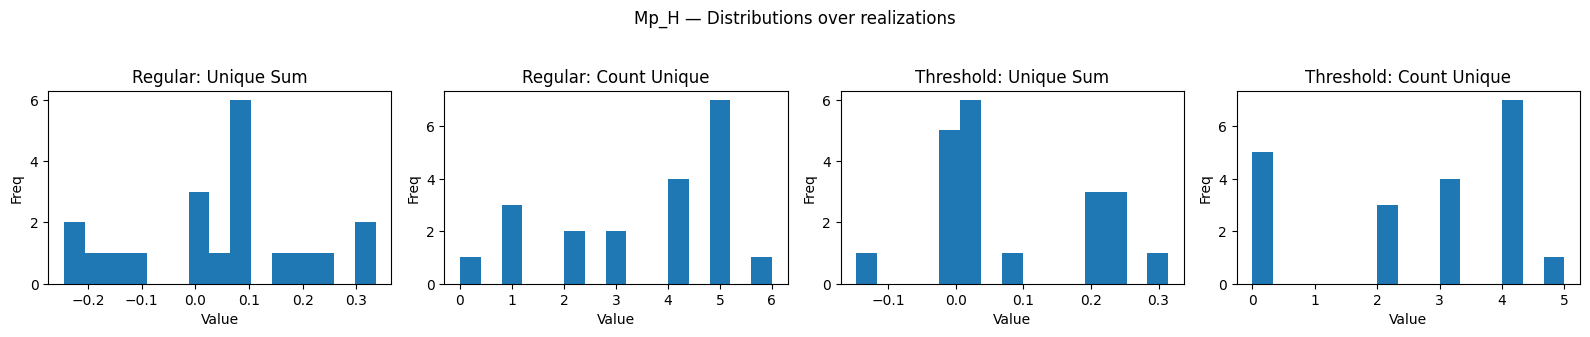

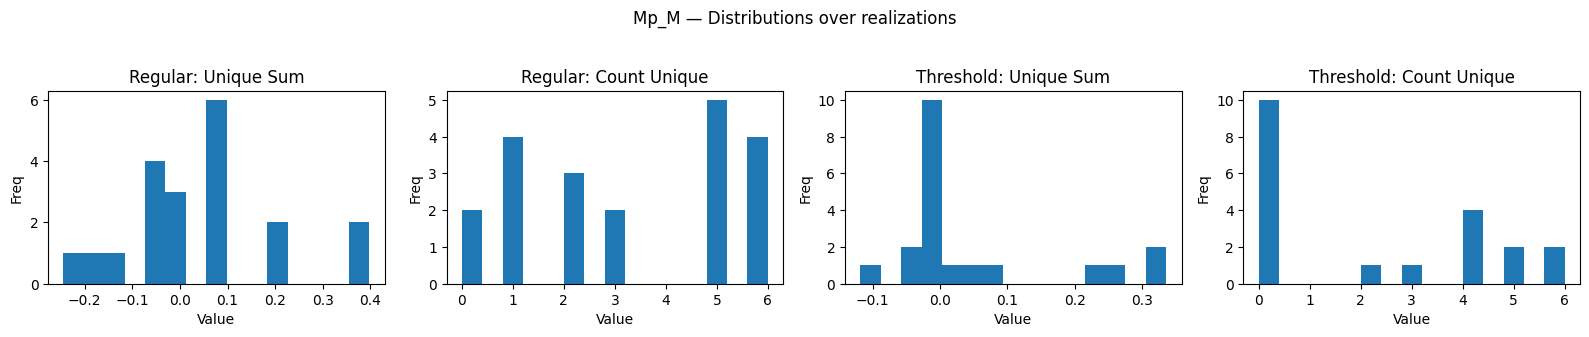

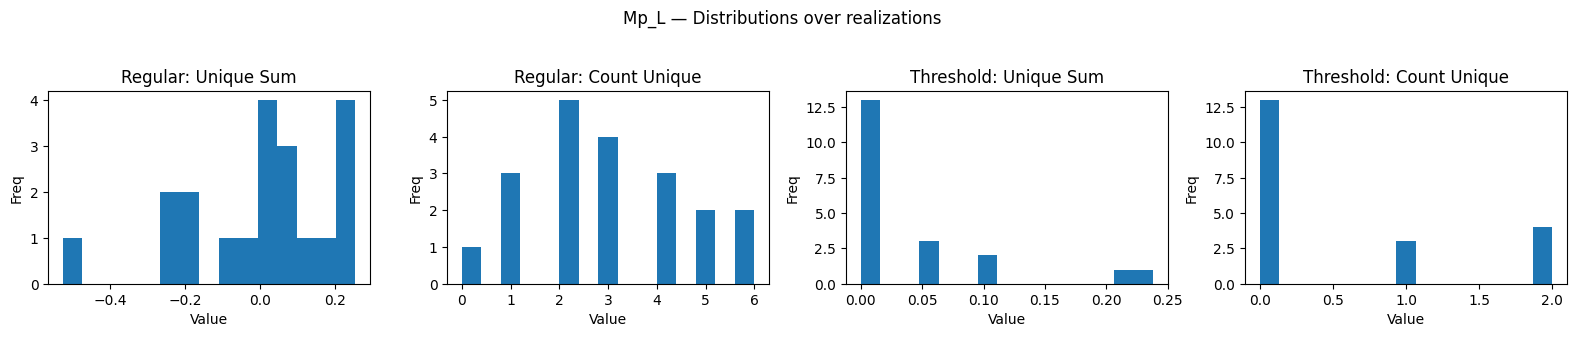

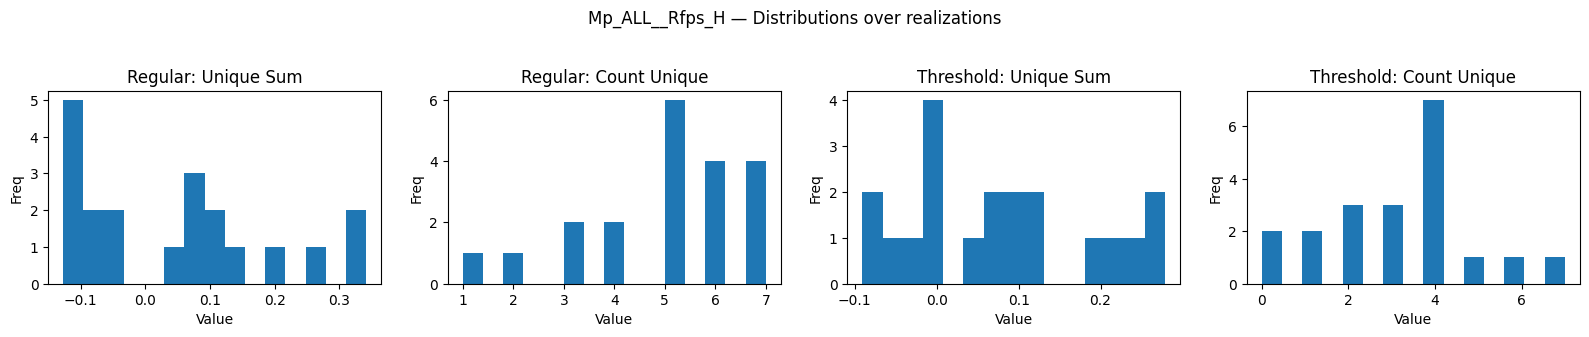

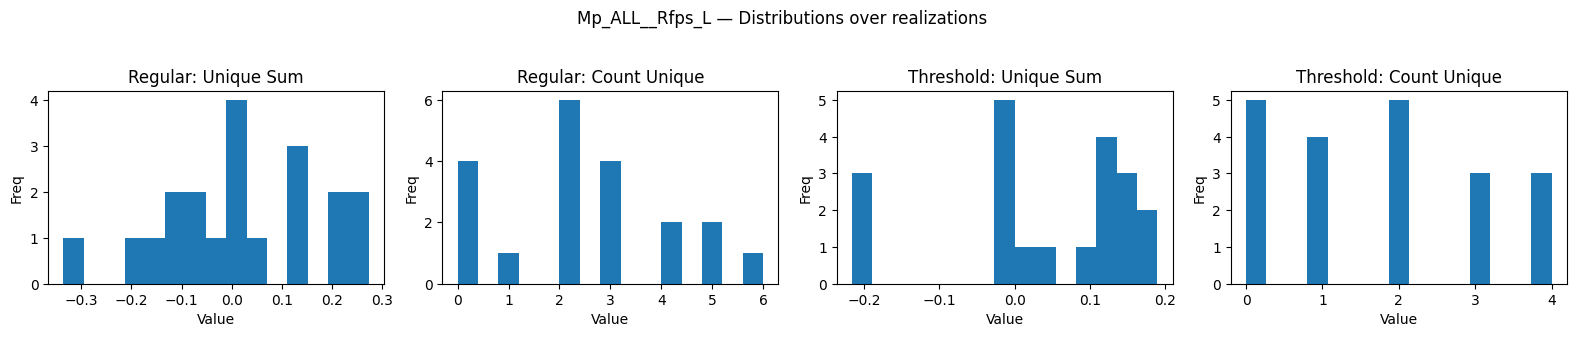

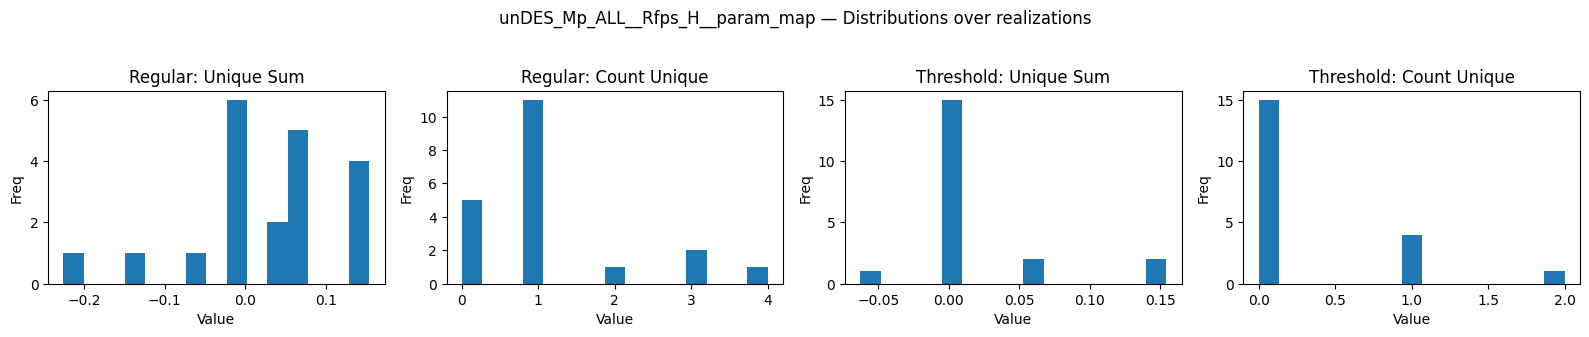

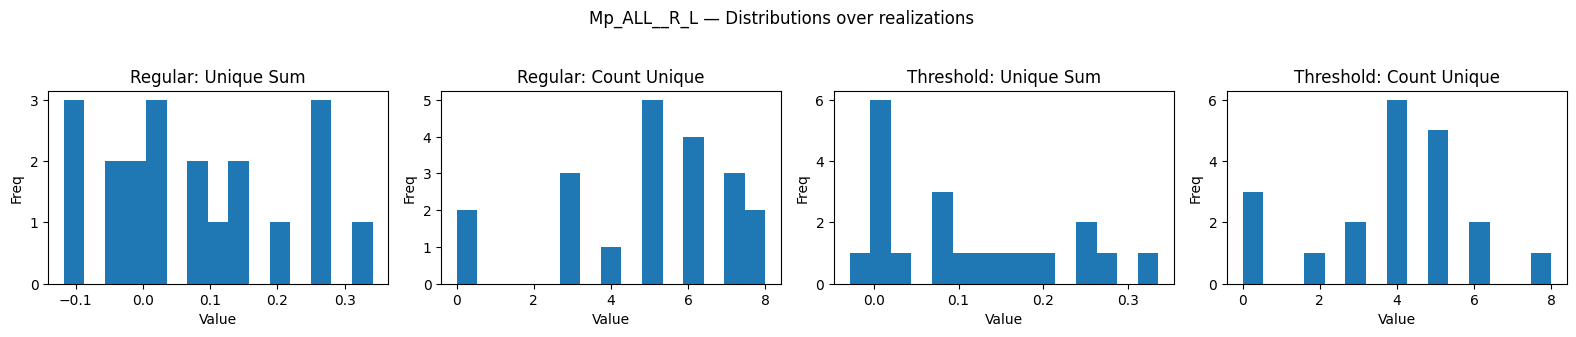

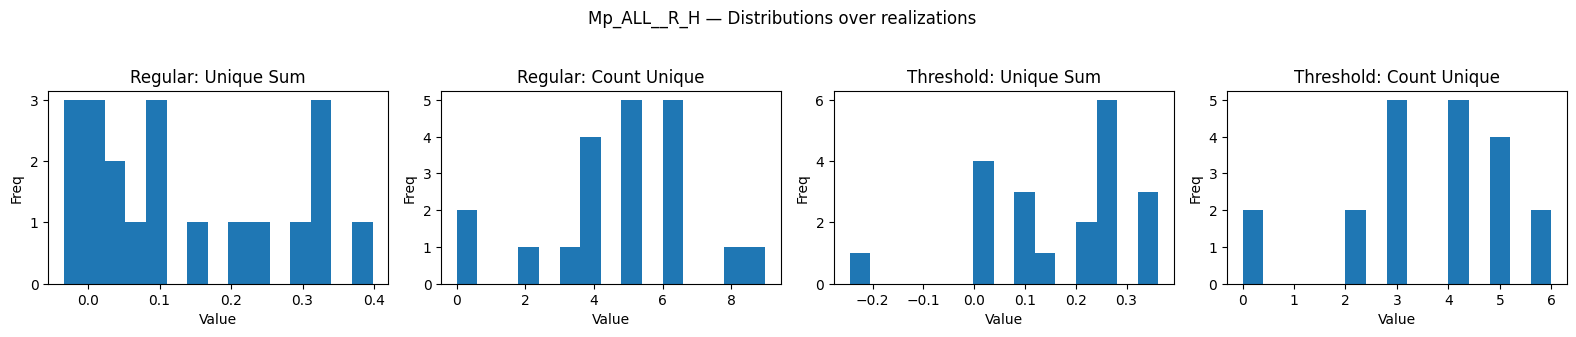

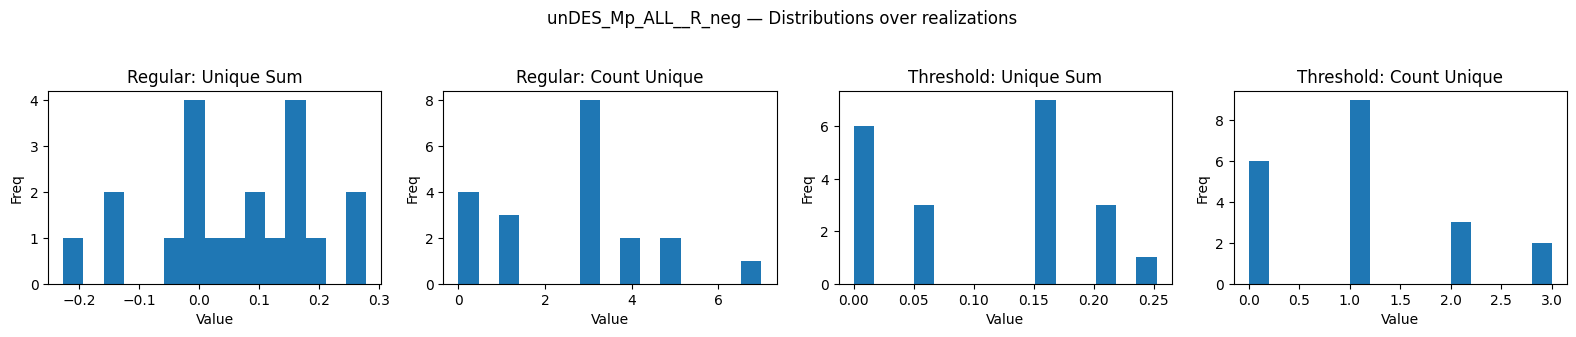

In [10]:
#####                                                models selection code   DIST PLOTS 

import matplotlib.pyplot as plt

METRICS = [
    "REG_UNIQUE_SUM",
    "REG_NUM_PREDS_UNIQUE",
    "THR_UNIQUE_SUM",
    "THR_NUM_PREDS_UNIQUE",
]

TITLES = {
    "REG_UNIQUE_SUM":        "Regular: Unique Sum",
    "REG_NUM_PREDS_UNIQUE":  "Regular: Count Unique",
    "THR_UNIQUE_SUM":        "Threshold: Unique Sum",
    "THR_NUM_PREDS_UNIQUE":  "Threshold: Count Unique",
}

for model_key, metric_dict in ALL_models_results_across_realizations.items():
    fig, axes = plt.subplots(1, 4, figsize=(16, 3.5))
    fig.suptitle(f"{model_key} — Distributions over realizations", fontsize=12)

    for idx, metric in enumerate(METRICS):
        ax = axes[idx]
        vals = metric_dict.get(metric, [])
        if vals:
            ax.hist(vals, bins=15)
            ax.set_xlabel("Value")
            ax.set_ylabel("Freq")
        else:
            ax.text(0.5, 0.5, "No data", ha="center", va="center", transform=ax.transAxes)
            ax.set_xticks([]); ax.set_yticks([])

        ax.set_title(TITLES.get(metric, metric))

    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


In [11]:
dd = dict(ALL_models_results_across_realizations)



#### print sum of all vals reg and thresh for unique sum
for k, v in dd.items():

    try:    
        REG_UNIQUE_ALL_flat = [item for sublist in v["REG_UNIQUE_ALL"] for item in sublist]
        THRESH_UNIQUE_ALL_flat = [item for sublist in v["THR_UNIQUE_ALL"] for item in sublist]

    except Exception as e:
        print(f"Error processing {k}: {e}")


    print(f"{k}")
    
    print(f"  REG_UNIQUE_SUM: " , sum(set(REG_UNIQUE_ALL_flat)))
    print(f"  REG_NUM_PREDS_UNIQUE: " , len(set(REG_UNIQUE_ALL_flat)))
    REG_RETURN_PER_TRADE = sum(set(REG_UNIQUE_ALL_flat)) / len(set(REG_UNIQUE_ALL_flat)) if len(set(REG_UNIQUE_ALL_flat)) > 0 else 0
    print( " REG_RETURN_PER_TRADE: " , REG_RETURN_PER_TRADE)

    print(f"  THRESH_UNIQUE_SUM: " , sum(set(THRESH_UNIQUE_ALL_flat)))
    print(f"  THR_NUM_PREDS_UNIQUE: " , len(set(THRESH_UNIQUE_ALL_flat)))
    REG_RETURN_PER_TRADE_THRESH = sum(set(THRESH_UNIQUE_ALL_flat)) / len(set(THRESH_UNIQUE_ALL_flat)) if len(set(THRESH_UNIQUE_ALL_flat)) > 0 else 0
    print( " REG_RETURN_PER_TRADE_THRESH: " , REG_RETURN_PER_TRADE_THRESH)




    if (REG_RETURN_PER_TRADE_THRESH == REG_RETURN_PER_TRADE) :
            print(" --> SAME RETURN PER SHARE")
    elif (REG_RETURN_PER_TRADE_THRESH > REG_RETURN_PER_TRADE) :
            print(" --> THRESHOLDING IMPROVED RETURN PER SHARE")

    else:
            print(" --> DID NOT IMPROVE RETURN PER SHARE")



Mp_H
  REG_UNIQUE_SUM:  0.02759652893803044
  REG_NUM_PREDS_UNIQUE:  7
 REG_RETURN_PER_TRADE:  0.003942361276861491
  THRESH_UNIQUE_SUM:  0.15319120067922942
  THR_NUM_PREDS_UNIQUE:  6
 REG_RETURN_PER_TRADE_THRESH:  0.02553186677987157
 --> THRESHOLDING IMPROVED RETURN PER SHARE
Mp_M
  REG_UNIQUE_SUM:  -0.028829803350370664
  REG_NUM_PREDS_UNIQUE:  8
 REG_RETURN_PER_TRADE:  -0.003603725418796333
  THRESH_UNIQUE_SUM:  0.02759652893803044
  THR_NUM_PREDS_UNIQUE:  7
 REG_RETURN_PER_TRADE_THRESH:  0.003942361276861491
 --> THRESHOLDING IMPROVED RETURN PER SHARE
Mp_L
  REG_UNIQUE_SUM:  -0.2040785065749453
  REG_NUM_PREDS_UNIQUE:  11
 REG_RETURN_PER_TRADE:  -0.01855259150681321
  THRESH_UNIQUE_SUM:  0.29138708109384137
  THR_NUM_PREDS_UNIQUE:  5
 REG_RETURN_PER_TRADE_THRESH:  0.05827741621876827
 --> THRESHOLDING IMPROVED RETURN PER SHARE
Mp_ALL__Rfps_H
  REG_UNIQUE_SUM:  -0.07346131542152678
  REG_NUM_PREDS_UNIQUE:  9
 REG_RETURN_PER_TRADE:  -0.008162368380169642
  THRESH_UNIQUE_SUM:  -0.02

In [12]:


######################################                                                seeds AND models selection code 


number_realizations_outer = 20  # number of realizations to average over for each model

ALL_models_results_across_realizations = defaultdict(lambda: defaultdict(list))

#### {model_key: {metric: [values across realizations]} , model_key2: {...} , ...}


for i in range(number_realizations_outer):

    Sp_H__param_map_models = select_models_by_criteria(results_dist_disc, **Sp_H__param_map)
    Sp_M__param_map_models = select_models_by_criteria(results_dist_disc, **Sp_M__param_map)
    Sp_L__param_map_models = select_models_by_criteria(results_dist_disc, **Sp_L__param_map)

    TH_Sp_ALL__Hb_0fp1tp__param_map_models = select_models_by_criteria(results_dist_disc, **TH_Sp_ALL__Hb_0fp1tp__param_map)
    TH_Sp_ALL__Hb_1fp1tp__param_map_models = select_models_by_criteria(results_dist_disc, **TH_Sp_ALL__Hb_1fp1tp__param_map)
    TH_Sp_ALL__Hb_tp_minus_fp__param_map_models = select_models_by_criteria(results_dist_disc, **TH_Sp_ALL__Hb_tp_minus_fp__param_map)



    # models_res_names_dict = {
    #     "Sp_H": Sp_H__param_map_models,
    #     "Sp_M": Sp_M__param_map_models,
    #     "Sp_L": Sp_L__param_map_models,


    #     "TH_Sp_ALL__Hb_0fp1tp": TH_Sp_ALL__Hb_0fp1tp__param_map_models,
    #     "TH_Sp_ALL__Hb_1fp1tp": TH_Sp_ALL__Hb_1fp1tp__param_map_models,
    #     "TH_Sp_ALL__Hb_tp_minus_fp": TH_Sp_ALL__Hb_tp_minus_fp__param_map_models,

    #     "TH_Mp_H__Sp_ALL__Hb_tp_minus_fp": TH_Mp_H__Sp_ALL__Hb_tp_minus_fp__param_map_models
    # }


    # for k , selected_models in models_res_names_dict.items():
    #    print(f"Models Selected {k}: {len(selected_models)}")
    #    total_seeds = sum(len(model["selected_seeds"]) for model in selected_models)
    #    print(f"Total seeds selected {k}: {total_seeds}")
    #    print("-" * 5)


    #### collect raw V and T set data for the selected models
    Sp_H__data_V_T_rawData = collect_V_T_set_FULLraw_data(Sp_H__param_map_models, results_dist_disc, results_dist_disc_Tset_same_seeds_organized)
    Sp_M__data_V_T_rawData = collect_V_T_set_FULLraw_data(Sp_M__param_map_models, results_dist_disc, results_dist_disc_Tset_same_seeds_organized)
    Sp_L__data_V_T_rawData = collect_V_T_set_FULLraw_data(Sp_L__param_map_models, results_dist_disc, results_dist_disc_Tset_same_seeds_organized)

    TH_Sp_ALL__Hb_0fp1tp__data_V_T_rawData = collect_V_T_set_FULLraw_data(TH_Sp_ALL__Hb_0fp1tp__param_map_models, results_dist_disc, results_dist_disc_Tset_same_seeds_organized)
    TH_Sp_ALL__Hb_1fp1tp__data_V_T_rawData = collect_V_T_set_FULLraw_data(TH_Sp_ALL__Hb_1fp1tp__param_map_models, results_dist_disc, results_dist_disc_Tset_same_seeds_organized)
    TH_Sp_ALL__Hb_tp_minus_fp__data_V_T_rawData = collect_V_T_set_FULLraw_data(TH_Sp_ALL__Hb_tp_minus_fp__param_map_models, results_dist_disc, results_dist_disc_Tset_same_seeds_organized)

    #### collect raw V and T set data for the selected models

    model_AND_seed_based_selection_maps_raw_V_T_data = {
        "Sp_H": Sp_H__data_V_T_rawData,
        "Sp_M": Sp_M__data_V_T_rawData,   
        "Sp_L": Sp_L__data_V_T_rawData,

        "TH_Sp_ALL__Hb_0fp1tp": TH_Sp_ALL__Hb_0fp1tp__data_V_T_rawData,
        "TH_Sp_ALL__Hb_1fp1tp": TH_Sp_ALL__Hb_1fp1tp__data_V_T_rawData,
        "TH_Sp_ALL__Hb_tp_minus_fp": TH_Sp_ALL__Hb_tp_minus_fp__data_V_T_rawData,


    }

    # with open('model_AND_seed_based_selection_maps_raw_V_T_data.pkl', 'wb') as f:
    #     pickle.dump(model_AND_seed_based_selection_maps_raw_V_T_data_Seed_and_Model, f)


    # dict_keys(['Sp_H', 'Sp_M', 'Sp_L', 'TH_Sp_ALL__Hb_0fp1tp', 'TH_Sp_ALL__Hb_1fp1tp', 
    #       'TH_Sp_ALL__Hb_tp_minus_fp', 'TH_Mp_H__Sp_ALL__Hb_tp_minus_fp'])
    models_AND_seeds_data_V_T = {
        "Sp_H" : {"V_set_data" : model_AND_seed_based_selection_maps_raw_V_T_data["Sp_H"]["V_set_data"] , "T_set_data" : model_AND_seed_based_selection_maps_raw_V_T_data["Sp_H"]["T_set_data"]} ,
        "Sp_M" : {"V_set_data" : model_AND_seed_based_selection_maps_raw_V_T_data["Sp_M"]["V_set_data"] , "T_set_data" : model_AND_seed_based_selection_maps_raw_V_T_data["Sp_M"]["T_set_data"]} ,
        "Sp_L" : {"V_set_data" : model_AND_seed_based_selection_maps_raw_V_T_data["Sp_L"]["V_set_data"] , "T_set_data" : model_AND_seed_based_selection_maps_raw_V_T_data["Sp_L"]["T_set_data"]} ,
        ###
        "TH_Sp_ALL__Hb_0fp1tp" : {"V_set_data" : model_AND_seed_based_selection_maps_raw_V_T_data["TH_Sp_ALL__Hb_0fp1tp"]["V_set_data"] , "T_set_data" : model_AND_seed_based_selection_maps_raw_V_T_data["TH_Sp_ALL__Hb_0fp1tp"]["T_set_data"]} ,
        "TH_Sp_ALL__Hb_1fp1tp" : {"V_set_data" : model_AND_seed_based_selection_maps_raw_V_T_data["TH_Sp_ALL__Hb_1fp1tp"]["V_set_data"] , "T_set_data" : model_AND_seed_based_selection_maps_raw_V_T_data["TH_Sp_ALL__Hb_1fp1tp"]["T_set_data"]} ,
        "TH_Sp_ALL__Hb_tp_minus_fp" : {"V_set_data" : model_AND_seed_based_selection_maps_raw_V_T_data["TH_Sp_ALL__Hb_tp_minus_fp"]["V_set_data"] , "T_set_data" : model_AND_seed_based_selection_maps_raw_V_T_data["TH_Sp_ALL__Hb_tp_minus_fp"]["T_set_data"]} ,
        ###
    }

    model_keys = list(models_AND_seeds_data_V_T.keys())

    for k in model_keys:
        V_set = models_AND_seeds_data_V_T[k]["V_set_data"]
        T_set = models_AND_seeds_data_V_T[k]["T_set_data"]
        out = process_and_RETURN_analytics(V_set, T_set, do_print=False)
        
        ALL_models_results_across_realizations[k]["REG_UNIQUE_ALL"].append(out["all_realizations_unique_actuals_ups_regular_UNIQUE"])
        ALL_models_results_across_realizations[k]["REG_UNIQUE_SUM"].append(out["all_realizations_unique_actuals_ups_regular_UNIQUE_SUM"])
        ALL_models_results_across_realizations[k]["REG_NUM_PREDS_UNIQUE"].append(out["LEN_all_realizations_unique_actuals_ups_regular_UNIQUE"])

        
        
        ALL_models_results_across_realizations[k]["THR_UNIQUE_ALL"].append(out["all_realizations_unique_actuals_ups_threshold_UNIQUE"])
        ALL_models_results_across_realizations[k]["THR_UNIQUE_SUM"].append(out["all_realizations_unique_actuals_ups_threshold_UNIQUE_SUM"])
        ALL_models_results_across_realizations[k]["THR_NUM_PREDS_UNIQUE"].append(out["LEN_all_realizations_unique_actuals_ups_threshold_UNIQUE"])



with open('/Users/cs/Desktop/LSTM_ETF_V2/Model Performance Data HOD 21_01 - 22_12/ALL_models_results_across_realization_2.pkl', 'wb') as f:
    pickle.dump(dict(ALL_models_results_across_realizations), f)




[use] pair_2_neg1_1: 4 ensembles of size 2 for 'T'
[use] pair_2_neg1_1: 4 ensembles of size 2 for 'T'
[use] pair_2_neg1_1: 4 ensembles of size 2 for 'T'
[use] pair_2_neg1_1: 4 ensembles of size 2 for 'T'
[use] pair_2_neg1_1: 4 ensembles of size 2 for 'T'
[use] pair_2_neg1_1: 4 ensembles of size 2 for 'T'
[use] pair_2_neg1_1: 4 ensembles of size 2 for 'T'
[use] pair_2_neg1_1: 4 ensembles of size 2 for 'T'
[use] pair_2_neg1_1: 4 ensembles of size 2 for 'T'
[use] pair_2_neg1_1: 4 ensembles of size 2 for 'T'
[use] pair_2_neg1_1: 4 ensembles of size 2 for 'T'
[use] pair_2_neg1_1: 4 ensembles of size 2 for 'T'
[use] pair_2_neg1_1: 4 ensembles of size 2 for 'T'
[use] pair_2_neg1_1: 4 ensembles of size 2 for 'T'
[use] pair_2_neg1_1: 4 ensembles of size 2 for 'T'
[use] pair_2_neg1_1: 4 ensembles of size 2 for 'T'
[use] pair_2_neg1_1: 4 ensembles of size 2 for 'T'
[use] pair_2_neg1_1: 4 ensembles of size 2 for 'T'
[use] pair_2_neg1_1: 4 ensembles of size 2 for 'T'
[use] pair_2_neg1_1: 4 ensemble

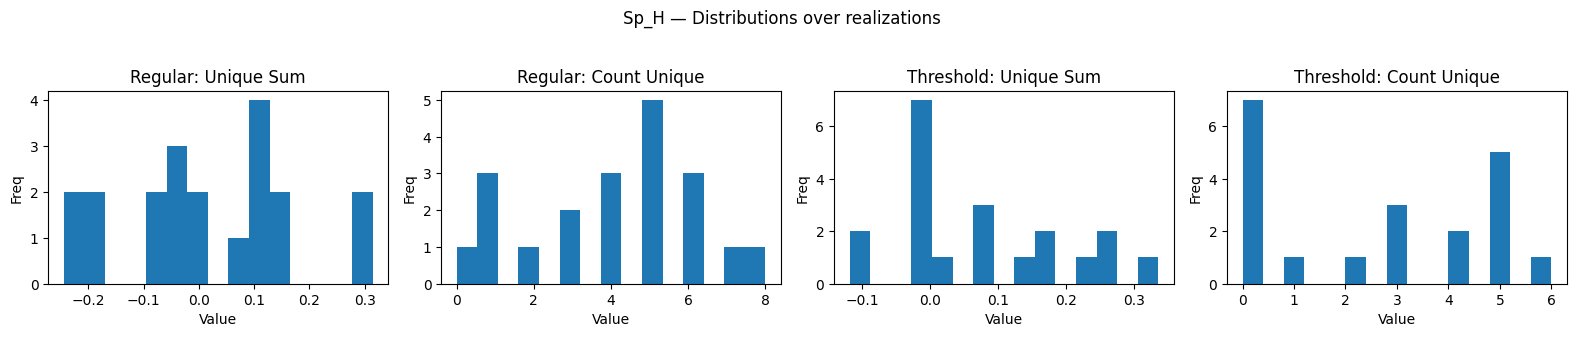

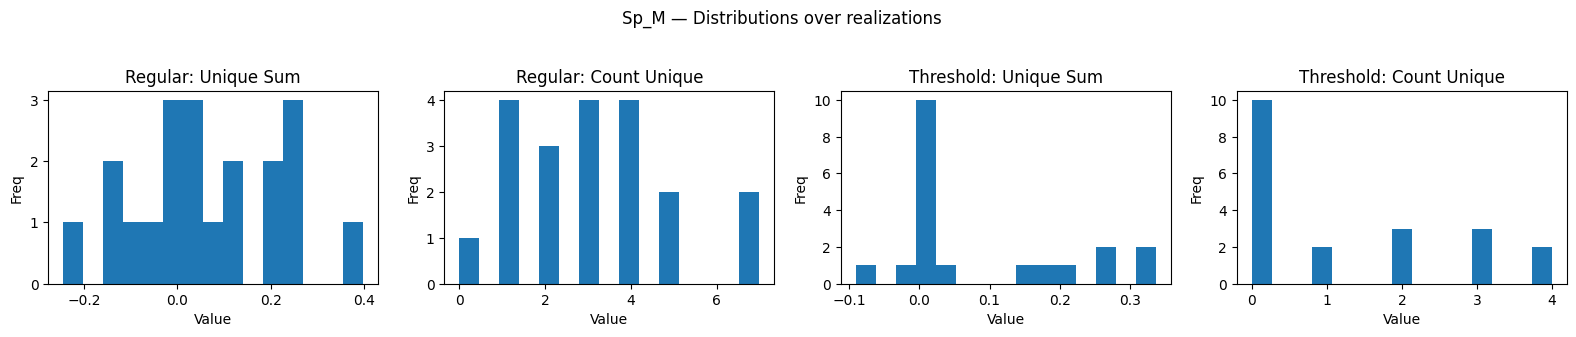

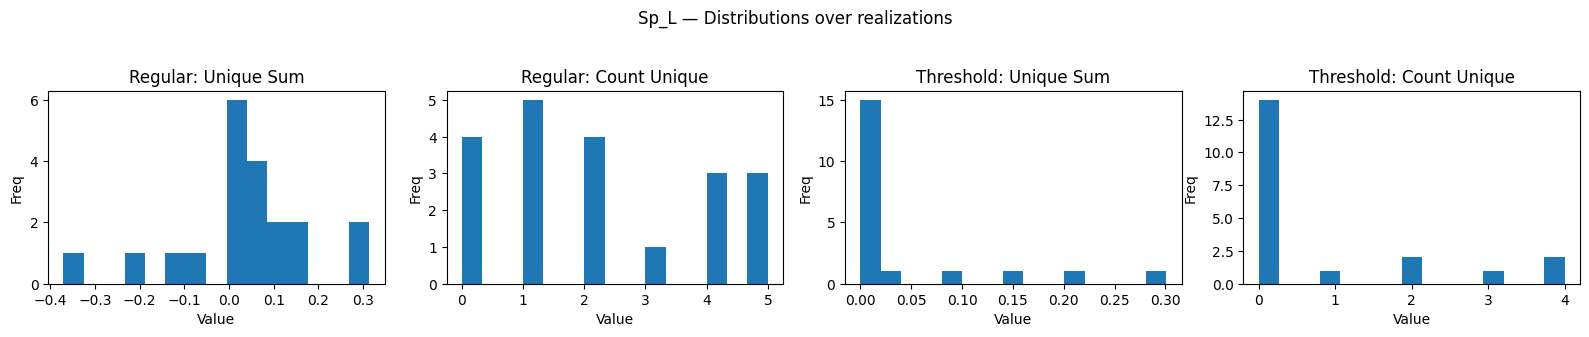

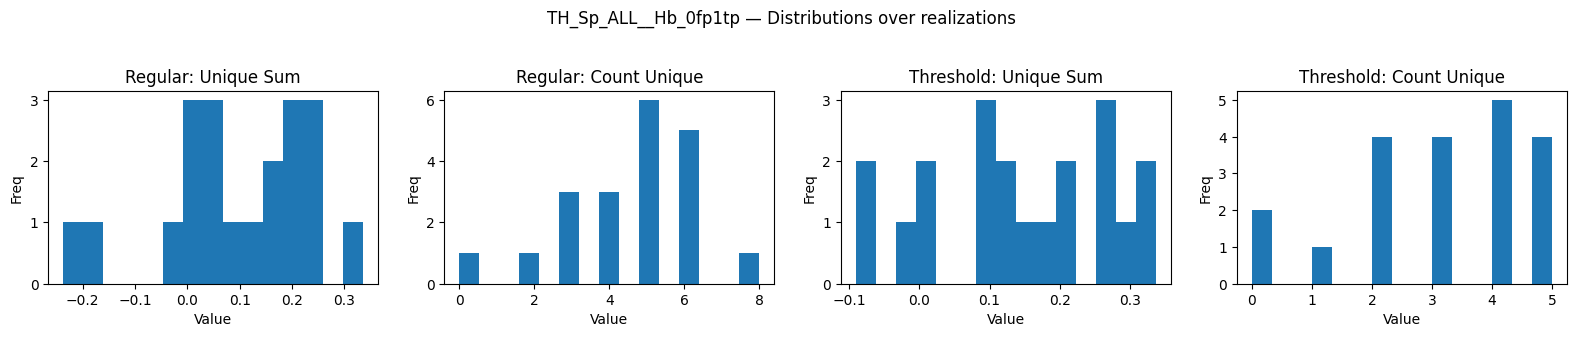

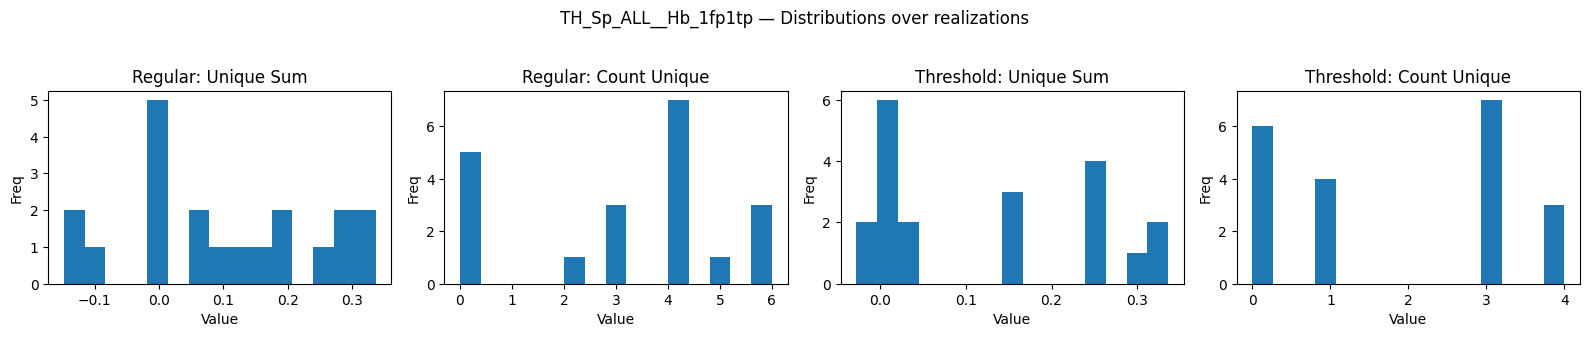

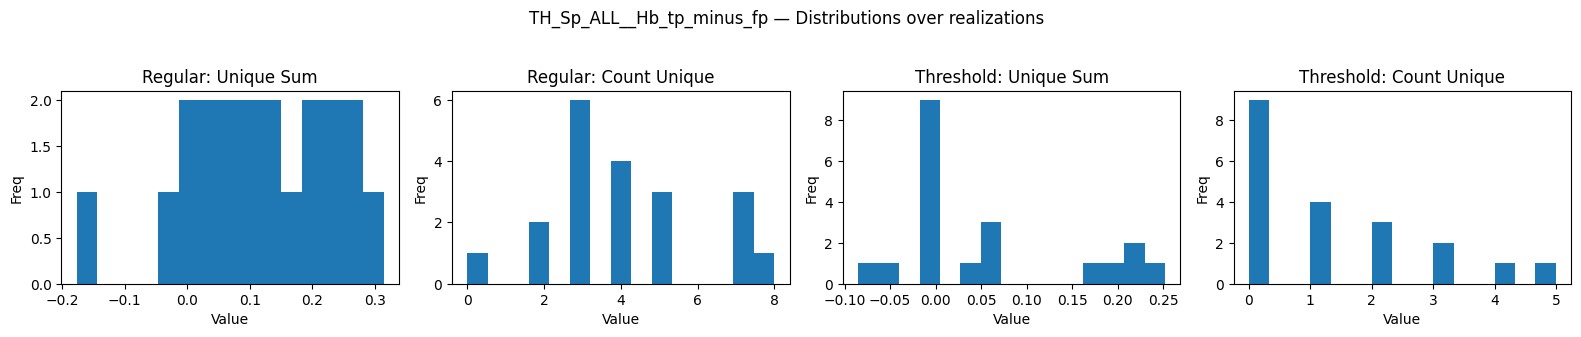

In [13]:
#####                                                models selection code   DIST PLOTS 

import matplotlib.pyplot as plt

METRICS = [
    "REG_UNIQUE_SUM",
    "REG_NUM_PREDS_UNIQUE",
    "THR_UNIQUE_SUM",
    "THR_NUM_PREDS_UNIQUE",
]

TITLES = {
    "REG_UNIQUE_SUM":        "Regular: Unique Sum",
    "REG_NUM_PREDS_UNIQUE":  "Regular: Count Unique",
    "THR_UNIQUE_SUM":        "Threshold: Unique Sum",
    "THR_NUM_PREDS_UNIQUE":  "Threshold: Count Unique",
}

for model_key, metric_dict in ALL_models_results_across_realizations.items():
    fig, axes = plt.subplots(1, 4, figsize=(16, 3.5))
    fig.suptitle(f"{model_key} — Distributions over realizations", fontsize=12)

    for idx, metric in enumerate(METRICS):
        ax = axes[idx]
        vals = metric_dict.get(metric, [])
        if vals:
            ax.hist(vals, bins=15)
            ax.set_xlabel("Value")
            ax.set_ylabel("Freq")
        else:
            ax.text(0.5, 0.5, "No data", ha="center", va="center", transform=ax.transAxes)
            ax.set_xticks([]); ax.set_yticks([])

        ax.set_title(TITLES.get(metric, metric))

    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


In [14]:
dd = dict(ALL_models_results_across_realizations)


#### print sum of all vals reg and thresh for unique sum
for k, v in dd.items():
    REG_UNIQUE_ALL_flat = [item for sublist in v["REG_UNIQUE_ALL"] for item in sublist]
    THRESH_UNIQUE_ALL_flat = [item for sublist in v["THR_UNIQUE_ALL"] for item in sublist]

    print(f"{k}")
    
    print(f"  REG_UNIQUE_SUM: " , sum(set(REG_UNIQUE_ALL_flat)))
    print(f"  REG_NUM_PREDS_UNIQUE: " , len(set(REG_UNIQUE_ALL_flat)))
    REG_RETURN_PER_TRADE = sum(set(REG_UNIQUE_ALL_flat)) / len(set(REG_UNIQUE_ALL_flat)) if len(set(REG_UNIQUE_ALL_flat)) > 0 else 0
    print( " REG_RETURN_PER_TRADE: " , REG_RETURN_PER_TRADE)

    print(f"  THRESH_UNIQUE_SUM: " , sum(set(THRESH_UNIQUE_ALL_flat)))
    print(f"  THR_NUM_PREDS_UNIQUE: " , len(set(THRESH_UNIQUE_ALL_flat)))
    REG_RETURN_PER_TRADE_THRESH = sum(set(THRESH_UNIQUE_ALL_flat)) / len(set(THRESH_UNIQUE_ALL_flat)) if len(set(THRESH_UNIQUE_ALL_flat)) > 0 else 0
    print( " REG_RETURN_PER_TRADE_THRESH: " , REG_RETURN_PER_TRADE_THRESH)



    if (REG_RETURN_PER_TRADE_THRESH == REG_RETURN_PER_TRADE) :
            print(" --> SAME RETURN PER SHARE")
    elif (REG_RETURN_PER_TRADE_THRESH > REG_RETURN_PER_TRADE) :
            print(" --> THRESHOLDING IMPROVED RETURN PER SHARE")

    else:
            print(" --> DID NOT IMPROVE RETURN PER SHARE")

Sp_H
  REG_UNIQUE_SUM:  -0.07346131542152678
  REG_NUM_PREDS_UNIQUE:  9
 REG_RETURN_PER_TRADE:  -0.008162368380169642
  THRESH_UNIQUE_SUM:  0.02759652893803044
  THR_NUM_PREDS_UNIQUE:  7
 REG_RETURN_PER_TRADE_THRESH:  0.003942361276861491
 --> THRESHOLDING IMPROVED RETURN PER SHARE
Sp_M
  REG_UNIQUE_SUM:  -0.07346131542152678
  REG_NUM_PREDS_UNIQUE:  9
 REG_RETURN_PER_TRADE:  -0.008162368380169642
  THRESH_UNIQUE_SUM:  0.15319120067922942
  THR_NUM_PREDS_UNIQUE:  6
 REG_RETURN_PER_TRADE_THRESH:  0.02553186677987157
 --> THRESHOLDING IMPROVED RETURN PER SHARE
Sp_L
  REG_UNIQUE_SUM:  0.02759652893803044
  REG_NUM_PREDS_UNIQUE:  7
 REG_RETURN_PER_TRADE:  0.003942361276861491
  THRESH_UNIQUE_SUM:  0.09120631056933959
  THR_NUM_PREDS_UNIQUE:  5
 REG_RETURN_PER_TRADE_THRESH:  0.018241262113867916
 --> THRESHOLDING IMPROVED RETURN PER SHARE
TH_Sp_ALL__Hb_0fp1tp
  REG_UNIQUE_SUM:  -0.028829803350370664
  REG_NUM_PREDS_UNIQUE:  8
 REG_RETURN_PER_TRADE:  -0.003603725418796333
  THRESH_UNIQUE_SUM

In [15]:
    ####                                   Model Selection (SEED filter only) ---- seed filter only to see if the dist discovery inc the prec 

Mp_H__Sp_H__param_map = {   
                             "mean_precision_range" : (60, 100),"max_zero_precision_seeds" : 70,"max_FP_severe_ratio_FPs" : None, "min_FP_severe_ratio_FPs" : None, "min_ratio_difference" : None, "max_ratio_difference" : None,
                             
                             "seed_precision_range" : (75, 100) , 
                             "mean_recall_up_range" : (0, 100), "seed_recall_range" : (0, 100),
                             "seed_min_TPminusFP_greaterEqual" : None , "max_seed_severe_FPs_high_bracket" : None , "min_seed_TPs_high_bracket" : None ,
                              "min_seeds_per_model" : 1,"max_models_to_return" : 90, "max_FP_severe_ratio_FPs_andTPs" : None, "min_FP_severe_ratio_FPs_andTPs" : None ,"random_seed" : None 

                               }

Mp_H__Sp_M__param_map = {   
                             "mean_precision_range" : (60, 100),"max_zero_precision_seeds" : 70, "max_FP_severe_ratio_FPs" : None, "min_FP_severe_ratio_FPs" : None,"min_ratio_difference" : None, "max_ratio_difference" : None,
                             
                             "seed_precision_range" : (40, 75) , 
                             "mean_recall_up_range" : (0, 100), "seed_recall_range" : (0, 100),
                             "seed_min_TPminusFP_greaterEqual" : None , "max_seed_severe_FPs_high_bracket" : None , 
                             "min_seed_TPs_high_bracket" : None ,
                              "min_seeds_per_model" : 1,"max_models_to_return" : 90, "max_FP_severe_ratio_FPs_andTPs" : None, "min_FP_severe_ratio_FPs_andTPs" : None ,"random_seed" : None 
                               }

Mp_H__Sp_L__param_map = {   
                             "mean_precision_range" : (60, 100),"max_zero_precision_seeds" : 70,"max_FP_severe_ratio_FPs" : None, "min_FP_severe_ratio_FPs" : None, "min_ratio_difference" : None, "max_ratio_difference" : None,

                             "seed_precision_range" : (1, 40) , 
                             "mean_recall_up_range" : (0, 100), "seed_recall_range" : (0, 100),
                             "seed_min_TPminusFP_greaterEqual" : None , "max_seed_severe_FPs_high_bracket" : None , 
                             "min_seed_TPs_high_bracket" : None , 
                              "min_seeds_per_model" : 1,"max_models_to_return" : 90, "max_FP_severe_ratio_FPs_andTPs" : None, "min_FP_severe_ratio_FPs_andTPs" : None ,"random_seed" : None 
                               }

####

Mp_H__TH_Sp_ALL__Hb_0fp1tp__param_map = {   
                             "mean_precision_range" : (60, 100),"max_zero_precision_seeds" : 70,
                             "max_FP_severe_ratio_FPs" : None, "min_FP_severe_ratio_FPs" : None,         
                             "min_ratio_difference" : None, "max_ratio_difference" : None,

                             "seed_precision_range" : (5, 100) , 
                             "seed_min_TPminusFP_greaterEqual" : None , 
                             "max_seed_severe_FPs_high_bracket" : 0 , #**
                             "min_seed_TPs_high_bracket" : 1 , #**
                             "mean_recall_up_range" : (0, 100), "seed_recall_range" : (0, 100),
                              "min_seeds_per_model" : 1,
                             "max_models_to_return" : 90, "max_FP_severe_ratio_FPs_andTPs" : None, 
                             "min_FP_severe_ratio_FPs_andTPs" : None ,"random_seed" : None 

                               }


####                                   Model Selection (SEED + MODEL Fileter)

TH_Mp_H__Sp_ALL__Hb_tp_minus_fp__param_map = {   
                             "mean_precision_range" : (60, 100),
                             "max_zero_precision_seeds" : 70,
                             "max_FP_severe_ratio_FPs" : None,
                             "min_FP_severe_ratio_FPs" : None,         
                             "min_ratio_difference" : None, 
                             "max_ratio_difference" : None,

                             "seed_precision_range" : (10, 100) , 
                             "seed_min_TPminusFP_greaterEqual" : 2 , 
                             "max_seed_severe_FPs_high_bracket" : None , 
                             "min_seed_TPs_high_bracket" : None ,

                             "mean_recall_up_range" : (0, 100), "seed_recall_range" : (0, 100),


                             "min_seeds_per_model" : 1,
                             "max_models_to_return" : 90,
                             "max_FP_severe_ratio_FPs_andTPs" : None, 
                             "min_FP_severe_ratio_FPs_andTPs" : None,

                             "random_seed" : None

                               }


Mp_H__Sp_H__param_map_models = select_models_by_criteria(results_dist_disc, **Mp_H__Sp_H__param_map)
Mp_H__Sp_M__param_map_models = select_models_by_criteria(results_dist_disc, **Mp_H__Sp_M__param_map)
Mp_H__Sp_L__param_map_models = select_models_by_criteria(results_dist_disc, **Mp_H__Sp_L__param_map)

Mp_H__TH_Sp_ALL__Hb_0fp1tp__param_map_models = select_models_by_criteria(results_dist_disc, **Mp_H__TH_Sp_ALL__Hb_0fp1tp__param_map)

TH_Mp_H__Sp_ALL__Hb_tp_minus_fp__param_map_models = select_models_by_criteria(results_dist_disc, **TH_Mp_H__Sp_ALL__Hb_tp_minus_fp__param_map)


models_res_names_dict = {
    "Mp_H__Sp_H": Mp_H__Sp_H__param_map_models,
    "Mp_H__Sp_M": Mp_H__Sp_M__param_map_models,
    "Mp_H__Sp_L": Mp_H__Sp_L__param_map_models,

    "Mp_H__TH_Sp_ALL__Hb_0fp1tp": Mp_H__TH_Sp_ALL__Hb_0fp1tp__param_map_models,

    "TH_Mp_H__Sp_ALL__Hb_tp_minus_fp": TH_Mp_H__Sp_ALL__Hb_tp_minus_fp__param_map_models
}


for k , selected_models in models_res_names_dict.items():
   print(f"Models Selected {k}: {len(selected_models)}")
   total_seeds = sum(len(model["selected_seeds"]) for model in selected_models)
   print(f"Total seeds selected {k}: {total_seeds}")
   print("-" * 5)


# #### collect raw V and T set data for the selected models
# Mp_H__Sp_H__data_V_T_rawData = collect_V_T_set_FULLraw_data(Mp_H__Sp_H__param_map_models, results_dist_disc, results_dist_disc_Tset_same_seeds_organized)
# Mp_H__Sp_M__data_V_T_rawData = collect_V_T_set_FULLraw_data(Mp_H__Sp_M__param_map_models, results_dist_disc, results_dist_disc_Tset_same_seeds_organized)
# Mp_H__Sp_L__data_V_T_rawData = collect_V_T_set_FULLraw_data(Mp_H__Sp_L__param_map_models, results_dist_disc, results_dist_disc_Tset_same_seeds_organized)

# Mp_H__TH_Sp_ALL__Hb_0fp1tp__data_V_T_rawData = collect_V_T_set_FULLraw_data(Mp_H__TH_Sp_ALL__Hb_0fp1tp__param_map_models, results_dist_disc, results_dist_disc_Tset_same_seeds_organized)


# Mp_H__TH_Mp_H__Sp_ALL__Hb_tp_minus_fp__data_V_T_rawData = collect_V_T_set_FULLraw_data(TH_Mp_H__Sp_ALL__Hb_tp_minus_fp__param_map_models, results_dist_disc, results_dist_disc_Tset_same_seeds_organized)
# #### collect raw V and T set data for the selected models

# V_2_MP_H__model_AND_seed_based_selection_maps_raw_V_T_data = {
#     "Sp_H": Mp_H__Sp_H__data_V_T_rawData,
#     "Sp_M": Mp_H__Sp_M__data_V_T_rawData,
#     "Sp_L": Mp_H__Sp_L__data_V_T_rawData,

#     "TH_Sp_ALL__Hb_0fp1tp": Mp_H__TH_Sp_ALL__Hb_0fp1tp__data_V_T_rawData,

#     "TH_Mp_H__Sp_ALL__Hb_tp_minus_fp": TH_Mp_H__Sp_ALL__Hb_tp_minus_fp__data_V_T_rawData
# }

# # with open('model_AND_seed_based_selection_maps_raw_V_T_data.pkl', 'wb') as f:
# #     pickle.dump(model_AND_seed_based_selection_maps_raw_V_T_data_Seed_and_Model, f)


Models Selected Mp_H__Sp_H: 12
Total seeds selected Mp_H__Sp_H: 264
-----
Models Selected Mp_H__Sp_M: 11
Total seeds selected Mp_H__Sp_M: 269
-----
Models Selected Mp_H__Sp_L: 9
Total seeds selected Mp_H__Sp_L: 77
-----
Models Selected Mp_H__TH_Sp_ALL__Hb_0fp1tp: 6
Total seeds selected Mp_H__TH_Sp_ALL__Hb_0fp1tp: 267
-----
Models Selected TH_Mp_H__Sp_ALL__Hb_tp_minus_fp: 6
Total seeds selected TH_Mp_H__Sp_ALL__Hb_tp_minus_fp: 73
-----


In [16]:


######################################                                                seeds AND models selection code 


number_realizations_outer = 20  # number of realizations to average over for each model

ALL_models_results_across_realizations = defaultdict(lambda: defaultdict(list))

#### {model_key: {metric: [values across realizations]} , model_key2: {...} , ...}


for i in range(number_realizations_outer):

    Mp_H__Sp_H__param_map_models = select_models_by_criteria(results_dist_disc, **Mp_H__Sp_H__param_map)
    Mp_H__Sp_M__param_map_models = select_models_by_criteria(results_dist_disc, **Mp_H__Sp_M__param_map)
    Mp_H__Sp_L__param_map_models = select_models_by_criteria(results_dist_disc, **Mp_H__Sp_L__param_map)

    Mp_H__TH_Sp_ALL__Hb_0fp1tp__param_map_models = select_models_by_criteria(results_dist_disc, **Mp_H__TH_Sp_ALL__Hb_0fp1tp__param_map)

    TH_Mp_H__Sp_ALL__Hb_tp_minus_fp__param_map_models = select_models_by_criteria(results_dist_disc, **TH_Mp_H__Sp_ALL__Hb_tp_minus_fp__param_map)


    # models_res_names_dict = {
    #     "Sp_H": Sp_H__param_map_models,
    #     "Sp_M": Sp_M__param_map_models,
    #     "Sp_L": Sp_L__param_map_models,


    #     "TH_Sp_ALL__Hb_0fp1tp": TH_Sp_ALL__Hb_0fp1tp__param_map_models,
    #     "TH_Sp_ALL__Hb_1fp1tp": TH_Sp_ALL__Hb_1fp1tp__param_map_models,
    #     "TH_Sp_ALL__Hb_tp_minus_fp": TH_Sp_ALL__Hb_tp_minus_fp__param_map_models,

    #     "TH_Mp_H__Sp_ALL__Hb_tp_minus_fp": TH_Mp_H__Sp_ALL__Hb_tp_minus_fp__param_map_models
    # }


    # for k , selected_models in models_res_names_dict.items():
    #    print(f"Models Selected {k}: {len(selected_models)}")
    #    total_seeds = sum(len(model["selected_seeds"]) for model in selected_models)
    #    print(f"Total seeds selected {k}: {total_seeds}")
    #    print("-" * 5)


    #### collect raw V and T set data for the selected models
    Mp_H__Sp_H__data_V_T_rawData = collect_V_T_set_FULLraw_data(Mp_H__Sp_H__param_map_models, results_dist_disc, results_dist_disc_Tset_same_seeds_organized)
    Mp_H__Sp_M__data_V_T_rawData = collect_V_T_set_FULLraw_data(Mp_H__Sp_M__param_map_models, results_dist_disc, results_dist_disc_Tset_same_seeds_organized)
    Mp_H__Sp_L__data_V_T_rawData = collect_V_T_set_FULLraw_data(Mp_H__Sp_L__param_map_models, results_dist_disc, results_dist_disc_Tset_same_seeds_organized)

    Mp_H__TH_Sp_ALL__Hb_0fp1tp__data_V_T_rawData = collect_V_T_set_FULLraw_data(Mp_H__TH_Sp_ALL__Hb_0fp1tp__param_map_models, results_dist_disc, results_dist_disc_Tset_same_seeds_organized)


    TH_Mp_H__Sp_ALL__Hb_tp_minus_fp__data_V_T_rawData = collect_V_T_set_FULLraw_data(TH_Mp_H__Sp_ALL__Hb_tp_minus_fp__param_map_models, results_dist_disc, results_dist_disc_Tset_same_seeds_organized)
    #### collect raw V and T set data for the selected models

    model_AND_seed_based_selection_maps_raw_V_T_data = {
        "Mp_H__Sp_H": Mp_H__Sp_H__data_V_T_rawData,
        "Mp_H__Sp_M": Mp_H__Sp_M__data_V_T_rawData,
        "Mp_H__Sp_L": Mp_H__Sp_L__data_V_T_rawData,

        "Mp_H__TH_Sp_ALL__Hb_0fp1tp": Mp_H__TH_Sp_ALL__Hb_0fp1tp__data_V_T_rawData,

        "TH_Mp_H__Sp_ALL__Hb_tp_minus_fp": TH_Mp_H__Sp_ALL__Hb_tp_minus_fp__data_V_T_rawData
    }

    # with open('model_AND_seed_based_selection_maps_raw_V_T_data.pkl', 'wb') as f:
    #     pickle.dump(model_AND_seed_based_selection_maps_raw_V_T_data_Seed_and_Model, f)


    # dict_keys(['Sp_H', 'Sp_M', 'Sp_L', 'TH_Sp_ALL__Hb_0fp1tp', 'TH_Sp_ALL__Hb_1fp1tp', 
    #       'TH_Sp_ALL__Hb_tp_minus_fp', 'TH_Mp_H__Sp_ALL__Hb_tp_minus_fp'])
    models_AND_seeds_data_V_T = {
        "Mp_H__Sp_H" : {"V_set_data" : model_AND_seed_based_selection_maps_raw_V_T_data["Mp_H__Sp_H"]["V_set_data"] , "T_set_data" : model_AND_seed_based_selection_maps_raw_V_T_data["Mp_H__Sp_H"]["T_set_data"]} ,
        "Mp_H__Sp_M" : {"V_set_data" : model_AND_seed_based_selection_maps_raw_V_T_data["Mp_H__Sp_M"]["V_set_data"] , "T_set_data" : model_AND_seed_based_selection_maps_raw_V_T_data["Mp_H__Sp_M"]["T_set_data"]} ,
        "Mp_H__Sp_L" : {"V_set_data" : model_AND_seed_based_selection_maps_raw_V_T_data["Mp_H__Sp_L"]["V_set_data"] , "T_set_data" : model_AND_seed_based_selection_maps_raw_V_T_data["Mp_H__Sp_L"]["T_set_data"]} ,
        ###
        "Mp_H__TH_Sp_ALL__Hb_0fp1tp" : {"V_set_data" : model_AND_seed_based_selection_maps_raw_V_T_data["Mp_H__TH_Sp_ALL__Hb_0fp1tp"]["V_set_data"] , "T_set_data" : model_AND_seed_based_selection_maps_raw_V_T_data["Mp_H__TH_Sp_ALL__Hb_0fp1tp"]["T_set_data"]} ,

        ###
        "TH_Mp_H__Sp_ALL__Hb_tp_minus_fp" : {"V_set_data" : model_AND_seed_based_selection_maps_raw_V_T_data["TH_Mp_H__Sp_ALL__Hb_tp_minus_fp"]["V_set_data"] , "T_set_data" : model_AND_seed_based_selection_maps_raw_V_T_data["TH_Mp_H__Sp_ALL__Hb_tp_minus_fp"]["T_set_data"]},
    }

    model_keys = list(models_AND_seeds_data_V_T.keys())

    for k in model_keys:
        V_set = models_AND_seeds_data_V_T[k]["V_set_data"]
        T_set = models_AND_seeds_data_V_T[k]["T_set_data"]
        out = process_and_RETURN_analytics(V_set, T_set, do_print=False)
        
        ALL_models_results_across_realizations[k]["REG_UNIQUE_ALL"].append(out["all_realizations_unique_actuals_ups_regular_UNIQUE"])
        ALL_models_results_across_realizations[k]["REG_UNIQUE_SUM"].append(out["all_realizations_unique_actuals_ups_regular_UNIQUE_SUM"])
        ALL_models_results_across_realizations[k]["REG_NUM_PREDS_UNIQUE"].append(out["LEN_all_realizations_unique_actuals_ups_regular_UNIQUE"])

        
        
        ALL_models_results_across_realizations[k]["THR_UNIQUE_ALL"].append(out["all_realizations_unique_actuals_ups_threshold_UNIQUE"])
        ALL_models_results_across_realizations[k]["THR_UNIQUE_SUM"].append(out["all_realizations_unique_actuals_ups_threshold_UNIQUE_SUM"])
        ALL_models_results_across_realizations[k]["THR_NUM_PREDS_UNIQUE"].append(out["LEN_all_realizations_unique_actuals_ups_threshold_UNIQUE"])



with open('/Users/cs/Desktop/LSTM_ETF_V2/Model Performance Data HOD 21_01 - 22_12/ALL_models_results_across_realization_3.pkl', 'wb') as f:
    pickle.dump(dict(ALL_models_results_across_realizations), f)




[use] pair_2_neg1_1: 4 ensembles of size 2 for 'T'
[use] pair_2_neg1_1: 4 ensembles of size 2 for 'T'
[use] pair_2_neg1_1: 4 ensembles of size 2 for 'T'
[use] pair_2_neg1_1: 4 ensembles of size 2 for 'T'
[use] pair_2_neg1_1: 4 ensembles of size 2 for 'T'
[use] pair_2_neg1_1: 4 ensembles of size 2 for 'T'
[use] pair_2_neg1_1: 4 ensembles of size 2 for 'T'
[use] pair_2_neg1_1: 4 ensembles of size 2 for 'T'
[use] pair_2_neg1_1: 4 ensembles of size 2 for 'T'
[use] pair_2_neg1_1: 4 ensembles of size 2 for 'T'
[use] pair_2_neg1_1: 4 ensembles of size 2 for 'T'
[use] pair_2_neg1_1: 4 ensembles of size 2 for 'T'
[use] pair_2_neg1_1: 4 ensembles of size 2 for 'T'
[use] pair_2_neg1_1: 4 ensembles of size 2 for 'T'
[use] pair_2_neg1_1: 4 ensembles of size 2 for 'T'
[use] pair_2_neg1_1: 4 ensembles of size 2 for 'T'
[use] pair_2_neg1_1: 4 ensembles of size 2 for 'T'
[use] pair_2_neg1_1: 4 ensembles of size 2 for 'T'
[use] pair_2_neg1_1: 4 ensembles of size 2 for 'T'
[use] pair_2_neg1_1: 4 ensemble

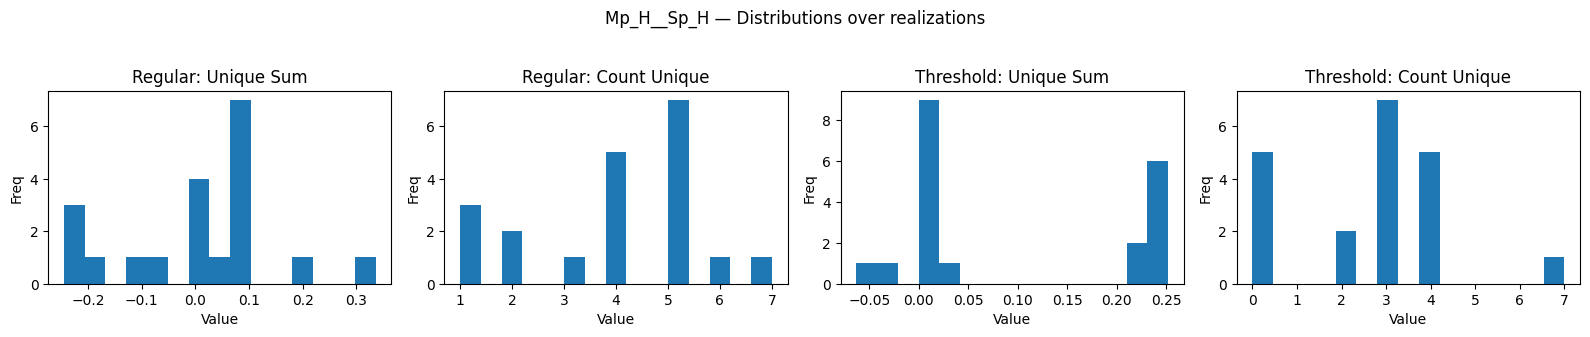

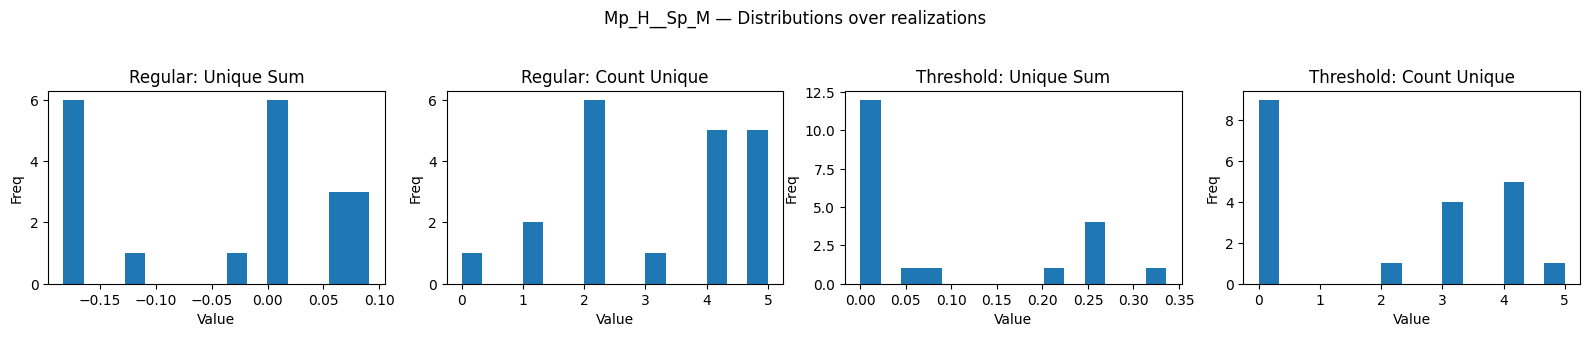

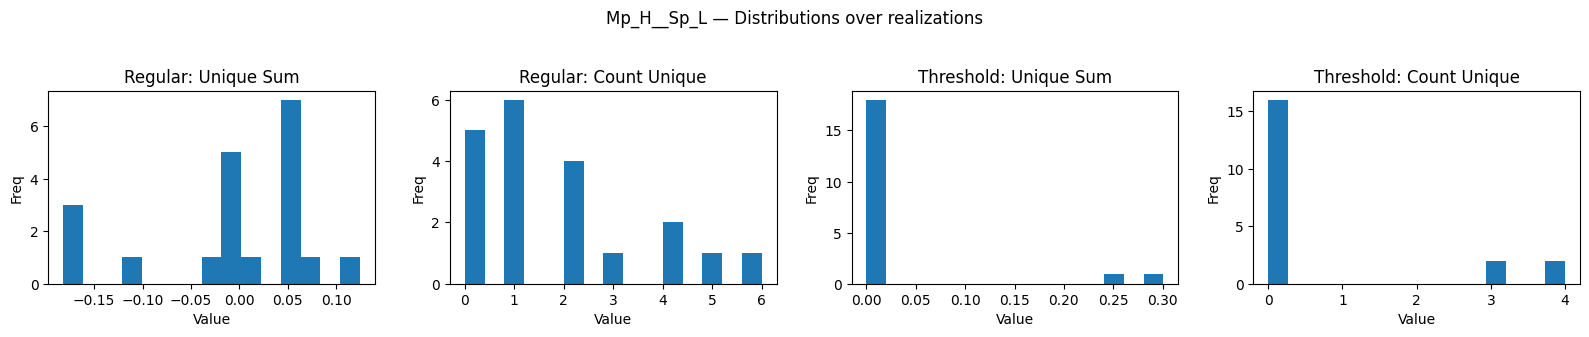

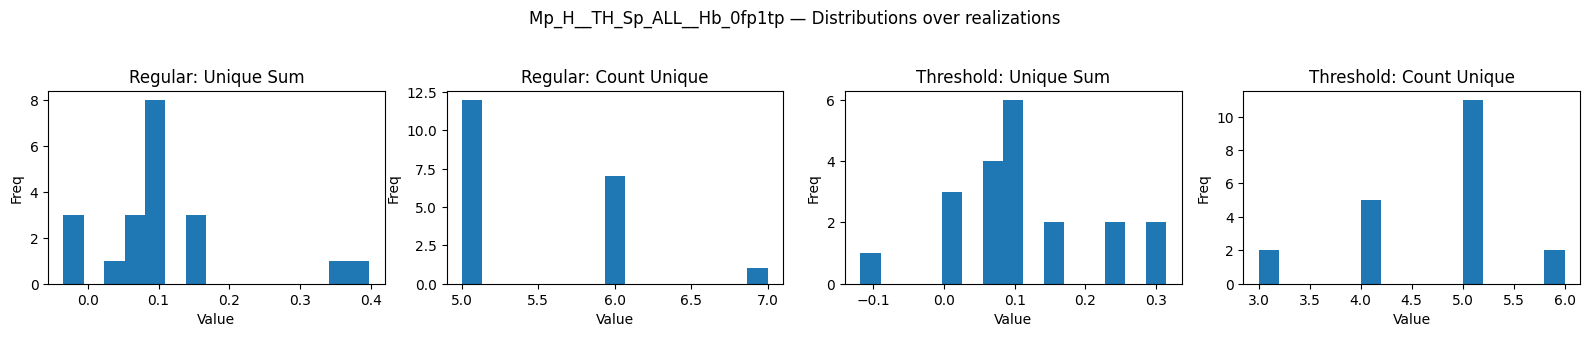

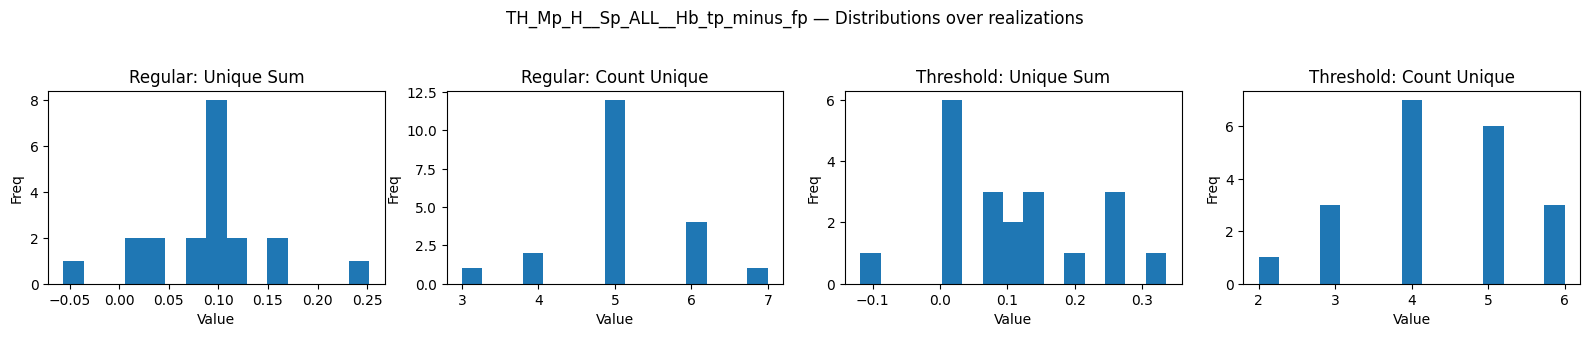

In [17]:
#####                                                models selection code   DIST PLOTS 

import matplotlib.pyplot as plt

METRICS = [
    "REG_UNIQUE_SUM",
    "REG_NUM_PREDS_UNIQUE",
    "THR_UNIQUE_SUM",
    "THR_NUM_PREDS_UNIQUE",
]

TITLES = {
    "REG_UNIQUE_SUM":        "Regular: Unique Sum",
    "REG_NUM_PREDS_UNIQUE":  "Regular: Count Unique",
    "THR_UNIQUE_SUM":        "Threshold: Unique Sum",
    "THR_NUM_PREDS_UNIQUE":  "Threshold: Count Unique",
}

for model_key, metric_dict in ALL_models_results_across_realizations.items():
    fig, axes = plt.subplots(1, 4, figsize=(16, 3.5))
    fig.suptitle(f"{model_key} — Distributions over realizations", fontsize=12)

    for idx, metric in enumerate(METRICS):
        ax = axes[idx]
        vals = metric_dict.get(metric, [])
        if vals:
            ax.hist(vals, bins=15)
            ax.set_xlabel("Value")
            ax.set_ylabel("Freq")
        else:
            ax.text(0.5, 0.5, "No data", ha="center", va="center", transform=ax.transAxes)
            ax.set_xticks([]); ax.set_yticks([])

        ax.set_title(TITLES.get(metric, metric))

    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


In [18]:
dd = dict(ALL_models_results_across_realizations)


#### print sum of all vals reg and thresh for unique sum
for k, v in dd.items():
    REG_UNIQUE_ALL_flat = [item for sublist in v["REG_UNIQUE_ALL"] for item in sublist]
    THRESH_UNIQUE_ALL_flat = [item for sublist in v["THR_UNIQUE_ALL"] for item in sublist]

    print(f"{k}")
    
    print(f"  REG_UNIQUE_SUM: " , sum(set(REG_UNIQUE_ALL_flat)))
    print(f"  REG_NUM_PREDS_UNIQUE: " , len(set(REG_UNIQUE_ALL_flat)))
    REG_RETURN_PER_TRADE = sum(set(REG_UNIQUE_ALL_flat)) / len(set(REG_UNIQUE_ALL_flat)) if len(set(REG_UNIQUE_ALL_flat)) > 0 else 0
    print( " REG_RETURN_PER_TRADE: " , REG_RETURN_PER_TRADE)

    print(f"  THRESH_UNIQUE_SUM: " , sum(set(THRESH_UNIQUE_ALL_flat)))
#     print(set(THRESH_UNIQUE_ALL_flat))
    print(f"  THR_NUM_PREDS_UNIQUE: " , len(set(THRESH_UNIQUE_ALL_flat)))
    REG_RETURN_PER_TRADE_THRESH = sum(set(THRESH_UNIQUE_ALL_flat)) / len(set(THRESH_UNIQUE_ALL_flat)) if len(set(THRESH_UNIQUE_ALL_flat)) > 0 else 0
    print( " REG_RETURN_PER_TRADE_THRESH: " , REG_RETURN_PER_TRADE_THRESH)


    if (REG_RETURN_PER_TRADE_THRESH == REG_RETURN_PER_TRADE) :
            print(" --> SAME RETURN PER SHARE")
    elif (REG_RETURN_PER_TRADE_THRESH > REG_RETURN_PER_TRADE) :
            print(" --> THRESHOLDING IMPROVED RETURN PER SHARE")

    else:
            print(" --> DID NOT IMPROVE RETURN PER SHARE")

Mp_H__Sp_H
  REG_UNIQUE_SUM:  0.02759652893803044
  REG_NUM_PREDS_UNIQUE:  7
 REG_RETURN_PER_TRADE:  0.003942361276861491
  THRESH_UNIQUE_SUM:  0.02759652893803044
  THR_NUM_PREDS_UNIQUE:  7
 REG_RETURN_PER_TRADE_THRESH:  0.003942361276861491
 --> SAME RETURN PER SHARE
Mp_H__Sp_M
  REG_UNIQUE_SUM:  0.02759652893803044
  REG_NUM_PREDS_UNIQUE:  7
 REG_RETURN_PER_TRADE:  0.003942361276861491
  THRESH_UNIQUE_SUM:  0.15319120067922942
  THR_NUM_PREDS_UNIQUE:  6
 REG_RETURN_PER_TRADE_THRESH:  0.02553186677987157
 --> THRESHOLDING IMPROVED RETURN PER SHARE
Mp_H__Sp_L
  REG_UNIQUE_SUM:  0.02759652893803044
  REG_NUM_PREDS_UNIQUE:  7
 REG_RETURN_PER_TRADE:  0.003942361276861491
  THRESH_UNIQUE_SUM:  0.09120631056933959
  THR_NUM_PREDS_UNIQUE:  5
 REG_RETURN_PER_TRADE_THRESH:  0.018241262113867916
 --> THRESHOLDING IMPROVED RETURN PER SHARE
Mp_H__TH_Sp_ALL__Hb_0fp1tp
  REG_UNIQUE_SUM:  -0.01703498313312568
  REG_NUM_PREDS_UNIQUE:  8
 REG_RETURN_PER_TRADE:  -0.00212937289164071
  THRESH_UNIQUE_SU

In [19]:

####                                   Model Selection (seeds chosen at random)

# params to analyze - mean_precision_range , min_ratio_difference , max_FP_severe_ratio_FPs


#############

Mp_H__Rfps_H__param_map = {   # params to analyze
                             "mean_precision_range" : (40, 100),
                             "max_zero_precision_seeds" : 70,
                             "max_FP_severe_ratio_FPs" : 0.4, "min_FP_severe_ratio_FPs" : None,
                             "mean_recall_up_range" : (0, 100), "seed_recall_range" : (0, 100),
                             # params ignored 
                             "min_ratio_difference" : None, "max_ratio_difference" : None,
                             "seed_precision_range" : (0, 100), "min_seeds_per_model" : 1,"max_models_to_return" : 90, "seed_min_TPminusFP_greaterEqual" : None,"max_FP_severe_ratio_FPs_andTPs" : None, 
                             "max_seed_severe_FPs_high_bracket" : None,"min_seed_TPs_high_bracket" : None, "random_seed" : None , "min_FP_severe_ratio_FPs_andTPs" : None
                               }


Mp_H__Rfps_L__param_map = {   # params to analyze
                             "mean_precision_range" : (40, 100),
                             "max_zero_precision_seeds" : 70,
                             "max_FP_severe_ratio_FPs" : 0.2, "min_FP_severe_ratio_FPs" : None,
                             "mean_recall_up_range" : (0, 100), "seed_recall_range" : (0, 100),
                             # params ignored 
                             "min_ratio_difference" : None, "max_ratio_difference" : None,
                             "seed_precision_range" : (1, 40),  "min_seeds_per_model" : 1,"max_models_to_return" : 90, "seed_min_TPminusFP_greaterEqual" : None,"max_FP_severe_ratio_FPs_andTPs" : None, 
                             "max_seed_severe_FPs_high_bracket" : None,"min_seed_TPs_high_bracket" : None, "random_seed" : None , "min_FP_severe_ratio_FPs_andTPs" : None
                               }


unDES_Mp_H__Rfps_H__param_map = {   
                             "mean_precision_range" : (40, 100),

                             "max_zero_precision_seeds" : 70,
                             "max_FP_severe_ratio_FPs" : 0.7, "min_FP_severe_ratio_FPs" : .5,         
                             "mean_recall_up_range" : (0, 100), "seed_recall_range" : (0, 100),
                             "min_ratio_difference" : None, "max_ratio_difference" : None,
                             "seed_precision_range" : (0, 100),  "min_seeds_per_model" : 1,"max_models_to_return" : 90, "seed_min_TPminusFP_greaterEqual" : None,"max_FP_severe_ratio_FPs_andTPs" : None, 
                             "max_seed_severe_FPs_high_bracket" : None,"min_seed_TPs_high_bracket" : None, "random_seed" : None , "min_FP_severe_ratio_FPs_andTPs" : None
                               }

### 
Mp_H__R_L__param_map = {   
                             "mean_precision_range" : (40, 100),

                             "max_zero_precision_seeds" : 70,
                             "max_FP_severe_ratio_FPs" : None, "min_FP_severe_ratio_FPs" : None,
                             "mean_recall_up_range" : (0, 100), "seed_recall_range" : (0, 100),

                             "min_ratio_difference" : 0.1, "max_ratio_difference" : .3,
                             "seed_precision_range" : (0, 100),  "min_seeds_per_model" : 1,"max_models_to_return" : 90, "seed_min_TPminusFP_greaterEqual" : None,"max_FP_severe_ratio_FPs_andTPs" : None, 
                             "max_seed_severe_FPs_high_bracket" : None,"min_seed_TPs_high_bracket" : None, "random_seed" : None , "min_FP_severe_ratio_FPs_andTPs" : None
                               }


Mp_H__R_H__param_map = {  
                             "mean_precision_range" : (40, 100),

                             "max_zero_precision_seeds" : 70,
                             "max_FP_severe_ratio_FPs" : None, "min_FP_severe_ratio_FPs" : None,
                             "mean_recall_up_range" : (0, 100), "seed_recall_range" : (0, 100),

                             "min_ratio_difference" : .2, "max_ratio_difference" : None ,
                             "seed_precision_range" : (0, 100),  "min_seeds_per_model" : 1,"max_models_to_return" : 90, "seed_min_TPminusFP_greaterEqual" : None,"max_FP_severe_ratio_FPs_andTPs" : None, 
                             "max_seed_severe_FPs_high_bracket" : None,"min_seed_TPs_high_bracket" : None, "random_seed" : None , "min_FP_severe_ratio_FPs_andTPs" : None
                               }

unDES_Mp_H__R_neg__param_map = {   
                             "mean_precision_range" : (40, 100),

                             "max_zero_precision_seeds" : 70,
                             "max_FP_severe_ratio_FPs" : None, "min_FP_severe_ratio_FPs" : None,         
                             "mean_recall_up_range" : (0, 100), "seed_recall_range" : (0, 100),
                             "min_ratio_difference" : None, "max_ratio_difference" : 0,
                             "seed_precision_range" : (0, 100), "min_seeds_per_model" : 1,"max_models_to_return" : 90, "seed_min_TPminusFP_greaterEqual" : None,"max_FP_severe_ratio_FPs_andTPs" : None, 
                             "max_seed_severe_FPs_high_bracket" : None,"min_seed_TPs_high_bracket" : None, "random_seed" : None , "min_FP_severe_ratio_FPs_andTPs" : None
                               }

# ###################





Mp_H__Rfps_H__param_map_models = select_models_by_criteria(results_dist_disc, **Mp_H__Rfps_H__param_map)
Mp_H__Rfps_L__param_map_models = select_models_by_criteria(results_dist_disc, **Mp_H__Rfps_L__param_map)
unDES_Mp_H__Rfps_H__param_map_models = select_models_by_criteria(results_dist_disc, **unDES_Mp_H__Rfps_H__param_map)


Mp_H__R_L__param_map_models = select_models_by_criteria(results_dist_disc, **Mp_H__R_L__param_map)
Mp_H__R_H__param_map_models = select_models_by_criteria(results_dist_disc, **Mp_H__R_H__param_map)
unDES_Mp_H__R_neg__param_map_models = select_models_by_criteria(results_dist_disc, **unDES_Mp_H__R_neg__param_map)


models_res_names_dict = { ## print model seleciton info , 

    "Mp_H__Rfps_H": Mp_H__Rfps_H__param_map_models,
    "Mp_H__Rfps_L": Mp_H__Rfps_L__param_map_models,
    "Mp_H__Rfps_L": Mp_H__Rfps_L__param_map_models,
    "unDES_Mp_H__Rfps_H": unDES_Mp_H__Rfps_H__param_map_models,

    "Mp_H__R_L": Mp_H__R_L__param_map_models,
    "Mp_H__R_H": Mp_H__R_H__param_map_models,
    "unDES_Mp_H__R_neg": unDES_Mp_H__R_neg__param_map_models

}   

for k, selected_models in models_res_names_dict.items():
   print(f"Models Selected {k}: {len(selected_models)}")
   total_seeds = sum(len(model["selected_seeds"]) for model in selected_models)
   print(f"Total seeds selected {k}: {total_seeds}")
   print("-" * 5)



#### collect raw V and T set data for the selected models

Mp_H__Rfps_H__data_V_T_rawData = collect_V_T_set_FULLraw_data(Mp_H__Rfps_H__param_map_models, results_dist_disc, results_dist_disc_Tset_same_seeds_organized)
Mp_H__Rfps_L__data_V_T_rawData = collect_V_T_set_FULLraw_data(Mp_H__Rfps_L__param_map_models, results_dist_disc, results_dist_disc_Tset_same_seeds_organized)
unDES_Mp_H__Rfps_H__data_V_T_rawData = collect_V_T_set_FULLraw_data(unDES_Mp_H__Rfps_H__param_map_models, results_dist_disc, results_dist_disc_Tset_same_seeds_organized)

Mp_H__R_L__data_V_T_rawData = collect_V_T_set_FULLraw_data(Mp_H__R_L__param_map_models, results_dist_disc, results_dist_disc_Tset_same_seeds_organized)
Mp_H__R_H__data_V_T_rawData = collect_V_T_set_FULLraw_data(Mp_H__R_H__param_map_models, results_dist_disc, results_dist_disc_Tset_same_seeds_organized)
unDES_Mp_H__R_neg__data_V_T_rawData = collect_V_T_set_FULLraw_data(unDES_Mp_H__R_neg__param_map_models, results_dist_disc, results_dist_disc_Tset_same_seeds_organized)
#### collect raw V and T set data for the selected models

model_based_selection_maps_raw_V_T_data = {

    "Mp_H__Rfps_H": Mp_H__Rfps_H__data_V_T_rawData,
    "Mp_H__Rfps_L": Mp_H__Rfps_L__data_V_T_rawData,
    "unDES_Mp_H__Rfps_H": unDES_Mp_H__Rfps_H__data_V_T_rawData,

    "Mp_H__R_L": Mp_H__R_L__data_V_T_rawData,
    "Mp_H__R_H": Mp_H__R_H__data_V_T_rawData,
    "unDES_Mp_H__R_neg": unDES_Mp_H__R_neg__data_V_T_rawData
}

# import pickle
# with open('model_based_selection_maps_raw_V_T_data.pkl', 'wb') as f:
#     pickle.dump(model_based_selection_maps_raw_V_T_data, f)


Models Selected Mp_H__Rfps_H: 18
Total seeds selected Mp_H__Rfps_H: 1069
-----
Models Selected Mp_H__Rfps_L: 11
Total seeds selected Mp_H__Rfps_L: 162
-----
Models Selected unDES_Mp_H__Rfps_H: 8
Total seeds selected unDES_Mp_H__Rfps_H: 424
-----
Models Selected Mp_H__R_L: 9
Total seeds selected Mp_H__R_L: 539
-----
Models Selected Mp_H__R_H: 14
Total seeds selected Mp_H__R_H: 839
-----
Models Selected unDES_Mp_H__R_neg: 7
Total seeds selected unDES_Mp_H__R_neg: 412
-----


In [20]:

######################################                                                models selection code 

number_realizations_outer = 2  # number of realizations to average over for each model

ALL_models_results_across_realizations = defaultdict(lambda: defaultdict(list))

#### {model_key: {metric: [values across realizations]} , model_key2: {...} , ...}


for i in range(number_realizations_outer):


    Mp_H__Rfps_H__param_map_models = select_models_by_criteria(results_dist_disc, **Mp_H__Rfps_H__param_map)
    Mp_H__Rfps_L__param_map_models = select_models_by_criteria(results_dist_disc, **Mp_H__Rfps_L__param_map)
    unDES_Mp_H__Rfps_H__param_map_models = select_models_by_criteria(results_dist_disc, **unDES_Mp_H__Rfps_H__param_map)


    Mp_H__R_L__param_map_models = select_models_by_criteria(results_dist_disc, **Mp_H__R_L__param_map)
    Mp_H__R_H__param_map_models = select_models_by_criteria(results_dist_disc, **Mp_H__R_H__param_map)
    unDES_Mp_H__R_neg__param_map_models = select_models_by_criteria(results_dist_disc, **unDES_Mp_H__R_neg__param_map)




    #### collect raw V and T set data for the selected models

    Mp_H__Rfps_H__data_V_T_rawData = collect_V_T_set_FULLraw_data(Mp_H__Rfps_H__param_map_models, results_dist_disc, results_dist_disc_Tset_same_seeds_organized)
    Mp_H__Rfps_L__data_V_T_rawData = collect_V_T_set_FULLraw_data(Mp_H__Rfps_L__param_map_models, results_dist_disc, results_dist_disc_Tset_same_seeds_organized)
    unDES_Mp_H__Rfps_H__data_V_T_rawData = collect_V_T_set_FULLraw_data(unDES_Mp_H__Rfps_H__param_map_models, results_dist_disc, results_dist_disc_Tset_same_seeds_organized)

    Mp_H__R_L__data_V_T_rawData = collect_V_T_set_FULLraw_data(Mp_H__R_L__param_map_models, results_dist_disc, results_dist_disc_Tset_same_seeds_organized)
    Mp_H__R_H__data_V_T_rawData = collect_V_T_set_FULLraw_data(Mp_H__R_H__param_map_models, results_dist_disc, results_dist_disc_Tset_same_seeds_organized)
    unDES_Mp_H__R_neg__data_V_T_rawData = collect_V_T_set_FULLraw_data(unDES_Mp_H__R_neg__param_map_models, results_dist_disc, results_dist_disc_Tset_same_seeds_organized) 
    #### collect raw V and T set data for the selected models

    model_based_selection_maps_raw_V_T_data = {

        "Mp_H__Rfps_H": Mp_H__Rfps_H__data_V_T_rawData,
        "Mp_H__Rfps_L": Mp_H__Rfps_L__data_V_T_rawData,
        "unDES_Mp_H__Rfps_H": unDES_Mp_H__Rfps_H__data_V_T_rawData,

        "Mp_H__R_L": Mp_H__R_L__data_V_T_rawData,
        "Mp_H__R_H": Mp_H__R_H__data_V_T_rawData,
        "unDES_Mp_H__R_neg": unDES_Mp_H__R_neg__data_V_T_rawData
    }



    models_data_V_T = {

    "Mp_H__Rfps_H" : {"V_set_data" : model_based_selection_maps_raw_V_T_data["Mp_H__Rfps_H"]["V_set_data"] , "T_set_data" : model_based_selection_maps_raw_V_T_data["Mp_H__Rfps_H"]["T_set_data"]} ,
        "Mp_H__Rfps_L" : {"V_set_data" : model_based_selection_maps_raw_V_T_data["Mp_H__Rfps_L"]["V_set_data"] , "T_set_data" : model_based_selection_maps_raw_V_T_data["Mp_H__Rfps_L"]["T_set_data"]} ,
        "unDES_Mp_H__Rfps_H" : {"V_set_data" : model_based_selection_maps_raw_V_T_data["unDES_Mp_H__Rfps_H"]["V_set_data"] , "T_set_data" : model_based_selection_maps_raw_V_T_data["unDES_Mp_H__Rfps_H"]["T_set_data"]} ,
        ###
        "Mp_H__R_L" : {"V_set_data" : model_based_selection_maps_raw_V_T_data["Mp_H__R_L"]["V_set_data"] , "T_set_data" : model_based_selection_maps_raw_V_T_data["Mp_H__R_L"]["T_set_data"]} ,
        "Mp_H__R_H" : {"V_set_data" : model_based_selection_maps_raw_V_T_data["Mp_H__R_H"]["V_set_data"] , "T_set_data" : model_based_selection_maps_raw_V_T_data["Mp_H__R_H"]["T_set_data"]} ,
        "unDES_Mp_H__R_neg" : {"V_set_data" : model_based_selection_maps_raw_V_T_data["unDES_Mp_H__R_neg"]["V_set_data"] , "T_set_data" : model_based_selection_maps_raw_V_T_data["unDES_Mp_H__R_neg"]["T_set_data"]}
    }


    model_keys = list(models_data_V_T.keys())

    for k in model_keys:
        V_set = models_data_V_T[k]["V_set_data"]
        T_set = models_data_V_T[k]["T_set_data"]
        out = process_and_RETURN_analytics(V_set, T_set, do_print=False)
        
        ALL_models_results_across_realizations[k]["REG_UNIQUE_ALL"].append(out["all_realizations_unique_actuals_ups_regular_UNIQUE"])        
        ALL_models_results_across_realizations[k]["REG_UNIQUE_SUM"].append(out["all_realizations_unique_actuals_ups_regular_UNIQUE_SUM"])
        ALL_models_results_across_realizations[k]["REG_NUM_PREDS_UNIQUE"].append(out["LEN_all_realizations_unique_actuals_ups_regular_UNIQUE"])
        
        ALL_models_results_across_realizations[k]["THR_UNIQUE_ALL"].append(out["all_realizations_unique_actuals_ups_threshold_UNIQUE"])
        ALL_models_results_across_realizations[k]["THR_UNIQUE_SUM"].append(out["all_realizations_unique_actuals_ups_threshold_UNIQUE_SUM"])
        ALL_models_results_across_realizations[k]["THR_NUM_PREDS_UNIQUE"].append(out["LEN_all_realizations_unique_actuals_ups_threshold_UNIQUE"])
        

   # print("Total Unique Up Preds Threshold:", len(all_realizations_unique_actuals_ups_threshold_UNIQUE))



with open('/Users/cs/Desktop/LSTM_ETF_V2/Model Performance Data HOD 21_01 - 22_12/ALL_models_results_across_realization_4.pkl', 'wb') as f:
    pickle.dump(dict(ALL_models_results_across_realizations), f)




[use] pair_2_neg1_1: 4 ensembles of size 2 for 'T'
[use] pair_2_neg1_1: 4 ensembles of size 2 for 'T'
[use] pair_2_neg1_1: 4 ensembles of size 2 for 'T'
[use] pair_2_neg1_1: 4 ensembles of size 2 for 'T'
[use] pair_2_neg1_1: 4 ensembles of size 2 for 'T'
[use] pair_2_neg1_1: 4 ensembles of size 2 for 'T'
[use] pair_2_neg1_1: 4 ensembles of size 2 for 'T'
[use] pair_2_neg1_1: 4 ensembles of size 2 for 'T'
[use] pair_2_neg1_1: 4 ensembles of size 2 for 'T'
[use] pair_2_neg1_1: 4 ensembles of size 2 for 'T'
[use] pair_2_neg1_1: 4 ensembles of size 2 for 'T'
[use] pair_2_neg1_1: 4 ensembles of size 2 for 'T'
[use] pair_2_neg1_1: 4 ensembles of size 2 for 'T'
[use] pair_2_neg1_1: 4 ensembles of size 2 for 'T'
[use] pair_2_neg1_1: 4 ensembles of size 2 for 'T'
[use] pair_2_neg1_1: 4 ensembles of size 2 for 'T'
[use] pair_2_neg1_1: 4 ensembles of size 2 for 'T'
[use] pair_2_neg1_1: 4 ensembles of size 2 for 'T'
[use] pair_2_neg1_1: 4 ensembles of size 2 for 'T'
[use] pair_2_neg1_1: 4 ensemble

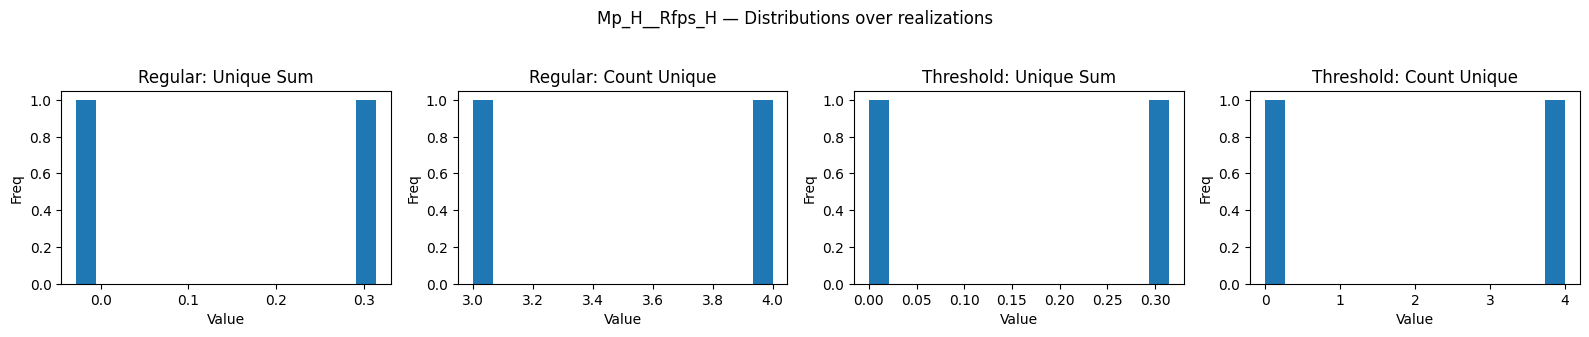

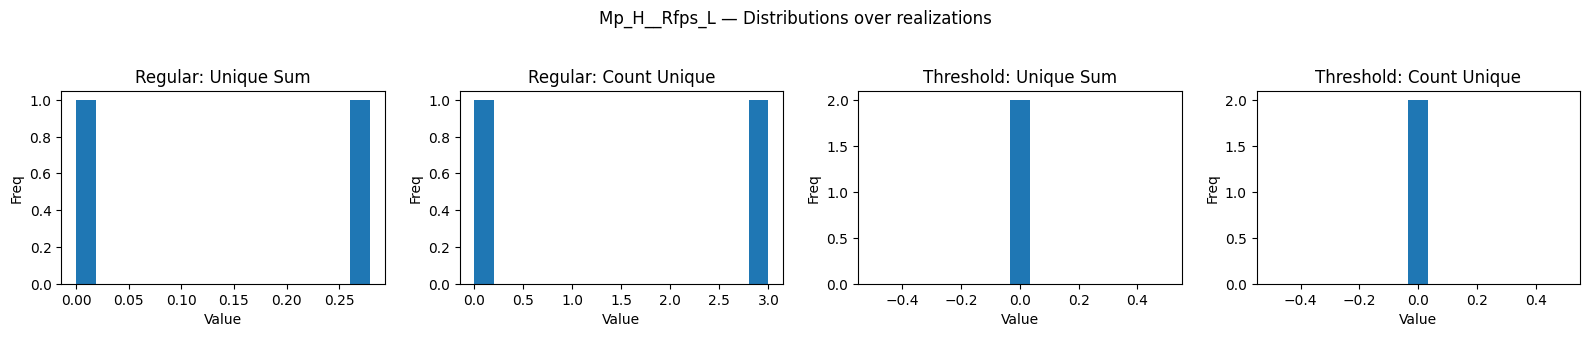

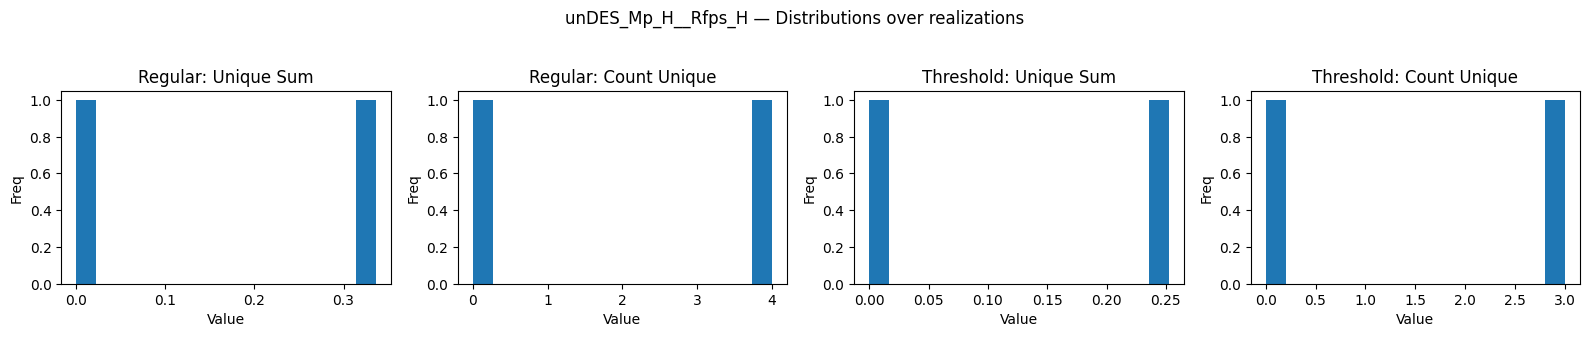

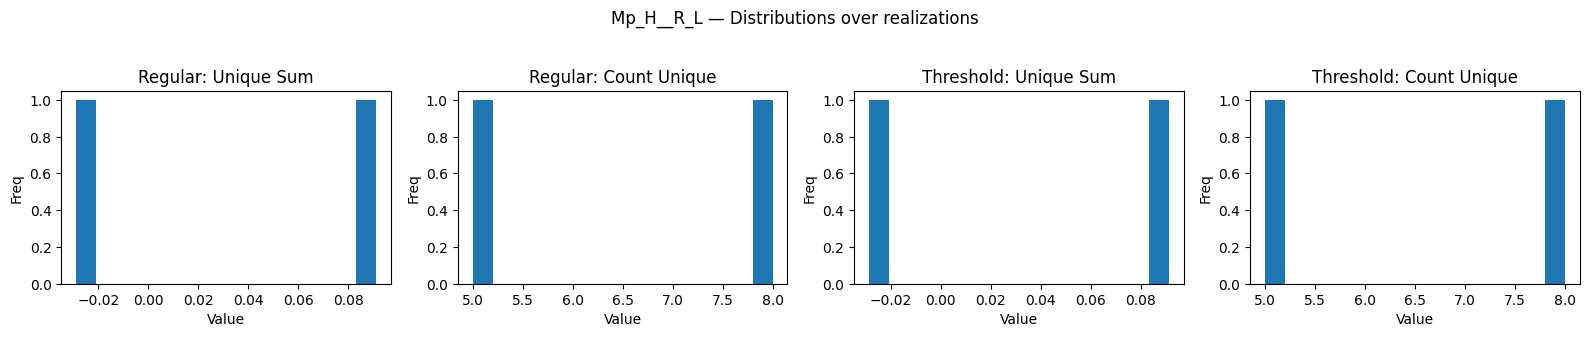

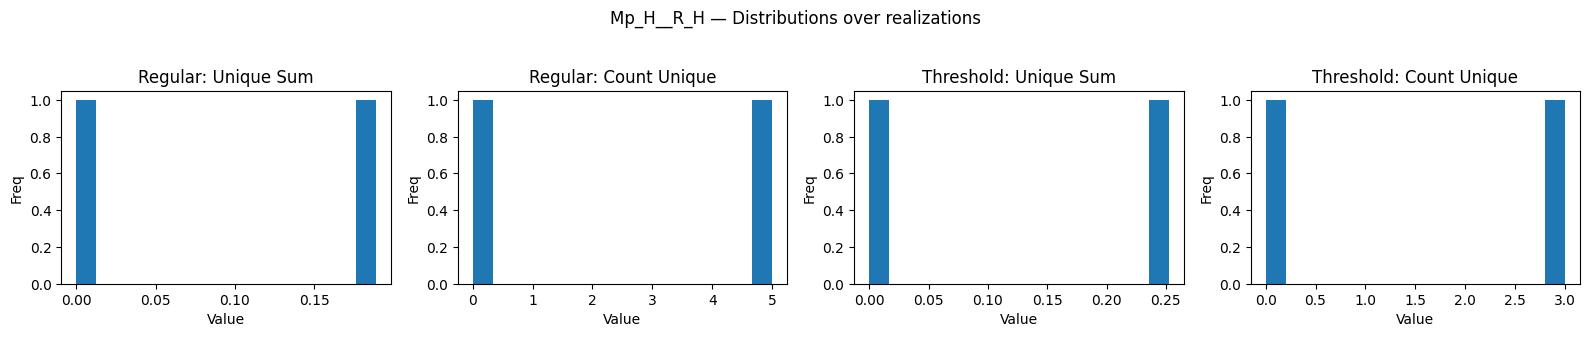

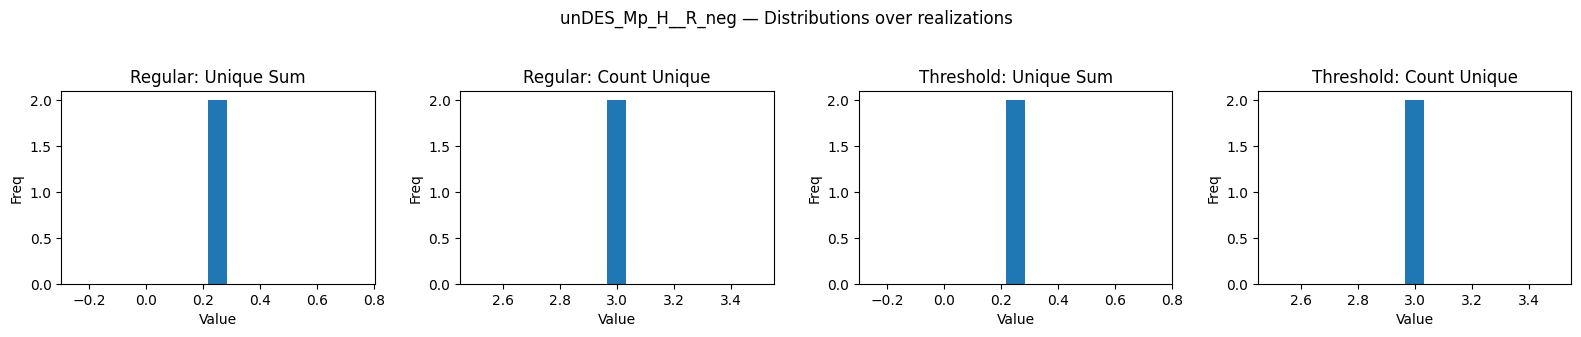

In [21]:
#####                                                models selection code   DIST PLOTS 

import matplotlib.pyplot as plt

METRICS = [
    "REG_UNIQUE_SUM",
    "REG_NUM_PREDS_UNIQUE",
    "THR_UNIQUE_SUM",
    "THR_NUM_PREDS_UNIQUE",
]

TITLES = {
    "REG_UNIQUE_SUM":        "Regular: Unique Sum",
    "REG_NUM_PREDS_UNIQUE":  "Regular: Count Unique",
    "THR_UNIQUE_SUM":        "Threshold: Unique Sum",
    "THR_NUM_PREDS_UNIQUE":  "Threshold: Count Unique",
}

for model_key, metric_dict in ALL_models_results_across_realizations.items():
    fig, axes = plt.subplots(1, 4, figsize=(16, 3.5))
    fig.suptitle(f"{model_key} — Distributions over realizations", fontsize=12)

    for idx, metric in enumerate(METRICS):
        ax = axes[idx]
        vals = metric_dict.get(metric, [])
        if vals:
            ax.hist(vals, bins=15)
            ax.set_xlabel("Value")
            ax.set_ylabel("Freq")
        else:
            ax.text(0.5, 0.5, "No data", ha="center", va="center", transform=ax.transAxes)
            ax.set_xticks([]); ax.set_yticks([])

        ax.set_title(TITLES.get(metric, metric))

    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


In [22]:
dd = dict(ALL_models_results_across_realizations)

#### print sum of all vals reg and thresh for unique sum
for k, v in dd.items():
    REG_UNIQUE_ALL_flat = [item for sublist in v["REG_UNIQUE_ALL"] for item in sublist]
    THRESH_UNIQUE_ALL_flat = [item for sublist in v["THR_UNIQUE_ALL"] for item in sublist]

    print(f"{k}")
    
    print(f"  REG_UNIQUE_SUM: " , sum(set(REG_UNIQUE_ALL_flat)))
    print(f"  REG_NUM_PREDS_UNIQUE: " , len(set(REG_UNIQUE_ALL_flat)))
    REG_RETURN_PER_TRADE = sum(set(REG_UNIQUE_ALL_flat)) / len(set(REG_UNIQUE_ALL_flat)) if len(set(REG_UNIQUE_ALL_flat)) > 0 else 0
    print( " REG_RETURN_PER_TRADE: " , REG_RETURN_PER_TRADE)

    print(f"  THRESH_UNIQUE_SUM: " , sum(set(THRESH_UNIQUE_ALL_flat)))
    print(f"  THR_NUM_PREDS_UNIQUE: " , len(set(THRESH_UNIQUE_ALL_flat)))
    REG_RETURN_PER_TRADE_THRESH = sum(set(THRESH_UNIQUE_ALL_flat)) / len(set(THRESH_UNIQUE_ALL_flat)) if len(set(THRESH_UNIQUE_ALL_flat)) > 0 else 0
    print( " REG_RETURN_PER_TRADE_THRESH: " , REG_RETURN_PER_TRADE_THRESH)




    if (REG_RETURN_PER_TRADE_THRESH == REG_RETURN_PER_TRADE) :
            print(" --> SAME RETURN PER SHARE")
    elif (REG_RETURN_PER_TRADE_THRESH > REG_RETURN_PER_TRADE) :
            print(" --> THRESHOLDING IMPROVED RETURN PER SHARE")

    else:
            print(" --> DID NOT IMPROVE RETURN PER SHARE")


Mp_H__Rfps_H
  REG_UNIQUE_SUM:  0.06941031990586743
  REG_NUM_PREDS_UNIQUE:  5
 REG_RETURN_PER_TRADE:  0.013882063981173486
  THRESH_UNIQUE_SUM:  0.31422260250152534
  THR_NUM_PREDS_UNIQUE:  4
 REG_RETURN_PER_TRADE_THRESH:  0.07855565062538133
 --> THRESHOLDING IMPROVED RETURN PER SHARE
Mp_H__Rfps_L
  REG_UNIQUE_SUM:  0.2790847827846148
  REG_NUM_PREDS_UNIQUE:  3
 REG_RETURN_PER_TRADE:  0.09302826092820493
  THRESH_UNIQUE_SUM:  0
  THR_NUM_PREDS_UNIQUE:  0
 REG_RETURN_PER_TRADE_THRESH:  0
 --> DID NOT IMPROVE RETURN PER SHARE
unDES_Mp_H__Rfps_H
  REG_UNIQUE_SUM:  0.3360185931649975
  REG_NUM_PREDS_UNIQUE:  4
 REG_RETURN_PER_TRADE:  0.08400464829124937
  THRESH_UNIQUE_SUM:  0.2522377123916355
  THR_NUM_PREDS_UNIQUE:  3
 REG_RETURN_PER_TRADE_THRESH:  0.0840792374638785
 --> THRESHOLDING IMPROVED RETURN PER SHARE
Mp_H__R_L
  REG_UNIQUE_SUM:  -0.028829803350370664
  REG_NUM_PREDS_UNIQUE:  8
 REG_RETURN_PER_TRADE:  -0.003603725418796333
  THRESH_UNIQUE_SUM:  -0.028829803350370664
  THR_NUM_

In [38]:
#*#*#*#*#   NOTE        LOW RECALL TEST 


####                                   Model Selection (seeds chosen at random)

# params to analyze - mean_precision_range , min_ratio_difference , max_FP_severe_ratio_FPs


#############

Mp_H__Rfps_H__param_map = {   # params to analyze
                             "mean_precision_range" : (40, 100),
                             "max_zero_precision_seeds" : 70,
                             "max_FP_severe_ratio_FPs" : 0.4, "min_FP_severe_ratio_FPs" : None,
                             "mean_recall_up_range" : (0, 30), "seed_recall_range" : (0, 30),
                             # params ignored 
                             "min_ratio_difference" : None, "max_ratio_difference" : None,
                             "seed_precision_range" : (0, 100), "min_seeds_per_model" : 1,"max_models_to_return" : 90, "seed_min_TPminusFP_greaterEqual" : None,"max_FP_severe_ratio_FPs_andTPs" : None, 
                             "max_seed_severe_FPs_high_bracket" : None,"min_seed_TPs_high_bracket" : None, "random_seed" : None , "min_FP_severe_ratio_FPs_andTPs" : None
                               }


Mp_H__Rfps_L__param_map = {   # params to analyze
                             "mean_precision_range" : (40, 100),
                             "max_zero_precision_seeds" : 70,
                             "max_FP_severe_ratio_FPs" : 0.2, "min_FP_severe_ratio_FPs" : None,
                             "mean_recall_up_range" : (0, 30), "seed_recall_range" : (0, 30),


                             # params ignored 
                             "min_ratio_difference" : None, "max_ratio_difference" : None,
                             "seed_precision_range" : (1, 40),  "min_seeds_per_model" : 1,"max_models_to_return" : 90, "seed_min_TPminusFP_greaterEqual" : None,"max_FP_severe_ratio_FPs_andTPs" : None, 
                             "max_seed_severe_FPs_high_bracket" : None,"min_seed_TPs_high_bracket" : None, "random_seed" : None , "min_FP_severe_ratio_FPs_andTPs" : None
                               }


unDES_Mp_H__Rfps_H__param_map = {   
                             "mean_precision_range" : (40, 100),

                             "max_zero_precision_seeds" : 70,
                             "max_FP_severe_ratio_FPs" : 0.7, "min_FP_severe_ratio_FPs" : .5,         
                             "mean_recall_up_range" : (0, 30), "seed_recall_range" : (0, 30),


                             "min_ratio_difference" : None, "max_ratio_difference" : None,
                             "seed_precision_range" : (0, 100),  "min_seeds_per_model" : 1,"max_models_to_return" : 90, "seed_min_TPminusFP_greaterEqual" : None,"max_FP_severe_ratio_FPs_andTPs" : None, 
                             "max_seed_severe_FPs_high_bracket" : None,"min_seed_TPs_high_bracket" : None, "random_seed" : None , "min_FP_severe_ratio_FPs_andTPs" : None
                               }

### 
Mp_H__R_L__param_map = {   
                             "mean_precision_range" : (40, 100),

                             "max_zero_precision_seeds" : 70,
                             "max_FP_severe_ratio_FPs" : None, "min_FP_severe_ratio_FPs" : None,
                             "mean_recall_up_range" : (0, 30), "seed_recall_range" : (0, 30),



                             "min_ratio_difference" : 0.1, "max_ratio_difference" : .3,
                             "seed_precision_range" : (0, 100),  "min_seeds_per_model" : 1,"max_models_to_return" : 90, "seed_min_TPminusFP_greaterEqual" : None,"max_FP_severe_ratio_FPs_andTPs" : None, 
                             "max_seed_severe_FPs_high_bracket" : None,"min_seed_TPs_high_bracket" : None, "random_seed" : None , "min_FP_severe_ratio_FPs_andTPs" : None
                               }


Mp_H__R_H__param_map = {  
                             "mean_precision_range" : (40, 100),

                             "max_zero_precision_seeds" : 70,
                             "max_FP_severe_ratio_FPs" : None, "min_FP_severe_ratio_FPs" : None,
                             "mean_recall_up_range" : (0, 30), "seed_recall_range" : (0, 40),



                             "min_ratio_difference" : .3, "max_ratio_difference" : None ,
                             "seed_precision_range" : (0, 100),  "min_seeds_per_model" : 1,"max_models_to_return" : 90, "seed_min_TPminusFP_greaterEqual" : None,"max_FP_severe_ratio_FPs_andTPs" : None, 
                             "max_seed_severe_FPs_high_bracket" : None,"min_seed_TPs_high_bracket" : None, "random_seed" : None , "min_FP_severe_ratio_FPs_andTPs" : None
                               }

unDES_Mp_H__R_neg__param_map = {   
                             "mean_precision_range" : (50, 100),

                             "max_zero_precision_seeds" : 70,
                             "max_FP_severe_ratio_FPs" : None, "min_FP_severe_ratio_FPs" : None,         
                             "mean_recall_up_range" : (0, 70), "seed_recall_range" : (0, 30),


                             "min_ratio_difference" : None, "max_ratio_difference" : 0,
                             "seed_precision_range" : (0, 100), "min_seeds_per_model" : 1,"max_models_to_return" : 90, "seed_min_TPminusFP_greaterEqual" : None,"max_FP_severe_ratio_FPs_andTPs" : None, 
                             "max_seed_severe_FPs_high_bracket" : None,"min_seed_TPs_high_bracket" : None, "random_seed" : None , "min_FP_severe_ratio_FPs_andTPs" : None
                               }

# ###################





Mp_H__Rfps_H__param_map_models = select_models_by_criteria(results_dist_disc, **Mp_H__Rfps_H__param_map)
Mp_H__Rfps_L__param_map_models = select_models_by_criteria(results_dist_disc, **Mp_H__Rfps_L__param_map)
unDES_Mp_H__Rfps_H__param_map_models = select_models_by_criteria(results_dist_disc, **unDES_Mp_H__Rfps_H__param_map)


Mp_H__R_L__param_map_models = select_models_by_criteria(results_dist_disc, **Mp_H__R_L__param_map)
Mp_H__R_H__param_map_models = select_models_by_criteria(results_dist_disc, **Mp_H__R_H__param_map)
unDES_Mp_H__R_neg__param_map_models = select_models_by_criteria(results_dist_disc, **unDES_Mp_H__R_neg__param_map)


models_res_names_dict = { ## print model seleciton info , 

    "Mp_H__Rfps_H": Mp_H__Rfps_H__param_map_models,
    "Mp_H__Rfps_L": Mp_H__Rfps_L__param_map_models,
    "Mp_H__Rfps_L": Mp_H__Rfps_L__param_map_models,
    "unDES_Mp_H__Rfps_H": unDES_Mp_H__Rfps_H__param_map_models,

    "Mp_H__R_L": Mp_H__R_L__param_map_models,
    "Mp_H__R_H": Mp_H__R_H__param_map_models,
    "unDES_Mp_H__R_neg": unDES_Mp_H__R_neg__param_map_models

}   

for k, selected_models in models_res_names_dict.items():
   print(f"Models Selected {k}: {len(selected_models)}")
   total_seeds = sum(len(model["selected_seeds"]) for model in selected_models)
   print(f"Total seeds selected {k}: {total_seeds}")
   print("-" * 5)



#### collect raw V and T set data for the selected models

Mp_H__Rfps_H__data_V_T_rawData = collect_V_T_set_FULLraw_data(Mp_H__Rfps_H__param_map_models, results_dist_disc, results_dist_disc_Tset_same_seeds_organized)
Mp_H__Rfps_L__data_V_T_rawData = collect_V_T_set_FULLraw_data(Mp_H__Rfps_L__param_map_models, results_dist_disc, results_dist_disc_Tset_same_seeds_organized)
unDES_Mp_H__Rfps_H__data_V_T_rawData = collect_V_T_set_FULLraw_data(unDES_Mp_H__Rfps_H__param_map_models, results_dist_disc, results_dist_disc_Tset_same_seeds_organized)

Mp_H__R_L__data_V_T_rawData = collect_V_T_set_FULLraw_data(Mp_H__R_L__param_map_models, results_dist_disc, results_dist_disc_Tset_same_seeds_organized)
Mp_H__R_H__data_V_T_rawData = collect_V_T_set_FULLraw_data(Mp_H__R_H__param_map_models, results_dist_disc, results_dist_disc_Tset_same_seeds_organized)
unDES_Mp_H__R_neg__data_V_T_rawData = collect_V_T_set_FULLraw_data(unDES_Mp_H__R_neg__param_map_models, results_dist_disc, results_dist_disc_Tset_same_seeds_organized)
#### collect raw V and T set data for the selected models

model_based_selection_maps_raw_V_T_data = {

    "Mp_H__Rfps_H": Mp_H__Rfps_H__data_V_T_rawData,
    "Mp_H__Rfps_L": Mp_H__Rfps_L__data_V_T_rawData,
    "unDES_Mp_H__Rfps_H": unDES_Mp_H__Rfps_H__data_V_T_rawData,

    "Mp_H__R_L": Mp_H__R_L__data_V_T_rawData,
    "Mp_H__R_H": Mp_H__R_H__data_V_T_rawData,
    "unDES_Mp_H__R_neg": unDES_Mp_H__R_neg__data_V_T_rawData
}

# import pickle
# with open('model_based_selection_maps_raw_V_T_data.pkl', 'wb') as f:
#     pickle.dump(model_based_selection_maps_raw_V_T_data, f)


Models Selected Mp_H__Rfps_H: 7
Total seeds selected Mp_H__Rfps_H: 385
-----
Models Selected Mp_H__Rfps_L: 6
Total seeds selected Mp_H__Rfps_L: 117
-----
Models Selected unDES_Mp_H__Rfps_H: 6
Total seeds selected unDES_Mp_H__Rfps_H: 276
-----
Models Selected Mp_H__R_L: 4
Total seeds selected Mp_H__R_L: 214
-----
Models Selected Mp_H__R_H: 5
Total seeds selected Mp_H__R_H: 265
-----
Models Selected unDES_Mp_H__R_neg: 1
Total seeds selected unDES_Mp_H__R_neg: 44
-----


In [39]:

######################################                                                models selection code 

number_realizations_outer = 20  # number of realizations to average over for each model

ALL_models_results_across_realizations = defaultdict(lambda: defaultdict(list))

#### {model_key: {metric: [values across realizations]} , model_key2: {...} , ...}


for i in range(number_realizations_outer):


    Mp_H__Rfps_H__param_map_models = select_models_by_criteria(results_dist_disc, **Mp_H__Rfps_H__param_map)
    Mp_H__Rfps_L__param_map_models = select_models_by_criteria(results_dist_disc, **Mp_H__Rfps_L__param_map)
    unDES_Mp_H__Rfps_H__param_map_models = select_models_by_criteria(results_dist_disc, **unDES_Mp_H__Rfps_H__param_map)


    Mp_H__R_L__param_map_models = select_models_by_criteria(results_dist_disc, **Mp_H__R_L__param_map)
    Mp_H__R_H__param_map_models = select_models_by_criteria(results_dist_disc, **Mp_H__R_H__param_map)
    unDES_Mp_H__R_neg__param_map_models = select_models_by_criteria(results_dist_disc, **unDES_Mp_H__R_neg__param_map)




    #### collect raw V and T set data for the selected models

    Mp_H__Rfps_H__data_V_T_rawData = collect_V_T_set_FULLraw_data(Mp_H__Rfps_H__param_map_models, results_dist_disc, results_dist_disc_Tset_same_seeds_organized)
    Mp_H__Rfps_L__data_V_T_rawData = collect_V_T_set_FULLraw_data(Mp_H__Rfps_L__param_map_models, results_dist_disc, results_dist_disc_Tset_same_seeds_organized)
    unDES_Mp_H__Rfps_H__data_V_T_rawData = collect_V_T_set_FULLraw_data(unDES_Mp_H__Rfps_H__param_map_models, results_dist_disc, results_dist_disc_Tset_same_seeds_organized)

    Mp_H__R_L__data_V_T_rawData = collect_V_T_set_FULLraw_data(Mp_H__R_L__param_map_models, results_dist_disc, results_dist_disc_Tset_same_seeds_organized)
    Mp_H__R_H__data_V_T_rawData = collect_V_T_set_FULLraw_data(Mp_H__R_H__param_map_models, results_dist_disc, results_dist_disc_Tset_same_seeds_organized)
    unDES_Mp_H__R_neg__data_V_T_rawData = collect_V_T_set_FULLraw_data(unDES_Mp_H__R_neg__param_map_models, results_dist_disc, results_dist_disc_Tset_same_seeds_organized) 
    #### collect raw V and T set data for the selected models

    model_based_selection_maps_raw_V_T_data = {

        "Mp_H__Rfps_H": Mp_H__Rfps_H__data_V_T_rawData,
        "Mp_H__Rfps_L": Mp_H__Rfps_L__data_V_T_rawData,
        "unDES_Mp_H__Rfps_H": unDES_Mp_H__Rfps_H__data_V_T_rawData,

        "Mp_H__R_L": Mp_H__R_L__data_V_T_rawData,
        "Mp_H__R_H": Mp_H__R_H__data_V_T_rawData,
        "unDES_Mp_H__R_neg": unDES_Mp_H__R_neg__data_V_T_rawData
    }



    models_data_V_T = {

        "Sr_L__Mr__L__Mp_H__Rfps_H" : {"V_set_data" : model_based_selection_maps_raw_V_T_data["Mp_H__Rfps_H"]["V_set_data"] , "T_set_data" : model_based_selection_maps_raw_V_T_data["Mp_H__Rfps_H"]["T_set_data"]} ,
        "Sr_L__Mr__L__Mp_H__Rfps_L" : {"V_set_data" : model_based_selection_maps_raw_V_T_data["Mp_H__Rfps_L"]["V_set_data"] , "T_set_data" : model_based_selection_maps_raw_V_T_data["Mp_H__Rfps_L"]["T_set_data"]} ,
        "Sr_L__Mr__L__unDES_Mp_H__Rfps_H" : {"V_set_data" : model_based_selection_maps_raw_V_T_data["unDES_Mp_H__Rfps_H"]["V_set_data"] , "T_set_data" : model_based_selection_maps_raw_V_T_data["unDES_Mp_H__Rfps_H"]["T_set_data"]} ,
        ###
        "Sr_L__Mr__L__Mp_H__R_L" : {"V_set_data" : model_based_selection_maps_raw_V_T_data["Mp_H__R_L"]["V_set_data"] , "T_set_data" : model_based_selection_maps_raw_V_T_data["Mp_H__R_L"]["T_set_data"]} ,
        "Sr_L__Mr__L__Mp_H__R_H" : {"V_set_data" : model_based_selection_maps_raw_V_T_data["Mp_H__R_H"]["V_set_data"] , "T_set_data" : model_based_selection_maps_raw_V_T_data["Mp_H__R_H"]["T_set_data"]} ,
        "Sr_L__Mr__L__unDES_Mp_H__R_neg" : {"V_set_data" : model_based_selection_maps_raw_V_T_data["unDES_Mp_H__R_neg"]["V_set_data"] , "T_set_data" : model_based_selection_maps_raw_V_T_data["unDES_Mp_H__R_neg"]["T_set_data"]}
    }


    model_keys = list(models_data_V_T.keys())

    for k in model_keys:
        V_set = models_data_V_T[k]["V_set_data"]
        T_set = models_data_V_T[k]["T_set_data"]
        out = process_and_RETURN_analytics(V_set, T_set, do_print=False)
        
        ALL_models_results_across_realizations[k]["REG_UNIQUE_ALL"].append(out["all_realizations_unique_actuals_ups_regular_UNIQUE"])        
        ALL_models_results_across_realizations[k]["REG_UNIQUE_SUM"].append(out["all_realizations_unique_actuals_ups_regular_UNIQUE_SUM"])
        ALL_models_results_across_realizations[k]["REG_NUM_PREDS_UNIQUE"].append(out["LEN_all_realizations_unique_actuals_ups_regular_UNIQUE"])
        
        ALL_models_results_across_realizations[k]["THR_UNIQUE_ALL"].append(out["all_realizations_unique_actuals_ups_threshold_UNIQUE"])
        ALL_models_results_across_realizations[k]["THR_UNIQUE_SUM"].append(out["all_realizations_unique_actuals_ups_threshold_UNIQUE_SUM"])
        ALL_models_results_across_realizations[k]["THR_NUM_PREDS_UNIQUE"].append(out["LEN_all_realizations_unique_actuals_ups_threshold_UNIQUE"])
        

   # print("Total Unique Up Preds Threshold:", len(all_realizations_unique_actuals_ups_threshold_UNIQUE))


with open('/Users/cs/Desktop/LSTM_ETF_V2/Model Performance Data HOD 21_01 - 22_12/ALL_models_results_across_realization_5.pkl', 'wb') as f:
    pickle.dump(dict(ALL_models_results_across_realizations), f)



[use] pair_2_neg1_1: 4 ensembles of size 2 for 'T'
[use] pair_2_neg1_1: 4 ensembles of size 2 for 'T'
[use] pair_2_neg1_1: 4 ensembles of size 2 for 'T'
[use] pair_2_neg1_1: 4 ensembles of size 2 for 'T'
[use] pair_2_neg1_1: 4 ensembles of size 2 for 'T'
[use] pair_2_neg1_1: 4 ensembles of size 2 for 'T'
[use] pair_2_neg1_1: 4 ensembles of size 2 for 'T'
[use] pair_2_neg1_1: 4 ensembles of size 2 for 'T'
[use] pair_2_neg1_1: 4 ensembles of size 2 for 'T'
[use] pair_2_neg1_1: 4 ensembles of size 2 for 'T'
[use] pair_2_neg1_1: 4 ensembles of size 2 for 'T'
[use] pair_2_neg1_1: 4 ensembles of size 2 for 'T'
[use] pair_2_neg1_1: 4 ensembles of size 2 for 'T'
[use] pair_2_neg1_1: 4 ensembles of size 2 for 'T'
[use] pair_2_neg1_1: 4 ensembles of size 2 for 'T'
[use] pair_2_neg1_1: 4 ensembles of size 2 for 'T'
[use] pair_2_neg1_1: 4 ensembles of size 2 for 'T'
[use] pair_2_neg1_1: 4 ensembles of size 2 for 'T'
[use] pair_2_neg1_1: 4 ensembles of size 2 for 'T'
[use] pair_2_neg1_1: 4 ensemble

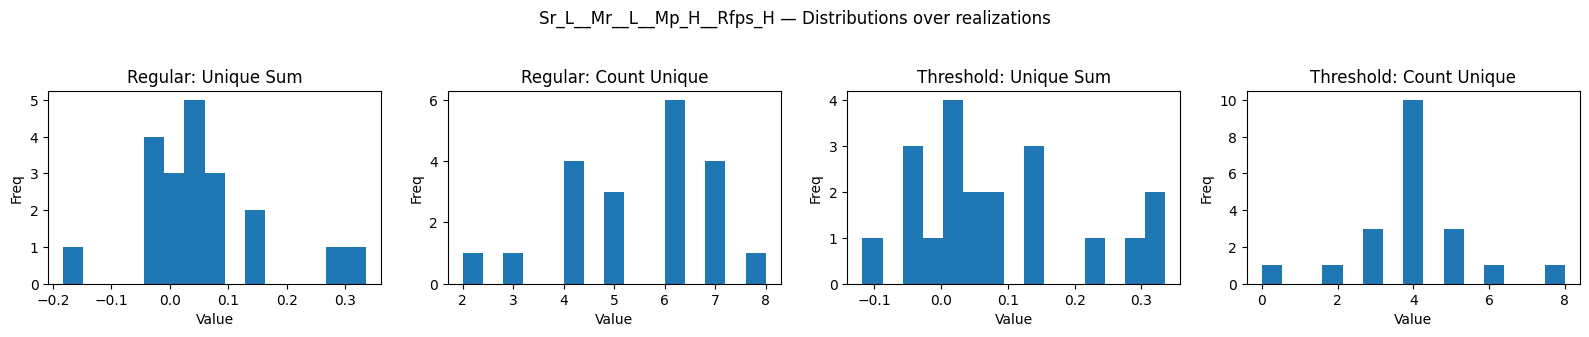

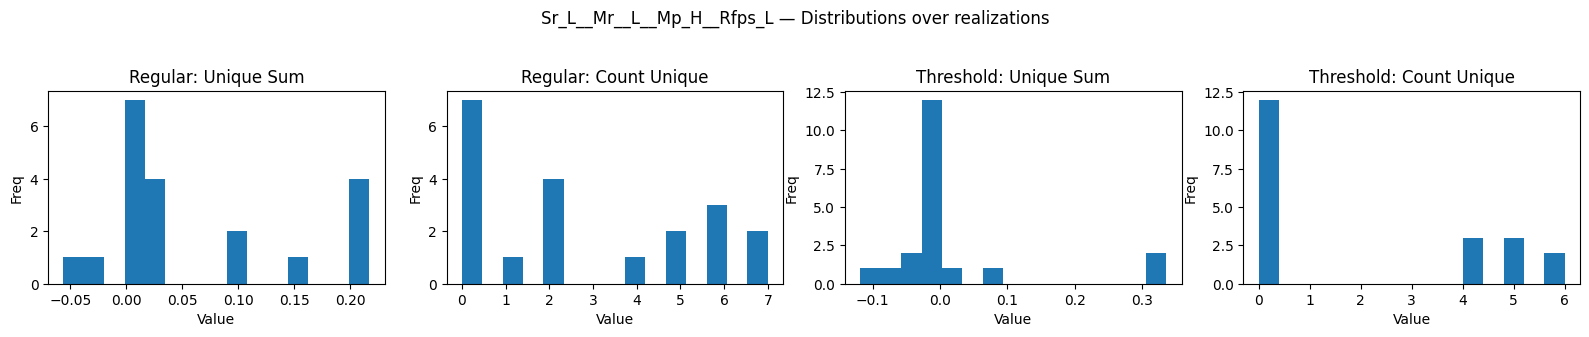

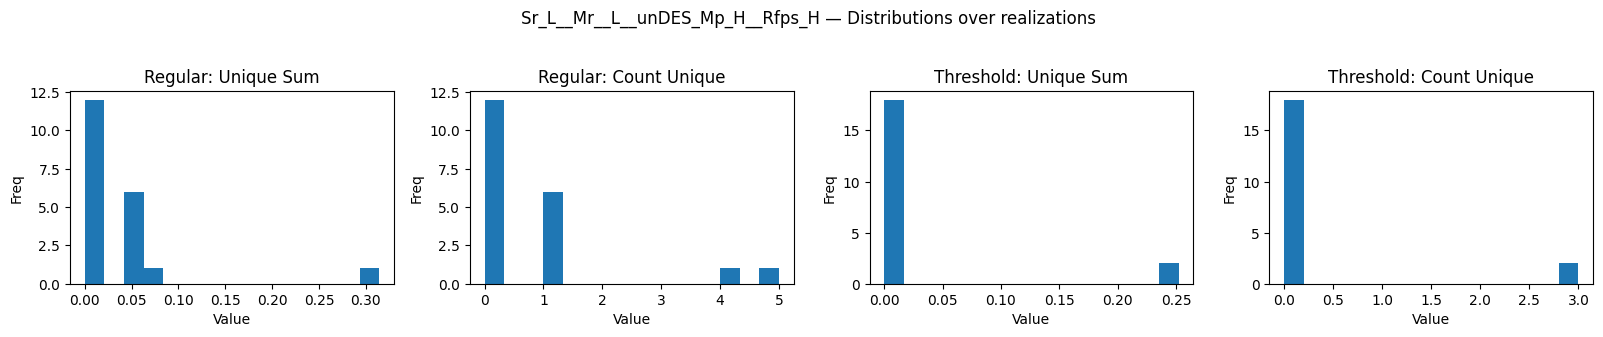

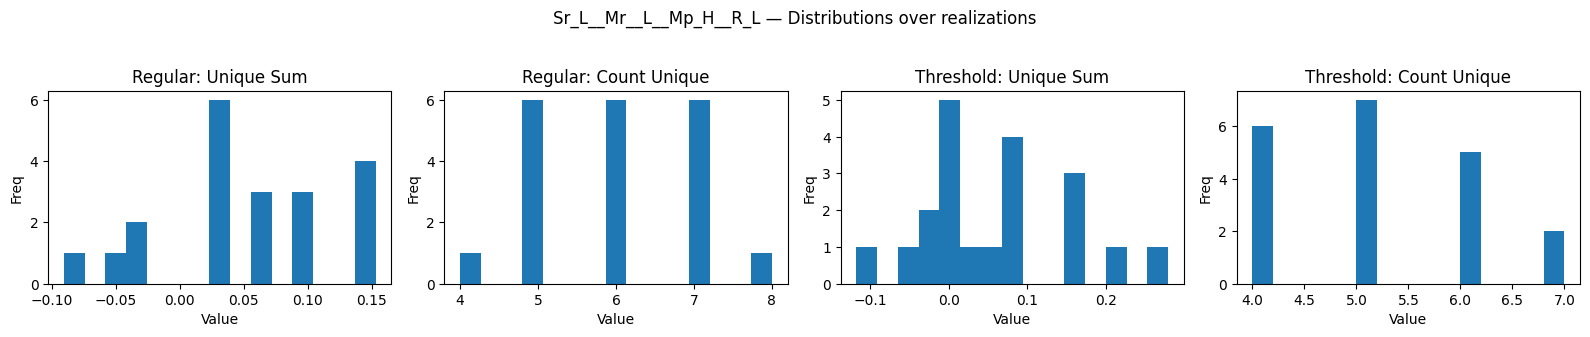

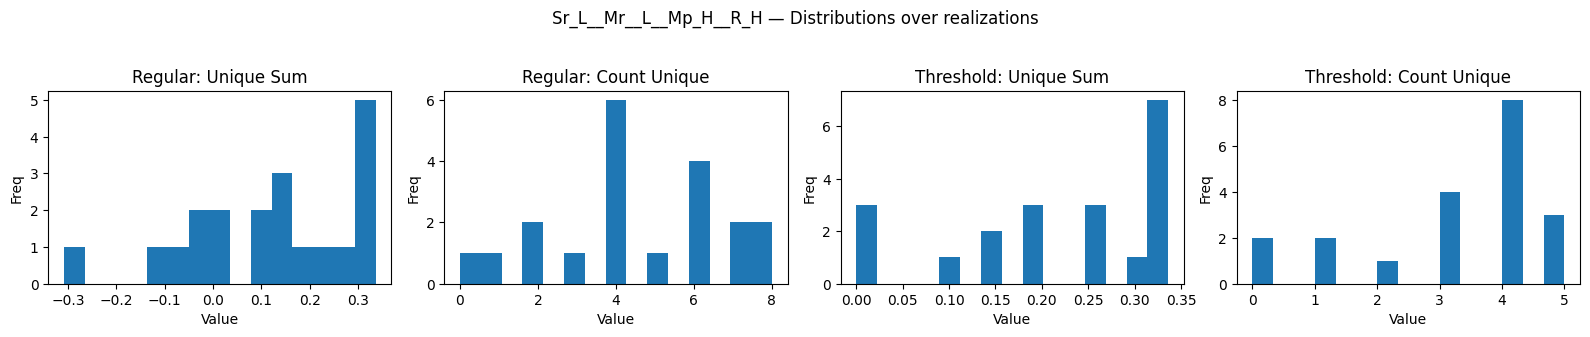

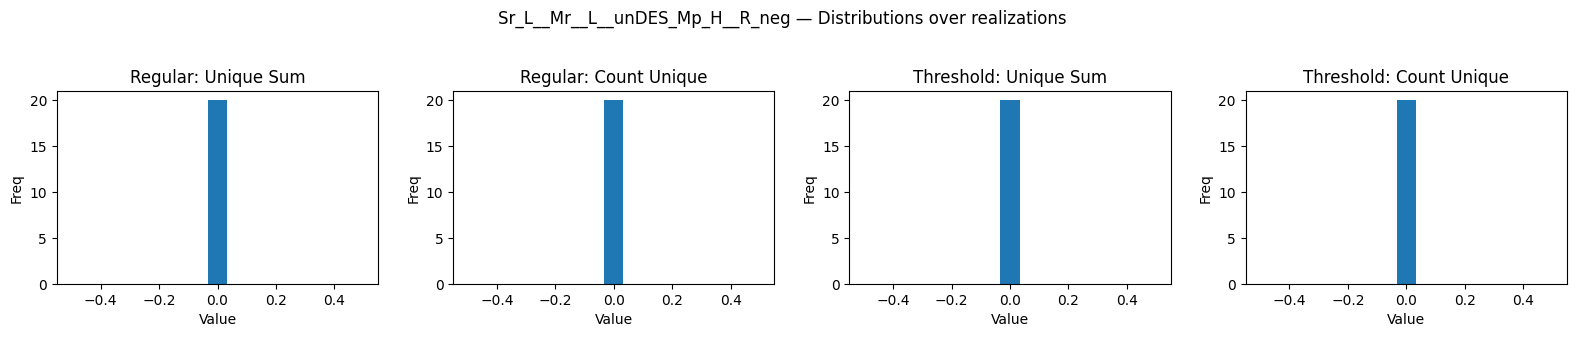

In [25]:
#####                                                models selection code   DIST PLOTS 

import matplotlib.pyplot as plt

METRICS = [
    "REG_UNIQUE_SUM",
    "REG_NUM_PREDS_UNIQUE",
    "THR_UNIQUE_SUM",
    "THR_NUM_PREDS_UNIQUE",
]

TITLES = {
    "REG_UNIQUE_SUM":        "Regular: Unique Sum",
    "REG_NUM_PREDS_UNIQUE":  "Regular: Count Unique",
    "THR_UNIQUE_SUM":        "Threshold: Unique Sum",
    "THR_NUM_PREDS_UNIQUE":  "Threshold: Count Unique",
}

for model_key, metric_dict in ALL_models_results_across_realizations.items():
    fig, axes = plt.subplots(1, 4, figsize=(16, 3.5))
    fig.suptitle(f"{model_key} — Distributions over realizations", fontsize=12)

    for idx, metric in enumerate(METRICS):
        ax = axes[idx]
        vals = metric_dict.get(metric, [])
        if vals:
            ax.hist(vals, bins=15)
            ax.set_xlabel("Value")
            ax.set_ylabel("Freq")
        else:
            ax.text(0.5, 0.5, "No data", ha="center", va="center", transform=ax.transAxes)
            ax.set_xticks([]); ax.set_yticks([])

        ax.set_title(TITLES.get(metric, metric))

    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


In [26]:
dd = dict(ALL_models_results_across_realizations)



#### print sum of all vals reg and thresh for unique sum
for k, v in dd.items():
    REG_UNIQUE_ALL_flat = [item for sublist in v["REG_UNIQUE_ALL"] for item in sublist]
    THRESH_UNIQUE_ALL_flat = [item for sublist in v["THR_UNIQUE_ALL"] for item in sublist]

    print(f"{k}")
    
    print(f"  REG_UNIQUE_SUM: " , sum(set(REG_UNIQUE_ALL_flat)))
    print(f"  REG_NUM_PREDS_UNIQUE: " , len(set(REG_UNIQUE_ALL_flat)))
    REG_RETURN_PER_TRADE = sum(set(REG_UNIQUE_ALL_flat)) / len(set(REG_UNIQUE_ALL_flat)) if len(set(REG_UNIQUE_ALL_flat)) > 0 else 0
    print( " REG_RETURN_PER_TRADE: " , REG_RETURN_PER_TRADE)

    print(f"  THRESH_UNIQUE_SUM: " , sum(set(THRESH_UNIQUE_ALL_flat)))
    print(f"  THR_NUM_PREDS_UNIQUE: " , len(set(THRESH_UNIQUE_ALL_flat)))
    REG_RETURN_PER_TRADE_THRESH = sum(set(THRESH_UNIQUE_ALL_flat)) / len(set(THRESH_UNIQUE_ALL_flat)) if len(set(THRESH_UNIQUE_ALL_flat)) > 0 else 0
    print( " REG_RETURN_PER_TRADE_THRESH: " , REG_RETURN_PER_TRADE_THRESH)

    if (REG_RETURN_PER_TRADE_THRESH == REG_RETURN_PER_TRADE) :
            print(" --> SAME RETURN PER SHARE")
    elif (REG_RETURN_PER_TRADE_THRESH > REG_RETURN_PER_TRADE) :
            print(" --> THRESHOLDING IMPROVED RETURN PER SHARE")

    else:
            print(" --> DID NOT IMPROVE RETURN PER SHARE")



Sr_L__Mr__L__Mp_H__Rfps_H
  REG_UNIQUE_SUM:  -0.028829803350370664
  REG_NUM_PREDS_UNIQUE:  8
 REG_RETURN_PER_TRADE:  -0.003603725418796333
  THRESH_UNIQUE_SUM:  -0.028829803350370664
  THR_NUM_PREDS_UNIQUE:  8
 REG_RETURN_PER_TRADE_THRESH:  -0.003603725418796333
 --> SAME RETURN PER SHARE
Sr_L__Mr__L__Mp_H__Rfps_L
  REG_UNIQUE_SUM:  -0.028829803350370664
  REG_NUM_PREDS_UNIQUE:  8
 REG_RETURN_PER_TRADE:  -0.003603725418796333
  THRESH_UNIQUE_SUM:  -0.034388361171859394
  THR_NUM_PREDS_UNIQUE:  6
 REG_RETURN_PER_TRADE_THRESH:  -0.005731393528643232
 --> DID NOT IMPROVE RETURN PER SHARE
Sr_L__Mr__L__unDES_Mp_H__Rfps_H
  REG_UNIQUE_SUM:  0.06941031990586743
  REG_NUM_PREDS_UNIQUE:  5
 REG_RETURN_PER_TRADE:  0.013882063981173486
  THRESH_UNIQUE_SUM:  0.2522377123916355
  THR_NUM_PREDS_UNIQUE:  3
 REG_RETURN_PER_TRADE_THRESH:  0.0840792374638785
 --> THRESHOLDING IMPROVED RETURN PER SHARE
Sr_L__Mr__L__Mp_H__R_L
  REG_UNIQUE_SUM:  -0.028829803350370664
  REG_NUM_PREDS_UNIQUE:  8
 REG_RETURN

In [35]:
#*#*#*#*#    NOTE      LOW RECALL TEST 
    

####                                   Model Selection (SEED filter only) ---- seed filter only to see if the dist discovery inc the prec 

Mp_H__Sp_H__param_map = {   
                             "mean_precision_range" : (60, 100),"max_zero_precision_seeds" : 70,"max_FP_severe_ratio_FPs" : None, "min_FP_severe_ratio_FPs" : None, "min_ratio_difference" : None, "max_ratio_difference" : None,
                             
                             "seed_precision_range" : (65, 100) , 
                             "mean_recall_up_range" : (0, 30), "seed_recall_range" : (0, 30),
                             "seed_min_TPminusFP_greaterEqual" : None , "max_seed_severe_FPs_high_bracket" : None , "min_seed_TPs_high_bracket" : None ,
                              "min_seeds_per_model" : 1,"max_models_to_return" : 90, "max_FP_severe_ratio_FPs_andTPs" : None, "min_FP_severe_ratio_FPs_andTPs" : None ,"random_seed" : None 

                               }

Mp_H__Sp_M__param_map = {   
                             "mean_precision_range" : (60, 100),"max_zero_precision_seeds" : 70, "max_FP_severe_ratio_FPs" : None, "min_FP_severe_ratio_FPs" : None,"min_ratio_difference" : None, "max_ratio_difference" : None,
                             
                             "seed_precision_range" : (40, 75) , 
                             "mean_recall_up_range" : (0, 30), "seed_recall_range" : (0, 30),



                             "seed_min_TPminusFP_greaterEqual" : None , "max_seed_severe_FPs_high_bracket" : None , 
                             "min_seed_TPs_high_bracket" : None ,
                              "min_seeds_per_model" : 1,"max_models_to_return" : 90, "max_FP_severe_ratio_FPs_andTPs" : None, "min_FP_severe_ratio_FPs_andTPs" : None ,"random_seed" : None 
                               }

Mp_H__Sp_L__param_map = {   
                             "mean_precision_range" : (60, 100),"max_zero_precision_seeds" : 70,"max_FP_severe_ratio_FPs" : None, "min_FP_severe_ratio_FPs" : None, "min_ratio_difference" : None, "max_ratio_difference" : None,

                             "seed_precision_range" : (1, 50) , 
                             "mean_recall_up_range" : (0, 40), "seed_recall_range" : (0, 30),



                             "seed_min_TPminusFP_greaterEqual" : None , "max_seed_severe_FPs_high_bracket" : None , 
                             "min_seed_TPs_high_bracket" : None , 
                              "min_seeds_per_model" : 1,"max_models_to_return" : 90, "max_FP_severe_ratio_FPs_andTPs" : None, "min_FP_severe_ratio_FPs_andTPs" : None ,"random_seed" : None 
                               }

####

Mp_H__TH_Sp_ALL__Hb_0fp1tp__param_map = {   
                             "mean_precision_range" : (60, 100),"max_zero_precision_seeds" : 70,
                             "max_FP_severe_ratio_FPs" : None, "min_FP_severe_ratio_FPs" : None,         
                             "min_ratio_difference" : None, "max_ratio_difference" : None,

                             "seed_precision_range" : (5, 100) , 
                             "seed_min_TPminusFP_greaterEqual" : None , 
                             "max_seed_severe_FPs_high_bracket" : 0 , #**
                             "min_seed_TPs_high_bracket" : 1 , #**
                             "mean_recall_up_range" : (0, 30), "seed_recall_range" : (0, 30),


                              "min_seeds_per_model" : 1,
                             "max_models_to_return" : 90, "max_FP_severe_ratio_FPs_andTPs" : None, 
                             "min_FP_severe_ratio_FPs_andTPs" : None ,"random_seed" : None 

                               }


####                                   Model Selection (SEED + MODEL Fileter)

TH_Mp_H__Sp_ALL__Hb_tp_minus_fp__param_map = {   
                             "mean_precision_range" : (55, 100),
                             "max_zero_precision_seeds" : 70,
                             "max_FP_severe_ratio_FPs" : None,
                             "min_FP_severe_ratio_FPs" : None,         
                             "min_ratio_difference" : None, 
                             "max_ratio_difference" : None,

                             "seed_precision_range" : (5, 100) , 
                             "seed_min_TPminusFP_greaterEqual" : 2 ,  ## not enough models if this number is greater than 2 
                             "max_seed_severe_FPs_high_bracket" : None , 
                             "min_seed_TPs_high_bracket" : None,

                             "mean_recall_up_range" : (0, 30), "seed_recall_range" : (0, 30),




                             "min_seeds_per_model" : 1,
                             "max_models_to_return" : 90,
                             "max_FP_severe_ratio_FPs_andTPs" : None, 
                             "min_FP_severe_ratio_FPs_andTPs" : None,

                             "random_seed" : None

                               }


Mp_H__Sp_H__param_map_models = select_models_by_criteria(results_dist_disc, **Mp_H__Sp_H__param_map)
Mp_H__Sp_M__param_map_models = select_models_by_criteria(results_dist_disc, **Mp_H__Sp_M__param_map)
Mp_H__Sp_L__param_map_models = select_models_by_criteria(results_dist_disc, **Mp_H__Sp_L__param_map)

Mp_H__TH_Sp_ALL__Hb_0fp1tp__param_map_models = select_models_by_criteria(results_dist_disc, **Mp_H__TH_Sp_ALL__Hb_0fp1tp__param_map)

TH_Mp_H__Sp_ALL__Hb_tp_minus_fp__param_map_models = select_models_by_criteria(results_dist_disc, **TH_Mp_H__Sp_ALL__Hb_tp_minus_fp__param_map)


models_res_names_dict = {
    "Mp_H__Sp_H": Mp_H__Sp_H__param_map_models,
    "Mp_H__Sp_M": Mp_H__Sp_M__param_map_models,
    "Mp_H__Sp_L": Mp_H__Sp_L__param_map_models,


    "Mp_H__TH_Sp_ALL__Hb_0fp1tp": Mp_H__TH_Sp_ALL__Hb_0fp1tp__param_map_models,

    "TH_Mp_H__Sp_ALL__Hb_tp_minus_fp": TH_Mp_H__Sp_ALL__Hb_tp_minus_fp__param_map_models
}


for k , selected_models in models_res_names_dict.items():
   print(f"Models Selected {k}: {len(selected_models)}")
   total_seeds = sum(len(model["selected_seeds"]) for model in selected_models)
   print(f"Total seeds selected {k}: {total_seeds}")
   print("-" * 5)


# #### collect raw V and T set data for the selected models
# Mp_H__Sp_H__data_V_T_rawData = collect_V_T_set_FULLraw_data(Mp_H__Sp_H__param_map_models, results_dist_disc, results_dist_disc_Tset_same_seeds_organized)
# Mp_H__Sp_M__data_V_T_rawData = collect_V_T_set_FULLraw_data(Mp_H__Sp_M__param_map_models, results_dist_disc, results_dist_disc_Tset_same_seeds_organized)
# Mp_H__Sp_L__data_V_T_rawData = collect_V_T_set_FULLraw_data(Mp_H__Sp_L__param_map_models, results_dist_disc, results_dist_disc_Tset_same_seeds_organized)

# Mp_H__TH_Sp_ALL__Hb_0fp1tp__data_V_T_rawData = collect_V_T_set_FULLraw_data(Mp_H__TH_Sp_ALL__Hb_0fp1tp__param_map_models, results_dist_disc, results_dist_disc_Tset_same_seeds_organized)


# TH_Mp_H__Sp_ALL__Hb_tp_minus_fp__data_V_T_rawData = collect_V_T_set_FULLraw_data(TH_Mp_H__Sp_ALL__Hb_tp_minus_fp__param_map_models, results_dist_disc, results_dist_disc_Tset_same_seeds_organized)
# #### collect raw V and T set data for the selected models

# V_2_MP_H__model_AND_seed_based_selection_maps_raw_V_T_data = {
#     "Sp_H": Mp_H__Sp_H__data_V_T_rawData,
#     "Sp_M": Mp_H__Sp_M__data_V_T_rawData,
#     "Sp_L": Mp_H__Sp_L__data_V_T_rawData,

#     "TH_Sp_ALL__Hb_0fp1tp": Mp_H__TH_Sp_ALL__Hb_0fp1tp__data_V_T_rawData,

#     "TH_Mp_H__Sp_ALL__Hb_tp_minus_fp": TH_Mp_H__Sp_ALL__Hb_tp_minus_fp__data_V_T_rawData
# }

# # with open('model_AND_seed_based_selection_maps_raw_V_T_data.pkl', 'wb') as f:
# #     pickle.dump(model_AND_seed_based_selection_maps_raw_V_T_data_Seed_and_Model, f)


Models Selected Mp_H__Sp_H: 6
Total seeds selected Mp_H__Sp_H: 155
-----
Models Selected Mp_H__Sp_M: 5
Total seeds selected Mp_H__Sp_M: 48
-----
Models Selected Mp_H__Sp_L: 11
Total seeds selected Mp_H__Sp_L: 220
-----
Models Selected Mp_H__TH_Sp_ALL__Hb_0fp1tp: 1
Total seeds selected Mp_H__TH_Sp_ALL__Hb_0fp1tp: 23
-----
Models Selected TH_Mp_H__Sp_ALL__Hb_tp_minus_fp: 3
Total seeds selected TH_Mp_H__Sp_ALL__Hb_tp_minus_fp: 19
-----


In [36]:


######################################                                                seeds AND models selection code 


number_realizations_outer = 20  # number of realizations to average over for each model

ALL_models_results_across_realizations = defaultdict(lambda: defaultdict(list))

#### {model_key: {metric: [values across realizations]} , model_key2: {...} , ...}


for i in range(number_realizations_outer):

    Mp_H__Sp_H__param_map_models = select_models_by_criteria(results_dist_disc, **Mp_H__Sp_H__param_map)
    Mp_H__Sp_M__param_map_models = select_models_by_criteria(results_dist_disc, **Mp_H__Sp_M__param_map)
    Mp_H__Sp_L__param_map_models = select_models_by_criteria(results_dist_disc, **Mp_H__Sp_L__param_map)

    Mp_H__TH_Sp_ALL__Hb_0fp1tp__param_map_models = select_models_by_criteria(results_dist_disc, **Mp_H__TH_Sp_ALL__Hb_0fp1tp__param_map)

    TH_Mp_H__Sp_ALL__Hb_tp_minus_fp__param_map_models = select_models_by_criteria(results_dist_disc, **TH_Mp_H__Sp_ALL__Hb_tp_minus_fp__param_map)


    # models_res_names_dict = {
    #     "Sp_H": Sp_H__param_map_models,
    #     "Sp_M": Sp_M__param_map_models,
    #     "Sp_L": Sp_L__param_map_models,


    #     "TH_Sp_ALL__Hb_0fp1tp": TH_Sp_ALL__Hb_0fp1tp__param_map_models,
    #     "TH_Sp_ALL__Hb_1fp1tp": TH_Sp_ALL__Hb_1fp1tp__param_map_models,
    #     "TH_Sp_ALL__Hb_tp_minus_fp": TH_Sp_ALL__Hb_tp_minus_fp__param_map_models,

    #     "TH_Mp_H__Sp_ALL__Hb_tp_minus_fp": TH_Mp_H__Sp_ALL__Hb_tp_minus_fp__param_map_models
    # }


    # for k , selected_models in models_res_names_dict.items():
    #    print(f"Models Selected {k}: {len(selected_models)}")
    #    total_seeds = sum(len(model["selected_seeds"]) for model in selected_models)
    #    print(f"Total seeds selected {k}: {total_seeds}")
    #    print("-" * 5)


    #### collect raw V and T set data for the selected models
    Mp_H__Sp_H__data_V_T_rawData = collect_V_T_set_FULLraw_data(Mp_H__Sp_H__param_map_models, results_dist_disc, results_dist_disc_Tset_same_seeds_organized)
    Mp_H__Sp_M__data_V_T_rawData = collect_V_T_set_FULLraw_data(Mp_H__Sp_M__param_map_models, results_dist_disc, results_dist_disc_Tset_same_seeds_organized)
    Mp_H__Sp_L__data_V_T_rawData = collect_V_T_set_FULLraw_data(Mp_H__Sp_L__param_map_models, results_dist_disc, results_dist_disc_Tset_same_seeds_organized)

    Mp_H__TH_Sp_ALL__Hb_0fp1tp__data_V_T_rawData = collect_V_T_set_FULLraw_data(Mp_H__TH_Sp_ALL__Hb_0fp1tp__param_map_models, results_dist_disc, results_dist_disc_Tset_same_seeds_organized)


    TH_Mp_H__Sp_ALL__Hb_tp_minus_fp__data_V_T_rawData = collect_V_T_set_FULLraw_data(TH_Mp_H__Sp_ALL__Hb_tp_minus_fp__param_map_models, results_dist_disc, results_dist_disc_Tset_same_seeds_organized)
    #### collect raw V and T set data for the selected models

    model_AND_seed_based_selection_maps_raw_V_T_data = {
        "Mp_H__Sp_H": Mp_H__Sp_H__data_V_T_rawData,
        "Mp_H__Sp_M": Mp_H__Sp_M__data_V_T_rawData,
        "Mp_H__Sp_L": Mp_H__Sp_L__data_V_T_rawData,

        "Mp_H__TH_Sp_ALL__Hb_0fp1tp": Mp_H__TH_Sp_ALL__Hb_0fp1tp__data_V_T_rawData,

        "TH_Mp_H__Sp_ALL__Hb_tp_minus_fp": TH_Mp_H__Sp_ALL__Hb_tp_minus_fp__data_V_T_rawData
    }

    # with open('model_AND_seed_based_selection_maps_raw_V_T_data.pkl', 'wb') as f:
    #     pickle.dump(model_AND_seed_based_selection_maps_raw_V_T_data_Seed_and_Model, f)


    # dict_keys(['Sp_H', 'Sp_M', 'Sp_L', 'TH_Sp_ALL__Hb_0fp1tp', 'TH_Sp_ALL__Hb_1fp1tp', 
    #       'TH_Sp_ALL__Hb_tp_minus_fp', 'TH_Mp_H__Sp_ALL__Hb_tp_minus_fp'])
    models_AND_seeds_data_V_T = {
        "Sr_L__Mr__L__Mp_H__Sp_H" : {"V_set_data" : model_AND_seed_based_selection_maps_raw_V_T_data["Mp_H__Sp_H"]["V_set_data"] , "T_set_data" : model_AND_seed_based_selection_maps_raw_V_T_data["Mp_H__Sp_H"]["T_set_data"]} ,
        "Sr_L__Mr__L__Mp_H__Sp_M" : {"V_set_data" : model_AND_seed_based_selection_maps_raw_V_T_data["Mp_H__Sp_M"]["V_set_data"] , "T_set_data" : model_AND_seed_based_selection_maps_raw_V_T_data["Mp_H__Sp_M"]["T_set_data"]} ,
        "Sr_L__Mr__L__Mp_H__Sp_L" : {"V_set_data" : model_AND_seed_based_selection_maps_raw_V_T_data["Mp_H__Sp_L"]["V_set_data"] , "T_set_data" : model_AND_seed_based_selection_maps_raw_V_T_data["Mp_H__Sp_L"]["T_set_data"]} ,
        ###
        "Sr_L__Mr__L__Mp_H__TH_Sp_ALL__Hb_0fp1tp" : {"V_set_data" : model_AND_seed_based_selection_maps_raw_V_T_data["Mp_H__TH_Sp_ALL__Hb_0fp1tp"]["V_set_data"] , "T_set_data" : model_AND_seed_based_selection_maps_raw_V_T_data["Mp_H__TH_Sp_ALL__Hb_0fp1tp"]["T_set_data"]} ,

        ###
        "Sr_L__Mr__L__TH_Mp_H__Sp_ALL__Hb_tp_minus_fp" : {"V_set_data" : model_AND_seed_based_selection_maps_raw_V_T_data["TH_Mp_H__Sp_ALL__Hb_tp_minus_fp"]["V_set_data"] , "T_set_data" : model_AND_seed_based_selection_maps_raw_V_T_data["TH_Mp_H__Sp_ALL__Hb_tp_minus_fp"]["T_set_data"]},
    }

    model_keys = list(models_AND_seeds_data_V_T.keys())

    for k in model_keys:
        V_set = models_AND_seeds_data_V_T[k]["V_set_data"]
        T_set = models_AND_seeds_data_V_T[k]["T_set_data"]
        out = process_and_RETURN_analytics(V_set, T_set, do_print=False)
        
        ALL_models_results_across_realizations[k]["REG_UNIQUE_ALL"].append(out["all_realizations_unique_actuals_ups_regular_UNIQUE"])
        ALL_models_results_across_realizations[k]["REG_UNIQUE_SUM"].append(out["all_realizations_unique_actuals_ups_regular_UNIQUE_SUM"])
        ALL_models_results_across_realizations[k]["REG_NUM_PREDS_UNIQUE"].append(out["LEN_all_realizations_unique_actuals_ups_regular_UNIQUE"])

        
        
        ALL_models_results_across_realizations[k]["THR_UNIQUE_ALL"].append(out["all_realizations_unique_actuals_ups_threshold_UNIQUE"])
        ALL_models_results_across_realizations[k]["THR_UNIQUE_SUM"].append(out["all_realizations_unique_actuals_ups_threshold_UNIQUE_SUM"])
        ALL_models_results_across_realizations[k]["THR_NUM_PREDS_UNIQUE"].append(out["LEN_all_realizations_unique_actuals_ups_threshold_UNIQUE"])




with open('/Users/cs/Desktop/LSTM_ETF_V2/Model Performance Data HOD 21_01 - 22_12/ALL_models_results_across_realization_6.pkl', 'wb') as f:
    pickle.dump(dict(ALL_models_results_across_realizations), f)


[use] pair_2_neg1_1: 4 ensembles of size 2 for 'T'
[use] pair_2_neg1_1: 4 ensembles of size 2 for 'T'
[use] pair_2_neg1_1: 4 ensembles of size 2 for 'T'
[use] pair_2_neg1_1: 4 ensembles of size 2 for 'T'
[use] pair_2_neg1_1: 4 ensembles of size 2 for 'T'
[use] pair_2_neg1_1: 4 ensembles of size 2 for 'T'
[use] pair_2_neg1_1: 4 ensembles of size 2 for 'T'
[use] pair_2_neg1_1: 4 ensembles of size 2 for 'T'
[use] pair_2_neg1_1: 4 ensembles of size 2 for 'T'
[use] pair_2_neg1_1: 4 ensembles of size 2 for 'T'
[use] pair_2_neg1_1: 4 ensembles of size 2 for 'T'
[use] pair_2_neg1_1: 4 ensembles of size 2 for 'T'
[use] pair_2_neg1_1: 4 ensembles of size 2 for 'T'
[use] pair_2_neg1_1: 4 ensembles of size 2 for 'T'
[use] pair_2_neg1_1: 4 ensembles of size 2 for 'T'
[use] pair_2_neg1_1: 4 ensembles of size 2 for 'T'
[use] pair_2_neg1_1: 4 ensembles of size 2 for 'T'
[use] pair_2_neg1_1: 4 ensembles of size 2 for 'T'
[use] pair_2_neg1_1: 4 ensembles of size 2 for 'T'
[use] pair_2_neg1_1: 4 ensemble

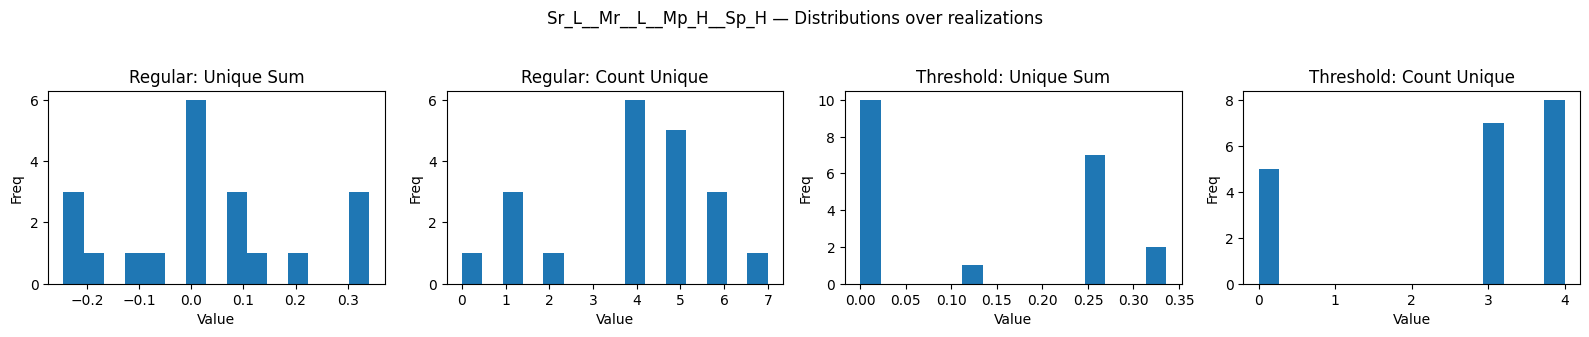

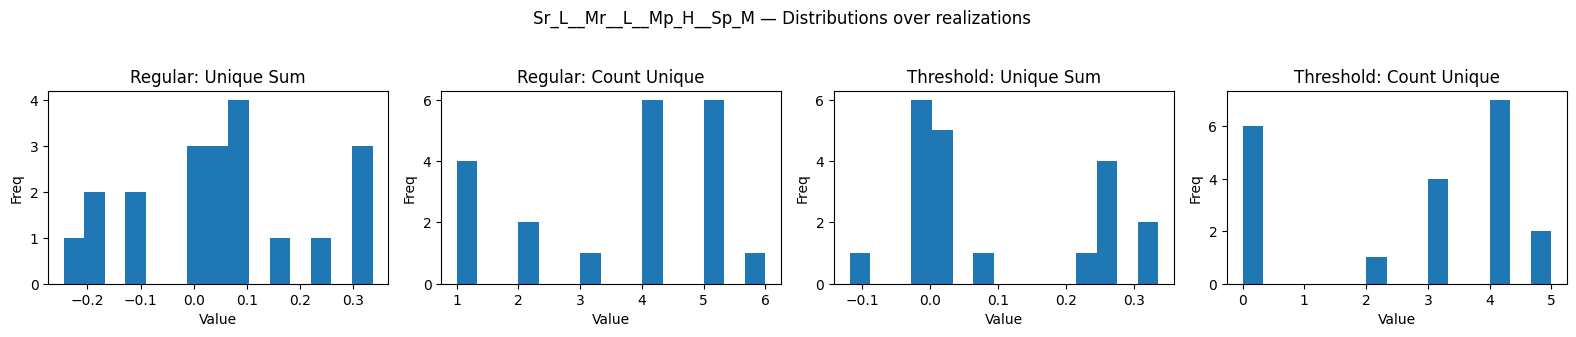

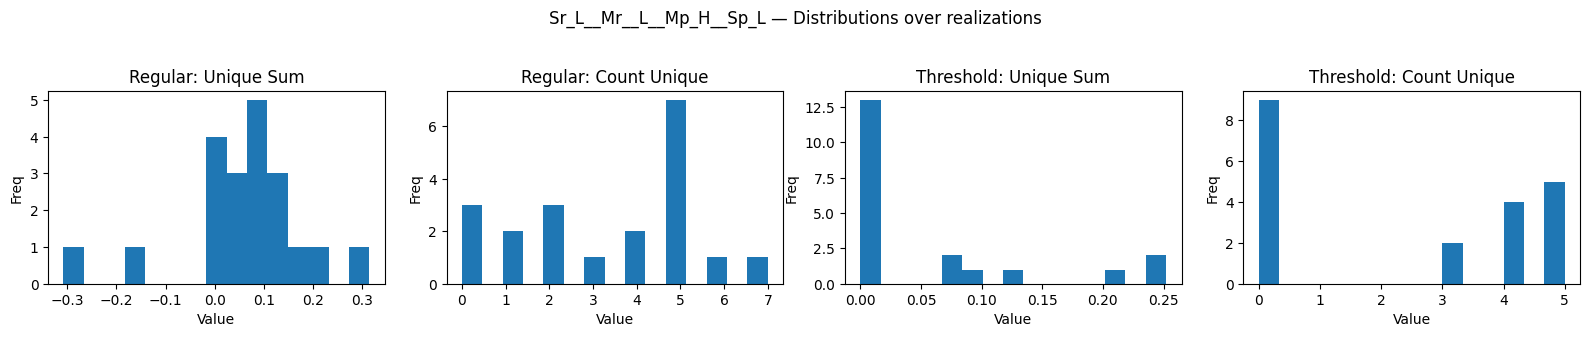

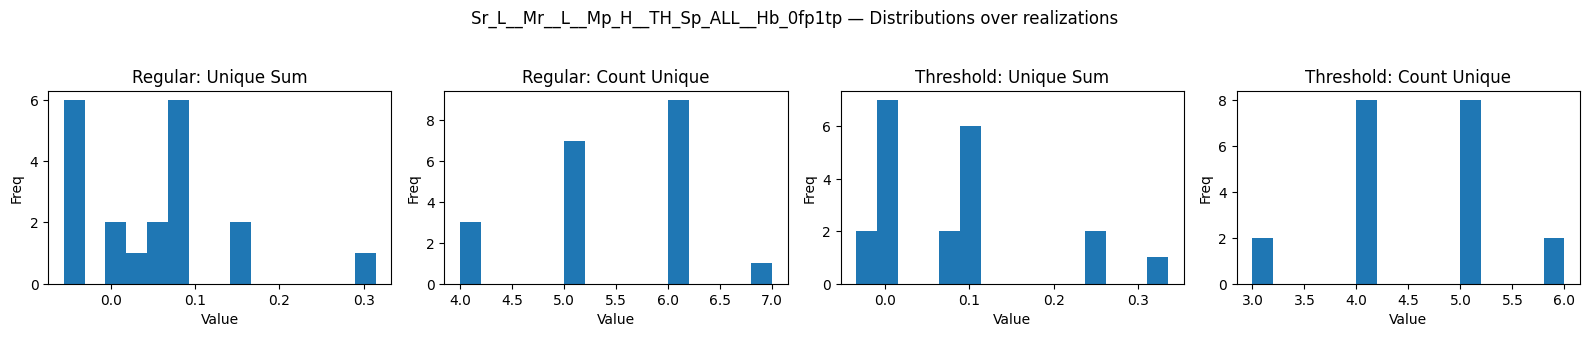

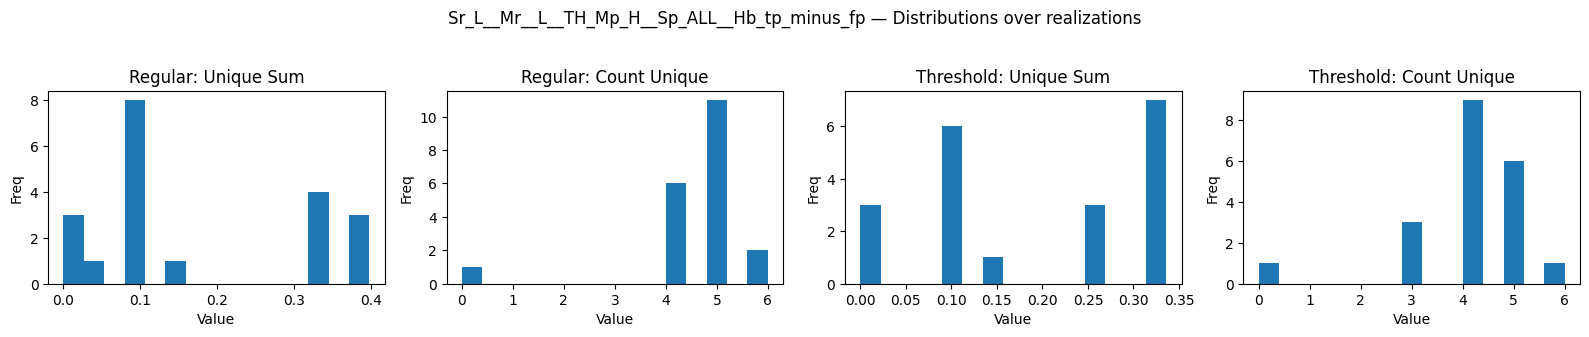

In [29]:
#####                                                models selection code   DIST PLOTS 

import matplotlib.pyplot as plt

METRICS = [
    "REG_UNIQUE_SUM",
    "REG_NUM_PREDS_UNIQUE",
    "THR_UNIQUE_SUM",
    "THR_NUM_PREDS_UNIQUE",
]

TITLES = {
    "REG_UNIQUE_SUM":        "Regular: Unique Sum",
    "REG_NUM_PREDS_UNIQUE":  "Regular: Count Unique",
    "THR_UNIQUE_SUM":        "Threshold: Unique Sum",
    "THR_NUM_PREDS_UNIQUE":  "Threshold: Count Unique",
}

for model_key, metric_dict in ALL_models_results_across_realizations.items():
    fig, axes = plt.subplots(1, 4, figsize=(16, 3.5))
    fig.suptitle(f"{model_key} — Distributions over realizations", fontsize=12)

    for idx, metric in enumerate(METRICS):
        ax = axes[idx]
        vals = metric_dict.get(metric, [])
        if vals:
            ax.hist(vals, bins=15)
            ax.set_xlabel("Value")
            ax.set_ylabel("Freq")
        else:
            ax.text(0.5, 0.5, "No data", ha="center", va="center", transform=ax.transAxes)
            ax.set_xticks([]); ax.set_yticks([])

        ax.set_title(TITLES.get(metric, metric))

    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


In [30]:
dd = dict(ALL_models_results_across_realizations)


#### print sum of all vals reg and thresh for unique sum
for k, v in dd.items():
    REG_UNIQUE_ALL_flat = [item for sublist in v["REG_UNIQUE_ALL"] for item in sublist]
    THRESH_UNIQUE_ALL_flat = [item for sublist in v["THR_UNIQUE_ALL"] for item in sublist]

    print(f"{k}")
    
    print(f"  REG_UNIQUE_SUM: " , sum(set(REG_UNIQUE_ALL_flat)))
    print(f"  REG_NUM_PREDS_UNIQUE: " , len(set(REG_UNIQUE_ALL_flat)))
    REG_RETURN_PER_TRADE = sum(set(REG_UNIQUE_ALL_flat)) / len(set(REG_UNIQUE_ALL_flat)) if len(set(REG_UNIQUE_ALL_flat)) > 0 else 0
    print( " REG_RETURN_PER_TRADE: " , REG_RETURN_PER_TRADE)

    print(f"  THRESH_UNIQUE_SUM: " , sum(set(THRESH_UNIQUE_ALL_flat)))
#     print(set(THRESH_UNIQUE_ALL_flat))
    print(f"  THR_NUM_PREDS_UNIQUE: " , len(set(THRESH_UNIQUE_ALL_flat)))
    REG_RETURN_PER_TRADE_THRESH = sum(set(THRESH_UNIQUE_ALL_flat)) / len(set(THRESH_UNIQUE_ALL_flat)) if len(set(THRESH_UNIQUE_ALL_flat)) > 0 else 0
    print( " REG_RETURN_PER_TRADE_THRESH: " , REG_RETURN_PER_TRADE_THRESH)


    if (REG_RETURN_PER_TRADE_THRESH == REG_RETURN_PER_TRADE) :
            print(" --> SAME RETURN PER SHARE")
    elif (REG_RETURN_PER_TRADE_THRESH > REG_RETURN_PER_TRADE) :
            print(" --> THRESHOLDING IMPROVED RETURN PER SHARE")

    else:
            print(" --> DID NOT IMPROVE RETURN PER SHARE")

Sr_L__Mr__L__Mp_H__Sp_H
  REG_UNIQUE_SUM:  -0.07346131542152678
  REG_NUM_PREDS_UNIQUE:  9
 REG_RETURN_PER_TRADE:  -0.008162368380169642
  THRESH_UNIQUE_SUM:  -0.034388361171859394
  THR_NUM_PREDS_UNIQUE:  6
 REG_RETURN_PER_TRADE_THRESH:  -0.005731393528643232
 --> THRESHOLDING IMPROVED RETURN PER SHARE
Sr_L__Mr__L__Mp_H__Sp_M
  REG_UNIQUE_SUM:  0.02759652893803044
  REG_NUM_PREDS_UNIQUE:  7
 REG_RETURN_PER_TRADE:  0.003942361276861491
  THRESH_UNIQUE_SUM:  -0.034388361171859394
  THR_NUM_PREDS_UNIQUE:  6
 REG_RETURN_PER_TRADE_THRESH:  -0.005731393528643232
 --> DID NOT IMPROVE RETURN PER SHARE
Sr_L__Mr__L__Mp_H__Sp_L
  REG_UNIQUE_SUM:  0.02759652893803044
  REG_NUM_PREDS_UNIQUE:  7
 REG_RETURN_PER_TRADE:  0.003942361276861491
  THRESH_UNIQUE_SUM:  0.02759652893803044
  THR_NUM_PREDS_UNIQUE:  7
 REG_RETURN_PER_TRADE_THRESH:  0.003942361276861491
 --> SAME RETURN PER SHARE
Sr_L__Mr__L__Mp_H__TH_Sp_ALL__Hb_0fp1tp
  REG_UNIQUE_SUM:  -0.01703498313312568
  REG_NUM_PREDS_UNIQUE:  8
 REG_RET